# Zadatak 2

Izvršiti klasifikaciju tipova proteinskih sekvenci na osnovu upotrebe kodona kod SARS2
koronavirusa

- proteinske i kodirajuće sekvence preuzeti sa [NCBI Virus](https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?SeqType_s=Nucleotide&VirusLineage_ss=SARS-CoV-2,%20taxid:2697049).

- upotrebu kodona preuzeti sa [The Genetic Codes](https://www.ncbi.nlm.nih.gov/Taxonomy/Utils/wprintgc.cgi).
Za SARS2 koristiti standardni kod (transl_table=1)

In [5]:
import warnings
import pandas as pd
import numpy as np
import shap
import dtreeviz
import plotly.graph_objects as go
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

from openTSNE import TSNE

from annoy import AnnoyIndex

from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from scikeras.wrappers import KerasClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [2]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

seed = 196883

np.random.seed(seed)

## Priprema podataka

Učitavamo podatke sa jedinstvenim kodirajućim sekvencama proteina SARS-CoV-2.

In [3]:
df = pd.read_csv('samo_jedinstvene_kodirajuce_sekvence.csv', header=None, on_bad_lines='warn')

In [4]:
df.shape

(889737, 15)

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,BCA87360.1,LC528232.2,join,249,13451,13451,21538,2020-02-29-00.00.00.000000,B,4.1.2/1.12/v0.1.10/0.3.17,21291,21291,ORF1ab polyprotein,20200210,ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAAC...
1,BCA87379.1,LC528233.2,raw,29551,29667,0,0,2020-02-29-00.00.00.000000,B.5,4.1.2/1.12/v0.1.10/0.3.17,117,117,ORF10 protein,20200210,ATGGGCTATATAAACGTTTTCGCTTTTCCGTTTACGATATATAGTC...
2,BCB15089.1,LC529905.1,join,266,13468,13468,21555,2020-03-07-00.00.00.000000,B,4.1.2/1.12/v0.1.10/0.3.17,21291,21291,ORF1ab polyprotein,20200115,ATGGAGAGCCTTGTCCCTGGTTTCAACGAGAAAACACACGTCCAAC...
3,BCB15091.1,LC529905.1,raw,25393,26220,0,0,2020-03-07-00.00.00.000000,B,4.1.2/1.12/v0.1.10/0.3.17,828,828,ORF3a protein,20200115,ATGGATTTGTTTATGAGAATCTTCACAATTGGAACTGTAACTTTGA...
4,BCB15098.1,LC529905.1,raw,28274,29533,0,0,2020-03-07-00.00.00.000000,B,4.1.2/1.12/v0.1.10/0.3.17,1260,1260,nucleocapsid phosphoprotein,20200115,ATGTCTGATAATGGACCCCAAAATCAGCGAAATGCACCCCGCATTA...


Izdvajamo kolonu sa kodirajućim sekvencama i kolonu sa oznakama tipova proteina.

In [6]:
df = df[[14, 12]]
df.shape

(889737, 2)

### Čišćenje podataka

Proveravamo da li su kodirajuće sekvence odgovarajuće dužine.
One koje nisu, odbacujemo.

In [7]:
length = np.array([len(a) for a in df[14]])
valid = (length > 8) & (length % 3 == 0)

df = df[valid]
df.shape

(889695, 2)

Proveravamo da li se kodirajuće sekvence sastoje samo od slova A, T, C i G.
Sekvence koje ne ispunjavaju ovaj uslov odbacujemo.

In [8]:
valid = df[14].map(lambda a: set(a).issubset(set('ATCG')))

df = df[valid]
df.shape

(869874, 2)

Proveravamo koliko instanci imamo u svakoj klasi.
Odnosno koliko sekvenci imamo za svaki tip proteina.
Klase koje sadrže 64 instanci i manje odbacujemo zajedno sa instancom.

In [10]:
proteins = df.groupby([12])[12].count()
valid = np.array([proteins[a] for a in df[12]]) > 64

df = df[valid]
df.shape

(869858, 2)

Nakon čišćenja podataka, od jedinstvenih 889737 kodirajućih ostalo nam je 869858 instanci.
Ukupno 19879 instanci je odbačeno kao nevalidno, odnosno oko $2.23\%$ skupa jedinstvenih kodirajućih sekvenci.

### Izračunavanje upotrebe kodona

Računamo koliko često neki kodon kodira svoju amino-kiselinu u svakoj kodirajućoj sekvenci.

Potrebna nam je standardna tabela kodona.

In [11]:
standard_codon_table = {
    'TTT': 'F', 'TCT': 'S', 'TAT': 'Y', 'TGT': 'C',
    'TTC': 'F', 'TCC': 'S', 'TAC': 'Y', 'TGC': 'C',
    'TTA': 'L', 'TCA': 'S', 'TAA': 'O', 'TGA': 'O',
    'TTG': 'L', 'TCG': 'S', 'TAG': 'O', 'TGG': 'W',

    'CTT': 'L', 'CCT': 'P', 'CAT': 'H', 'CGT': 'R',
    'CTC': 'L', 'CCC': 'P', 'CAC': 'H', 'CGC': 'R',
    'CTA': 'L', 'CCA': 'P', 'CAA': 'Q', 'CGA': 'R',
    'CTG': 'L', 'CCG': 'P', 'CAG': 'Q', 'CGG': 'R',

    'ATT': 'I', 'ACT': 'T', 'AAT': 'N', 'AGT': 'S',
    'ATC': 'I', 'ACC': 'T', 'AAC': 'N', 'AGC': 'S',
    'ATA': 'I', 'ACA': 'T', 'AAA': 'K', 'AGA': 'R',
    'ATG': 'M', 'ACG': 'T', 'AAG': 'K', 'AGG': 'R',

    'GTT': 'V', 'GCT': 'A', 'GAT': 'D', 'GGT': 'G',
    'GTC': 'V', 'GCC': 'A', 'GAC': 'D', 'GGC': 'G',
    'GTA': 'V', 'GCA': 'A', 'GAA': 'E', 'GGA': 'G',
    'GTG': 'V', 'GCG': 'A', 'GAG': 'E', 'GGG': 'G'
}

Potrebna nam je i inverzna tabela kodona.

In [12]:
inverse_codon_table = {
    'F': ('TTT', 'TTC'),
    'L': ('CTT', 'CTC', 'CTA', 'CTG', 'TTA', 'TTG'),
    'I': ('ATT', 'ATC', 'ATA'),
    'M': ('ATG', ),
    'V': ('GTT', 'GTC', 'GTA', 'GTG'),
    'S': ('TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'),
    'P': ('CCT', 'CCC', 'CCA', 'CCG'),
    'T': ('ACT', 'ACC', 'ACA', 'ACG'),
    'A': ('GCT', 'GCC', 'GCA', 'GCG'),
    'Y': ('TAT', 'TAC'),
    'O': ('TAA', 'TGA', 'TAG'),
    'H': ('CAT', 'CAC'),
    'Q': ('CAA', 'CAG'),
    'N': ('AAT', 'AAC'),
    'K': ('AAA', 'AAG'),
    'D': ('GAT', 'GAC'),
    'E': ('GAA', 'GAG'),
    'C': ('TGT', 'TGC'),
    'W': ('TGG', ),
    'R': ('CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'),
    'G': ('GGT', 'GGC', 'GGA', 'GGG')
}

Za svaku sekvencu brojimo koliko sadrži kodona.

In [13]:
def count_codons(seq):
    seq = seq[14]
    
    codon_counts = {a: 0 for a in standard_codon_table.keys()}
    
    for i in range(0, len(seq) - 2, 3):
        codon = seq[i:i+3]
        codon_counts[codon] += 1
    
    return codon_counts

codon_counts = df[[14]].apply(count_codons, axis=1, result_type='expand').to_dict('list')
codon_counts = {key: np.array(val, dtype='float64') for key, val in codon_counts.items()}

Za prebrojavanje amino-kiselina u prevedenim sekvencama, nećemo eksplicitno prevoditi sekvence i brojati.
Iskoristićemo činjenicu da smo već izbrojali kodone u kodirajućim sekvencama.
Sada ostaje da za svaku amino-kiselinu saberemo broj kodona koji ih kodiraju, za svaku sekvencu.

In [14]:
length = df.shape[0]

amino_counts = {a: np.zeros(length) for a in inverse_codon_table.keys()}

for amino, codons in inverse_codon_table.items():
    for codon in codons:
        amino_counts[amino] += codon_counts[codon]

Neka se kodon *X* pojavljuje *x* puta u nekoj sekvenci i kodira amino-kiselinu *Y*.
U prevedenoj sekvenci, nakon transkripcije i translacije, amino-kiselina *Y* se pojavljuje *y* puta.
Vrednost
$$
f(X) = \frac{x}{y}
$$
predstavlja upotrebu kodona *X*.

Postoje sekvence koje ne kodiraju sve amino-kiseline, što prilikom primene formule dovodi do deljenja nulom i dodele *NaN* vrednosti.
Zamenićemo *NaN* vrednosti nulom.

In [15]:
for codon in standard_codon_table.keys():
    codon_counts[codon] /= amino_counts[standard_codon_table[codon]]
    np.nan_to_num(codon_counts[codon], copy=False, nan=0, posinf=0, neginf=0) # ako delimo nulom

### Završna priprema podataka i podela na skupove

Rečnik sa vrednostima upotrebe kodona prevodimo u pogodniji format za rad sa tabelarnim podacima.
Odbacujemo podatke o upotrebi stop kodona.

In [16]:
X = pd.DataFrame.from_dict(codon_counts)
X.drop(['TAA', 'TGA', 'TAG'], axis=1, inplace=True)

y = df[12]
y.name = 'Protein'

df = X.join(y, validate='one_to_one')

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

# df.to_csv('proteini_ucestalost_kodona.csv', index=False)
df.head()

,Protein,TTT,TCT,TAT,TGT,TTC,TCC,TAC,TGC,TTA,...,GAC,GGC,GTA,GCA,GAA,GGA,GTG,GCG,GAG,GGG
0,ORF1ab polyprotein,0.728571,0.337719,0.620896,0.814159,0.271429,0.059211,0.379104,0.185841,0.301349,...,0.354756,0.152913,0.229097,0.268994,0.729412,0.184466,0.147157,0.032854,0.270588,0.024272
1,ORF10 protein,0.750000,0.500000,1.000000,0.000000,0.250000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ORF1ab polyprotein,0.727794,0.337719,0.620896,0.814159,0.272206,0.059211,0.379104,0.185841,0.300898,...,0.354756,0.152913,0.229097,0.268994,0.729412,0.184466,0.147157,0.032854,0.270588,0.024272
3,ORF3a protein,0.571429,0.136364,0.470588,0.428571,0.428571,0.181818,0.529412,0.571429,0.103448,...,0.461538,0.214286,0.269231,0.230769,0.909091,0.285714,0.038462,0.000000,0.090909,0.000000
4,nucleocapsid phosphoprotein,0.230769,0.210526,0.181818,0.000000,0.769231,0.078947,0.818182,0.000000,0.074074,...,0.416667,0.372093,0.125000,0.216216,0.666667,0.302326,0.250000,0.081081,0.333333,0.093023


Pravimo enkoder koji kateogričkim ciljnim podacima dodeljuje celobrojne vrednosti.

In [17]:
enc = LabelEncoder()
_ = enc.fit(y.unique())

Konačno, delimo podatke na podatke za test i trening skupove.
Test skup će se sadržati 20% podataka, a ostatak će sadržati trening skup.
Pravimo stratifikovanu podelu, kako bi sve klase bile jednako zastupljene u test i trening skupu.
Dalje u analizi ćemo se fokusirati na trening skup.
Test skup ćemo koristiti isključivo za proveru modela.
U svim ostalim situacijama ponašamo se kao da test skup ne postoji.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [19]:
proteins = y_train.value_counts()

## Vizualizacija i upoznavanje sa podacima

Neuravnoteženost klasa je veoma izražena.
Najviše su zastupljene klase ORF1ab i ORF1a, kojima pripada oko $79\%$ instanci.
Više od $95\%$ instanci predstavlja pet najzastupljenijih, od ukupno dvanaest klasa.

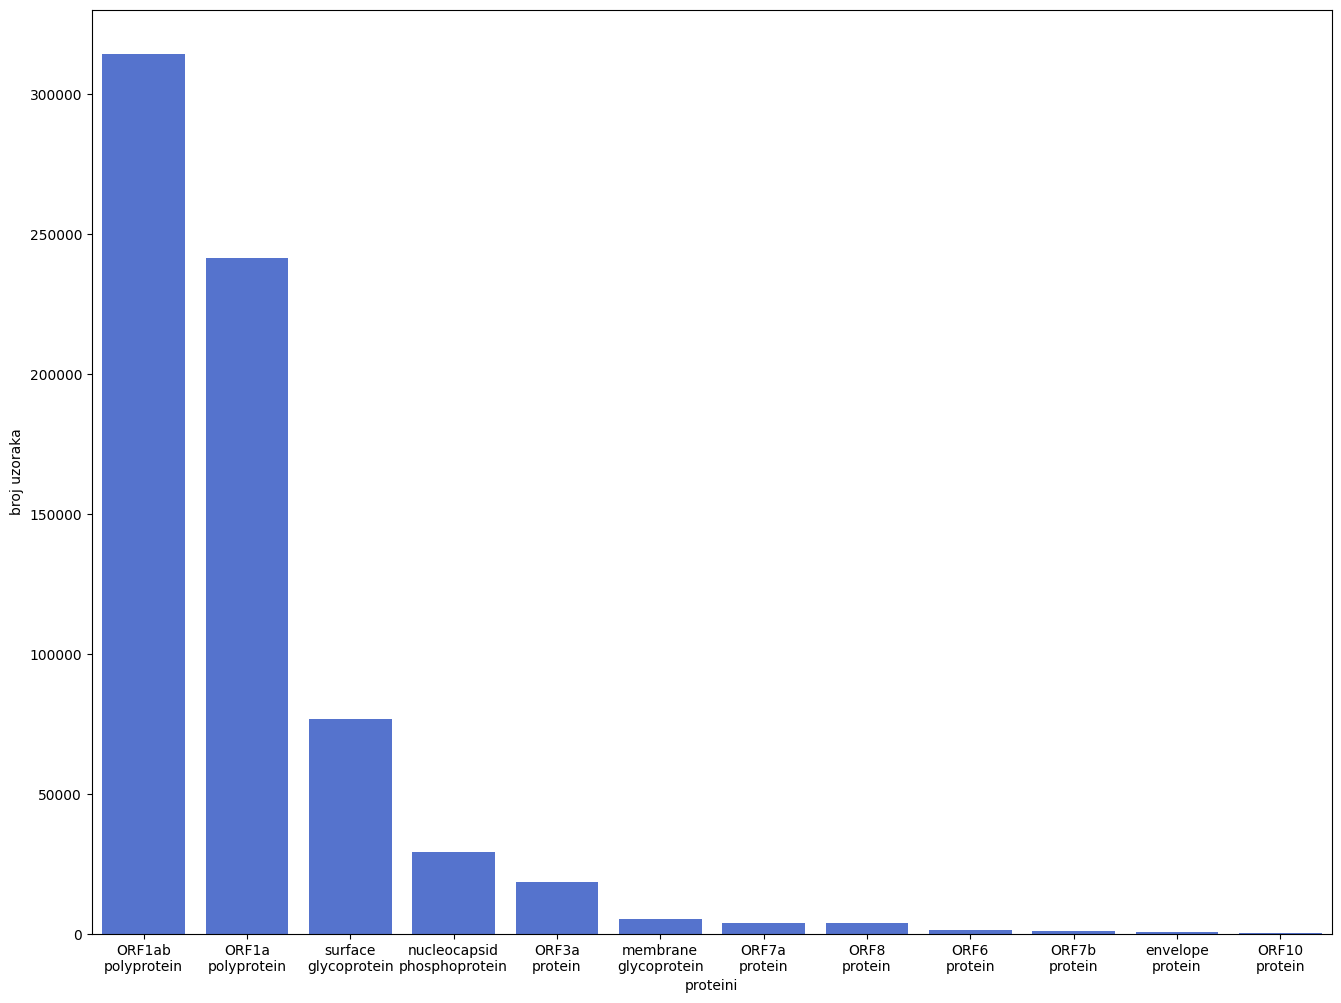

In [20]:
fig = px.bar(x=[a.replace(' ', '\n') for a in proteins.index],
             y=proteins[:],
             labels={'x': 'proteins',
                     'y': 'samples'},
             text_auto=True,
             title='Class Balance')

fig.show()

### Feature-Target Correlation

In [ ]:
ftc = X_train.corrwith(y_train)

In [ ]:
fig = px.bar(x=ftc.index,
             y=ftc,
             labels={'x': 'codons',
                     'y': 'correlation with protein type'},
             text_auto=True,
             orientation='h',
             title='Feature-Target Correlation')

fig.show()

### Radar Charts

In [ ]:
df_train = X_train.join(y_train, validate='one_to_one')
df_max = df_train.groupby('Protein').max()
df_min = df_train.groupby('Protein').min()

In [ ]:
fig = go.Figure()

### Parallel Coordinates

In [ ]:
fig = px.parallel_coordinates(X_train,
                              color=y_train,
                              color_continuous_scale=px.colors.sequential.Jet,
                              title='Parallel Coordinates')

fig.show()

### t-SNE

Stohastičko umetanje suseda sa t-raspodelim, kraće t-SNE, je nelinearni algoritam za dimenzionu redukciju.
Važna osobina algoritma je da čuva relativna rastojanja, tako da slične podatke sa velikom verovatnoćom projektuje u tačke koje se nalaze međusobno blizu, a različite podatke daleko.
Na žalost, zbog svoje stohastičke prirode, ovaj algoritam je pogodan samo za vizualizaciju podataka.

Preporučeno je da za parametar *perplexity* biramo vrednosti između 5 i 50.
Manje vrednosti previše naglašavaju lokalne strukture u podacima, dok veće vrednosti naglašavaju globalne strukture.
Pored toga, da bi algoritam konvergirao, neophodno je da dozvolimo veliki broj iteracija.
Zbog visoke dimenzionalnosti podataka biramo *Menhetn* rastojanje.

In [21]:
tsne = TSNE(n_components=2,
            perplexity=50,
            exaggeration=4,
            n_iter=10000,
            early_exaggeration_iter=1000,
            n_jobs=-1, metric='manhattan',
            learning_rate='auto',
            initialization='random',
            random_state=seed)

X_train_tsne = tsne.fit(X_train.to_numpy())

Klase se izdvajaju bez preklapanja, što je ohrabrujući rezultat i obećava dobru klasifikaciju.

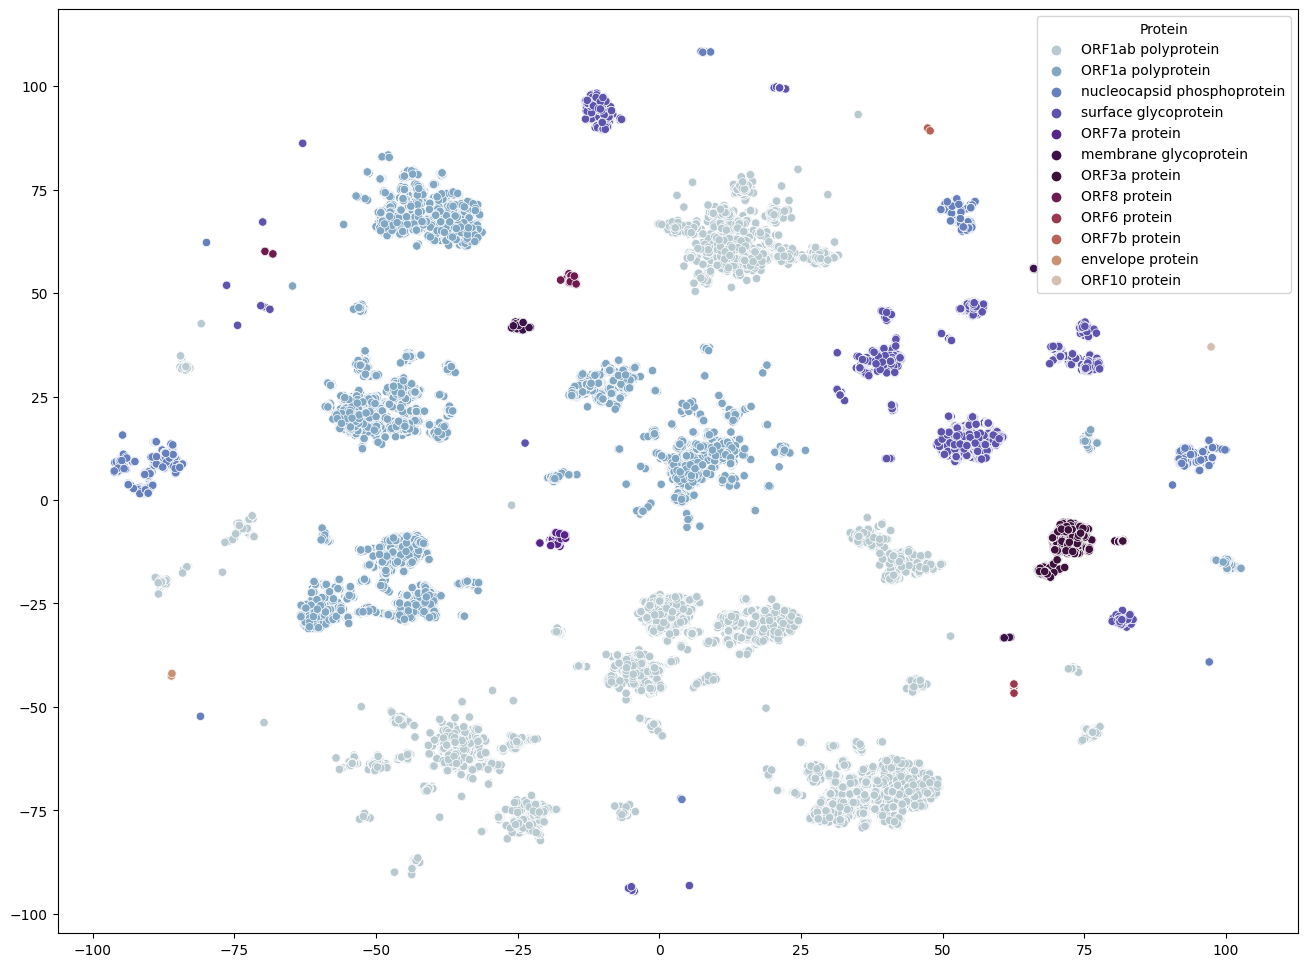

In [22]:
fig = px.scatter(x=X_train_tsne[:, 0],
                 y=X_train_tsne[:, 1],
                 color=y_train,
                 color_continuous_scale=px.colors.sequential.Jet,
                 labels={'x': '', 'y': ''},
                 title='t-SNE')

fig.show()

## Treniranje i evaluacija modela

Za izbor modela koristićemo unakrsnu proveru sa iscrpnom pretragom.

Za sve algoritme, u unakrsnoj proveri ćemo koristiti metriku balansirane tačnosti.

Za evaluaciju modela na trening i test skupovima posmatraćemo izvaštaj sa merama preciznosti, odziva i f1 merom, normalizovane matrice konfuzije i važnost atributa za cele skupove i za pojedinačne klase.

In [23]:
protein_labels = proteins.index
labels2display = np.array([a.split(' ', 1)[0] for a in protein_labels])

In [24]:
def plot_feature_importances(clf, X, y, protein, n_repeats=8, n_jobs=1):
    if X.shape[0] > 0:
        imp_vals = permutation_importance(clf, X, y,
                                          scoring='balanced_accuracy',
                                          n_repeats=n_repeats,
                                          n_jobs=n_jobs,
                                          random_state=seed)
        df_pi = pd.DataFrame({'feature_name': X.columns, 'feature_importance': imp_vals.importances_mean})
        plt.figure(figsize=(16, 4))
        # ax = sns.barplot(df_fi.sort_values(by=['feature_importance'], ascending=False)
        #                  .head(),
        #                  x='feature_importance', y='feature_name') # opadajuce sortirani atributi
        ax = sns.barplot(df_pi.reindex(df_pi['feature_importance'].abs()
                                       .sort_values(ascending=False)
                                       .index).head(4),
                         x='feature_importance', y='feature_name')  # apsolutno opadajuce sortirani atributi
        ax.set(xlabel='znacaj atributa', ylabel='atribut')
        plt.title(protein)
        plt.show()

### Komplementarni naivni Bajesov algoritam

Komplementarna varijacija algoritma računa verovatnoću da instanca ne pripada klasi i dodeljuje je onoj klasi sa najmanjom izračunatom verovatnoćom nepripadnosti.

U *scikit-learn* implementaciji je ugrađen i algoriam za aditivno uglađivanje podataka koji prima *alpha* parametar.

In [25]:
params = [{'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000, 10000]}]

In [26]:
clf = BayesSearchCV(ComplementNB(), params, scoring='balanced_accuracy', n_jobs=-1, cv=8)
_ = clf.fit(X_train, y_train)

Parametri najboljeg modela.

In [27]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

alpha
0.000010


Izveštaj za trening skup.

In [28]:
y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    0.00000   0.00000   0.00000       364
          ORF1a polyprotein    0.99994   1.00000   0.99997    241372
         ORF1ab polyprotein    0.99518   1.00000   0.99759    314439
              ORF3a protein    0.93516   1.00000   0.96649     18476
               ORF6 protein    0.00000   0.00000   0.00000      1098
              ORF7a protein    1.00000   0.87097   0.93103      3937
              ORF7b protein    0.00000   0.00000   0.00000       743
               ORF8 protein    1.00000   0.61159   0.75899      3831
           envelope protein    0.00000   0.00000   0.00000       658
      membrane glycoprotein    0.00000   0.00000   0.00000      5083
nucleocapsid phosphoprotein    0.82896   1.00000   0.90648     29103
       surface glycoprotein    0.98562   1.00000   0.99276     76782

                   accuracy                        0.98571    695886
                  macro avg    0

Matrica konfuzije za trening skup.

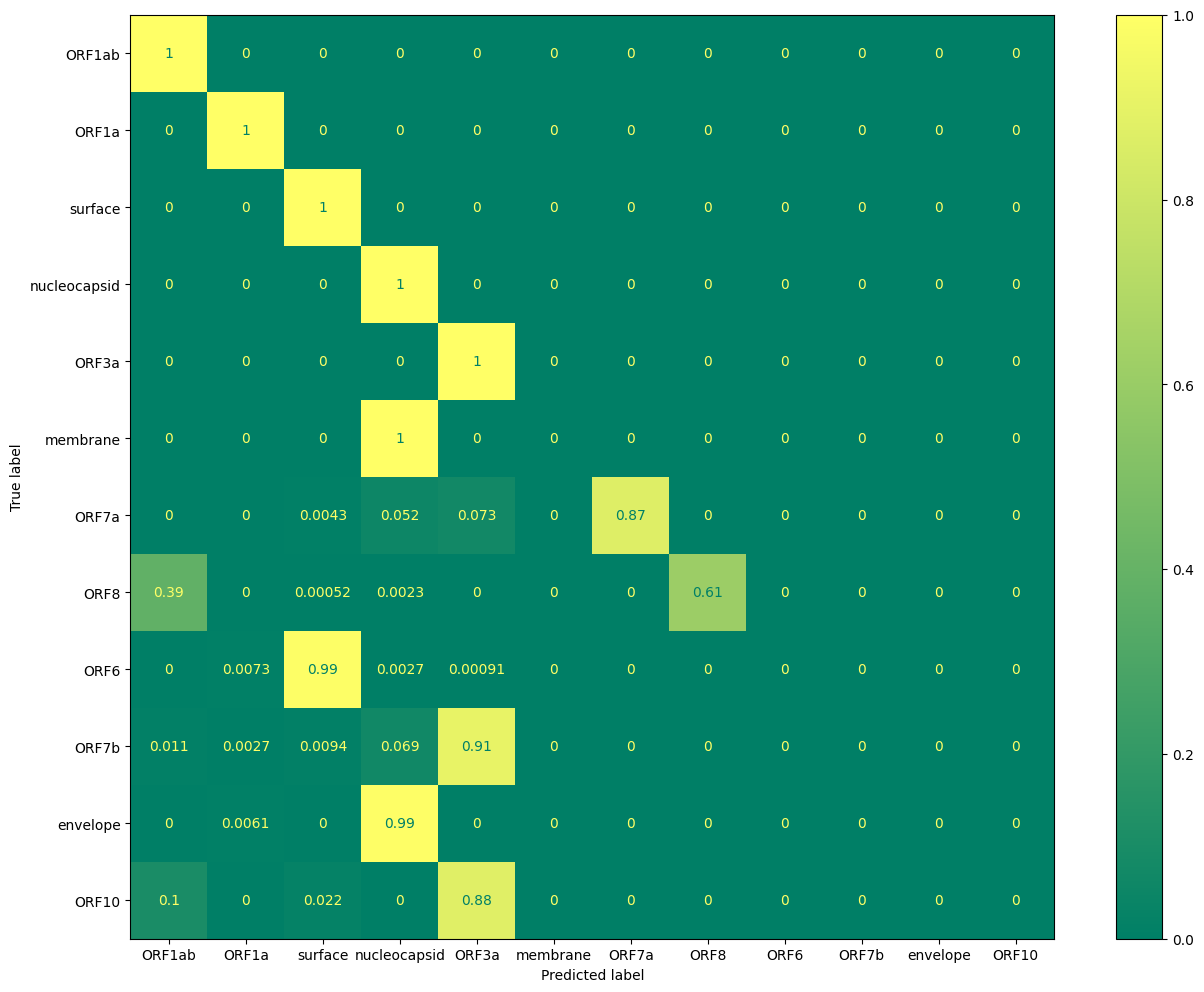

In [29]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

_, ax = plt.subplots(figsize=(16,12))

fig.plot(ax=ax, cmap='summer')
plt.show()

Izveštaj za test skup.

In [30]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    0.00000   0.00000   0.00000        91
          ORF1a polyprotein    0.99992   1.00000   0.99996     60343
         ORF1ab polyprotein    0.99485   1.00000   0.99742     78610
              ORF3a protein    0.93483   1.00000   0.96632      4619
               ORF6 protein    0.00000   0.00000   0.00000       274
              ORF7a protein    1.00000   0.86585   0.92810       984
              ORF7b protein    0.00000   0.00000   0.00000       186
               ORF8 protein    1.00000   0.58768   0.74030       958
           envelope protein    0.00000   0.00000   0.00000       164
      membrane glycoprotein    0.00000   0.00000   0.00000      1271
nucleocapsid phosphoprotein    0.82946   1.00000   0.90678      7276
       surface glycoprotein    0.98547   1.00000   0.99268     19196

                   accuracy                        0.98556    173972
                  macro avg    0

Matrica konfuzije za test skup.

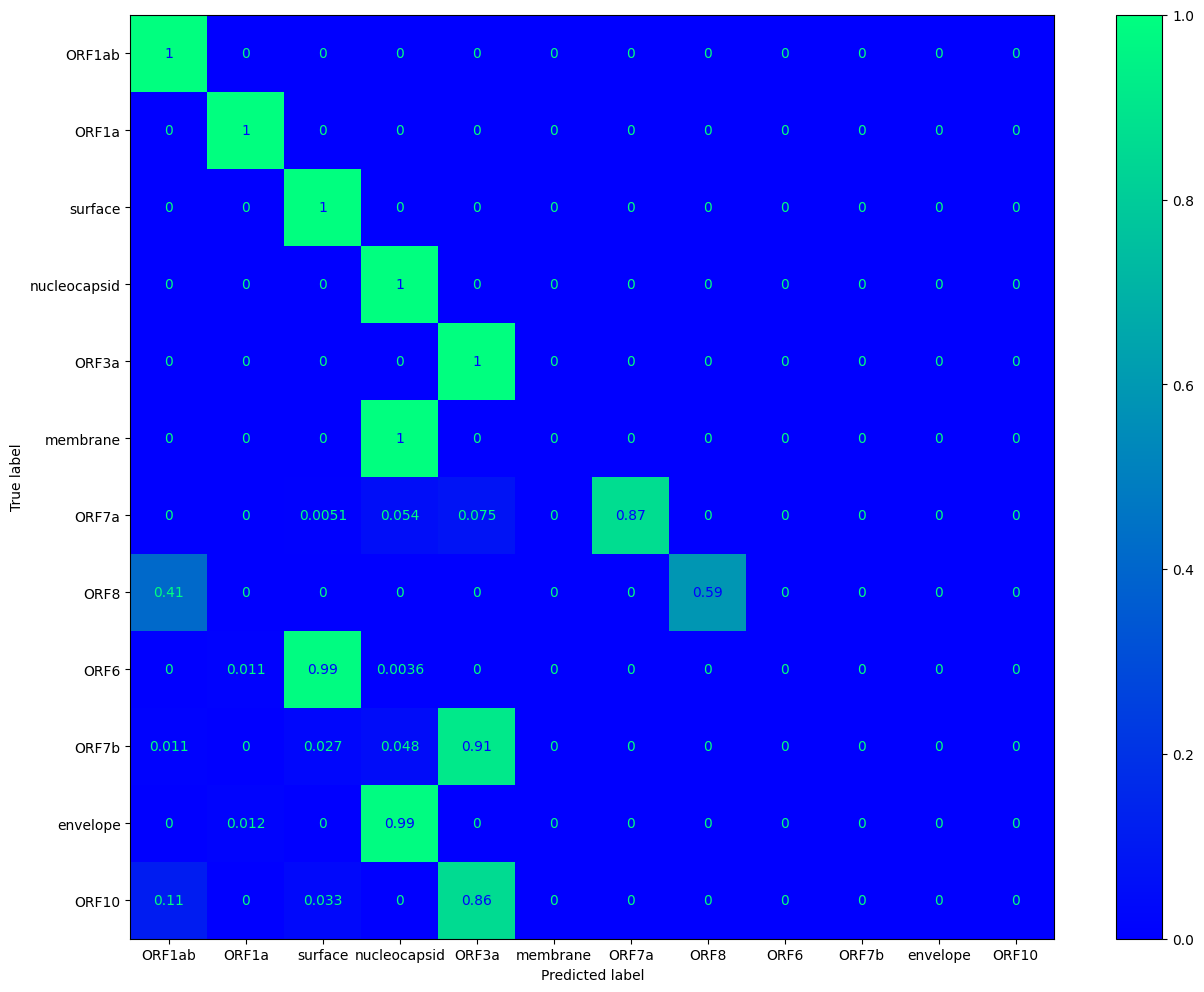

In [31]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

_, ax = plt.subplots(figsize=(16,12))

fig.plot(ax=ax, cmap='winter')
plt.show()

Važnost atributa za test skup.

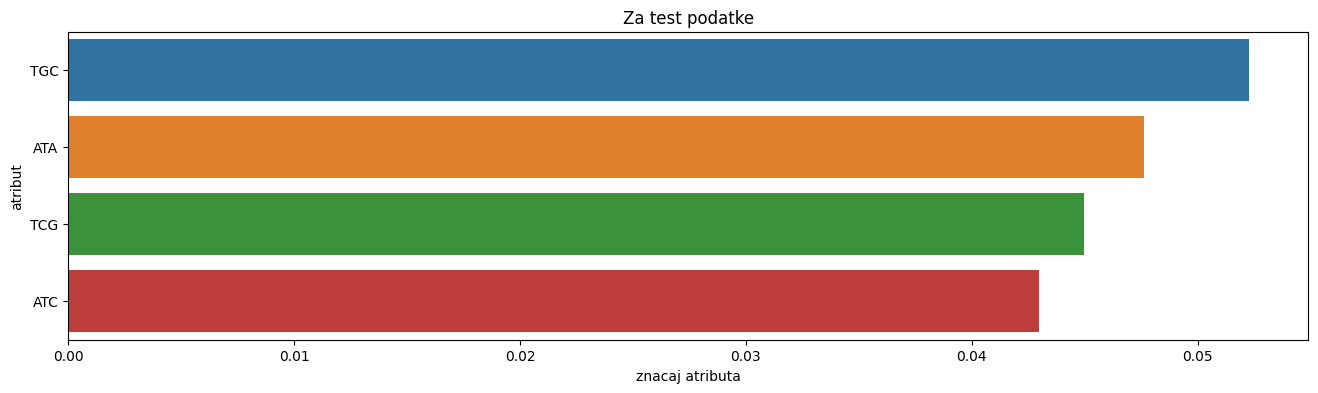

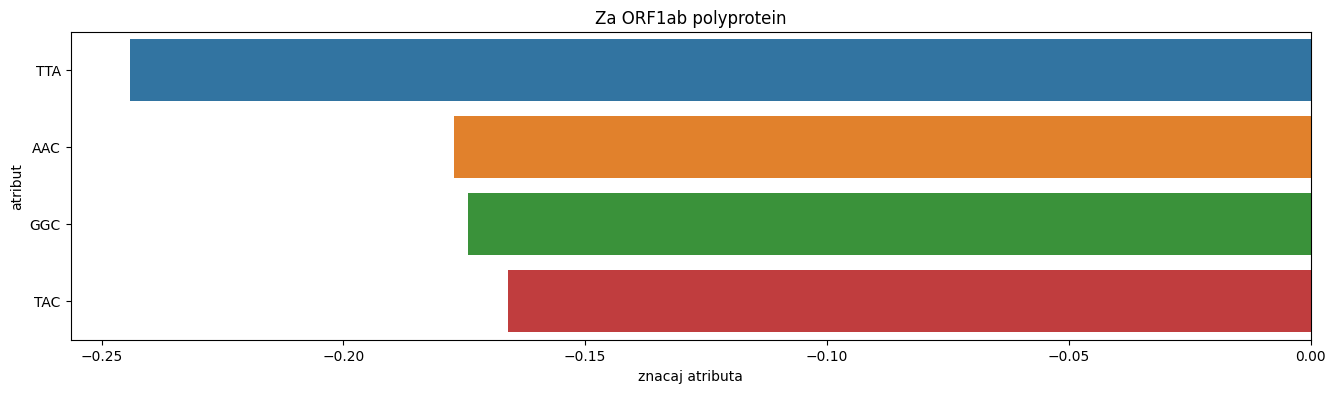

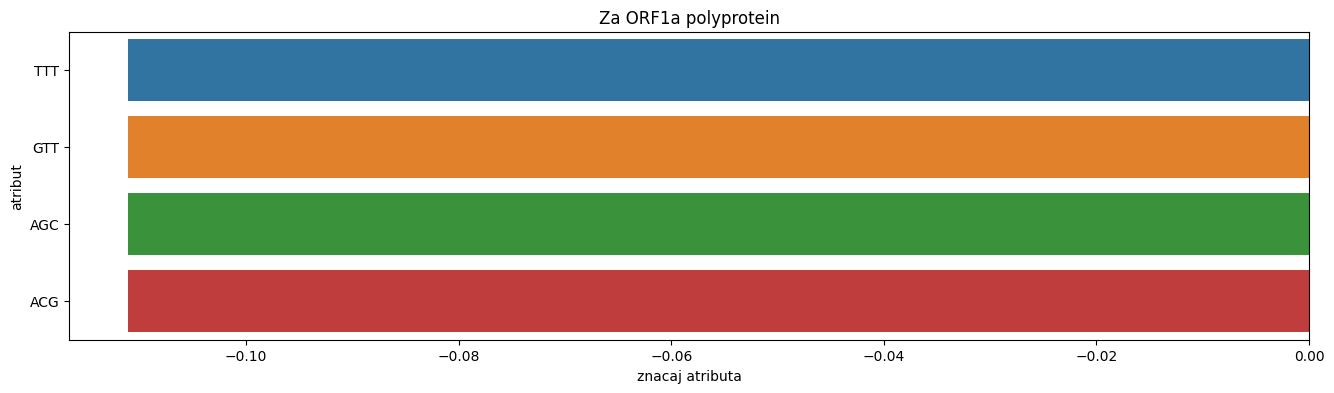

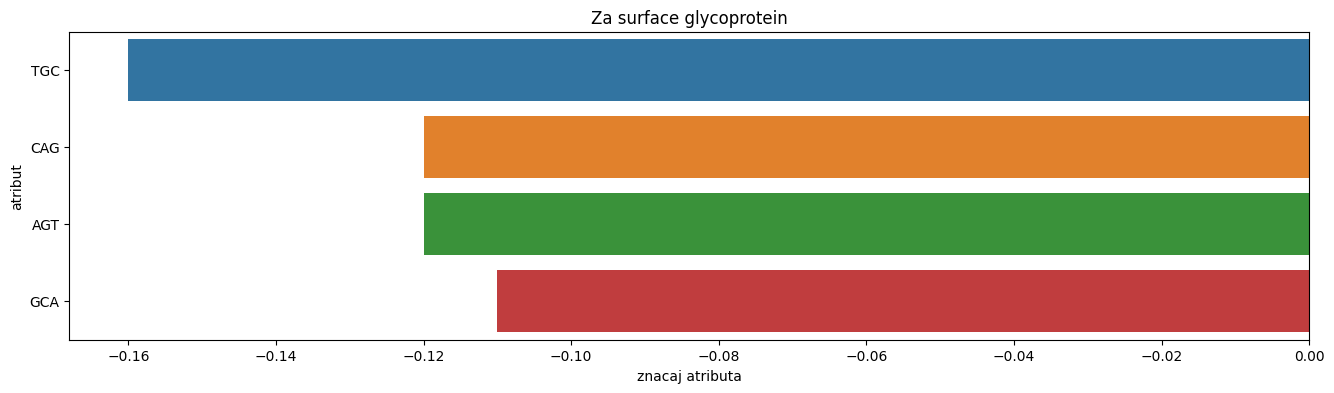

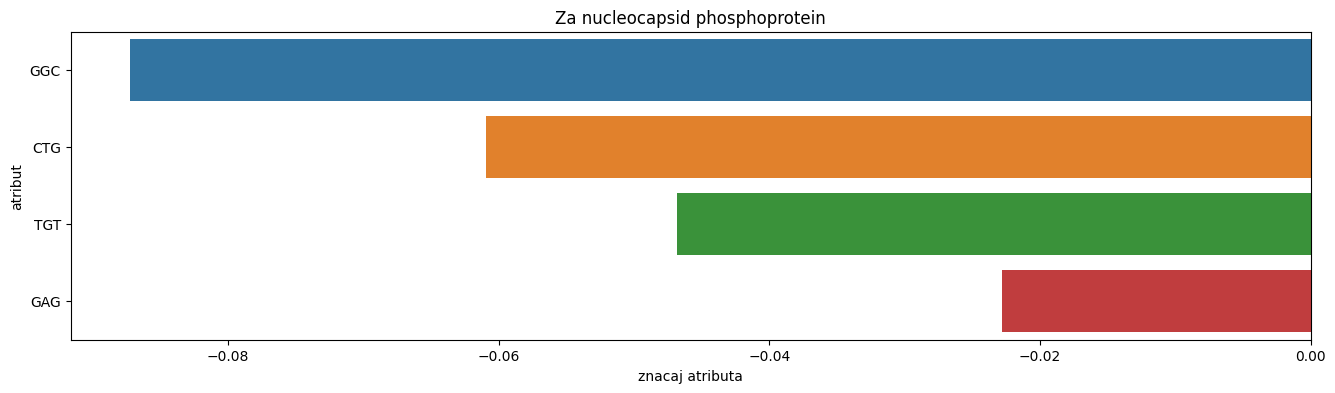

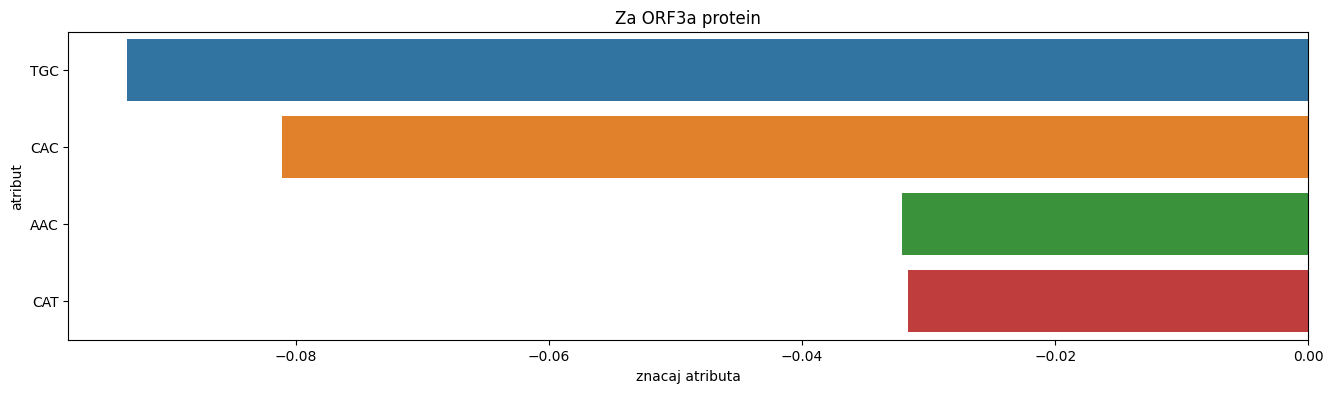

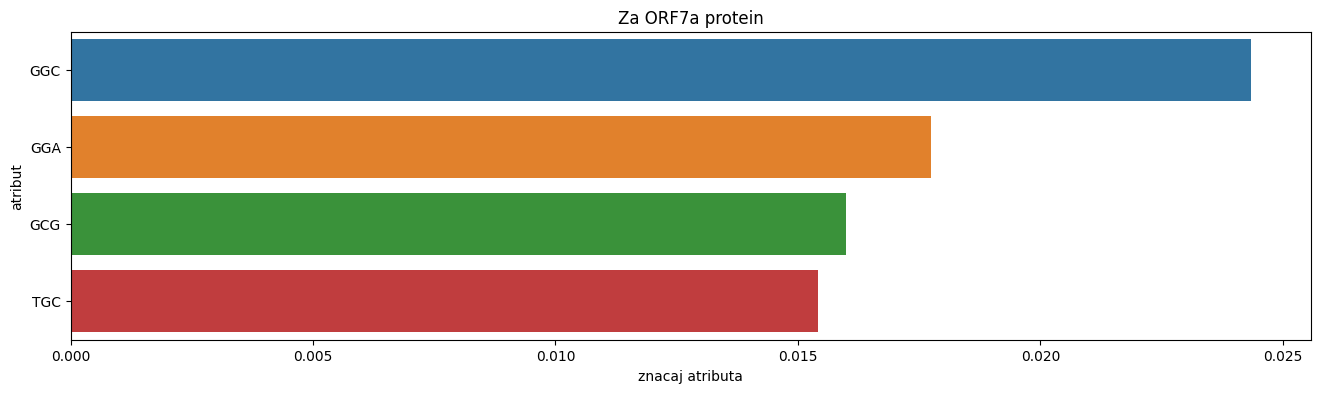

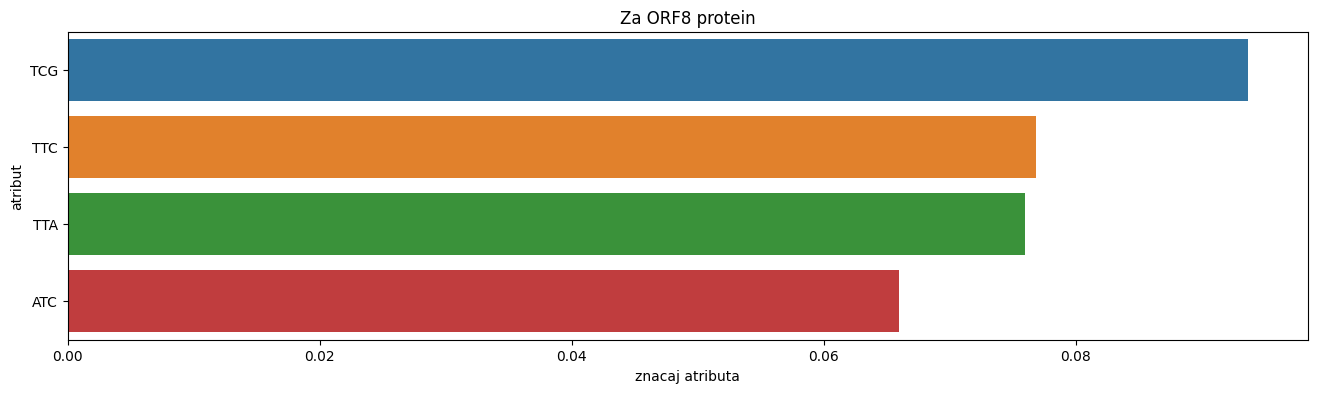

In [32]:
plot_feature_importances(clf, X_test, y_test,
                         'Za test podatke', n_jobs=-1)

for protein in protein_labels:
    plot_feature_importances(clf,
                             X_test[y_pred == protein],
                             y_test[y_pred == protein],
                             f'Za {protein}', n_jobs=-1)

### Drvo odlučivanja

Izabraćemo dva pristupa za unakrsnu proveru.
U jednom ćemo varirati parametre za maksimalnu dubinu drveta i minimalan broj uzoraka u čvoru za podelu i list.
U drugom pristupu umesto konstantnih ograničenja, koristićemo minimalno smanjenje nečistoće za podelu i potkresivanje.
U oba slučaja proveravaćemo da li ginijev indeks ili entropija daju bolje rezultate za informacionu dobit.

In [41]:
params = [{'criterion': ['gini', 'entropy'],
            'max_depth': [4, 8, 16, 32],
            'min_samples_split': [128, 256],
            'min_samples_leaf': [32, 64],
            'class_weight': ['balanced'],
            'random_state': [seed]},
          {'criterion': ['gini', 'entropy'],
            'min_impurity_decrease': [0.01, 0.02, 0.03, 0.04],
            'ccp_alpha': [0.01, 0.02, 0.03, 0.04],
            'class_weight': ['balanced'],
            'random_state': [seed]}]

In [42]:
clf = BayesSearchCV(DecisionTreeClassifier(), params, scoring='balanced_accuracy', n_jobs=-1, cv=5)
_ = clf.fit(X_train, y_train)

Parametri najboljeg modela.

In [43]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

class_weight,criterion,max_depth,min_samples_leaf,min_samples_split,random_state
balanced,gini,8,32,128,196883


Grafički prikaz drveta odlučivanja.

In [ ]:
viz_model = dtreeviz.model(clf.best_estimator_,
                           X_train=X_train,
                           y_train=y_train,
                           feature_names=X_train.columns.to_numpy(),
                           target_name='Proteins',
                           class_names=list(clf.best_estimator_.classes_))

In [ ]:
viz_model.view(leaftype='barh')

In [ ]:
viz_model.ctree_leaf_distributions(figsize=(16, 12))

Izveštaj za trening skup podataka.

In [45]:
y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000       364
          ORF1a polyprotein    1.00000   0.99987   0.99994    241372
         ORF1ab polyprotein    1.00000   1.00000   1.00000    314439
              ORF3a protein    0.99984   0.99989   0.99986     18476
               ORF6 protein    0.99909   0.99727   0.99818      1098
              ORF7a protein    0.99949   0.99721   0.99835      3937
              ORF7b protein    1.00000   0.99865   0.99933       743
               ORF8 protein    0.99662   1.00000   0.99831      3831
           envelope protein    0.99847   0.99392   0.99619       658
      membrane glycoprotein    0.99316   1.00000   0.99657      5083
nucleocapsid phosphoprotein    1.00000   0.99997   0.99998     29103
       surface glycoprotein    0.99997   0.99995   0.99996     76782

                   accuracy                        0.99992    695886
                  macro avg    0

Matrica konfuzije za trening skup podataka.

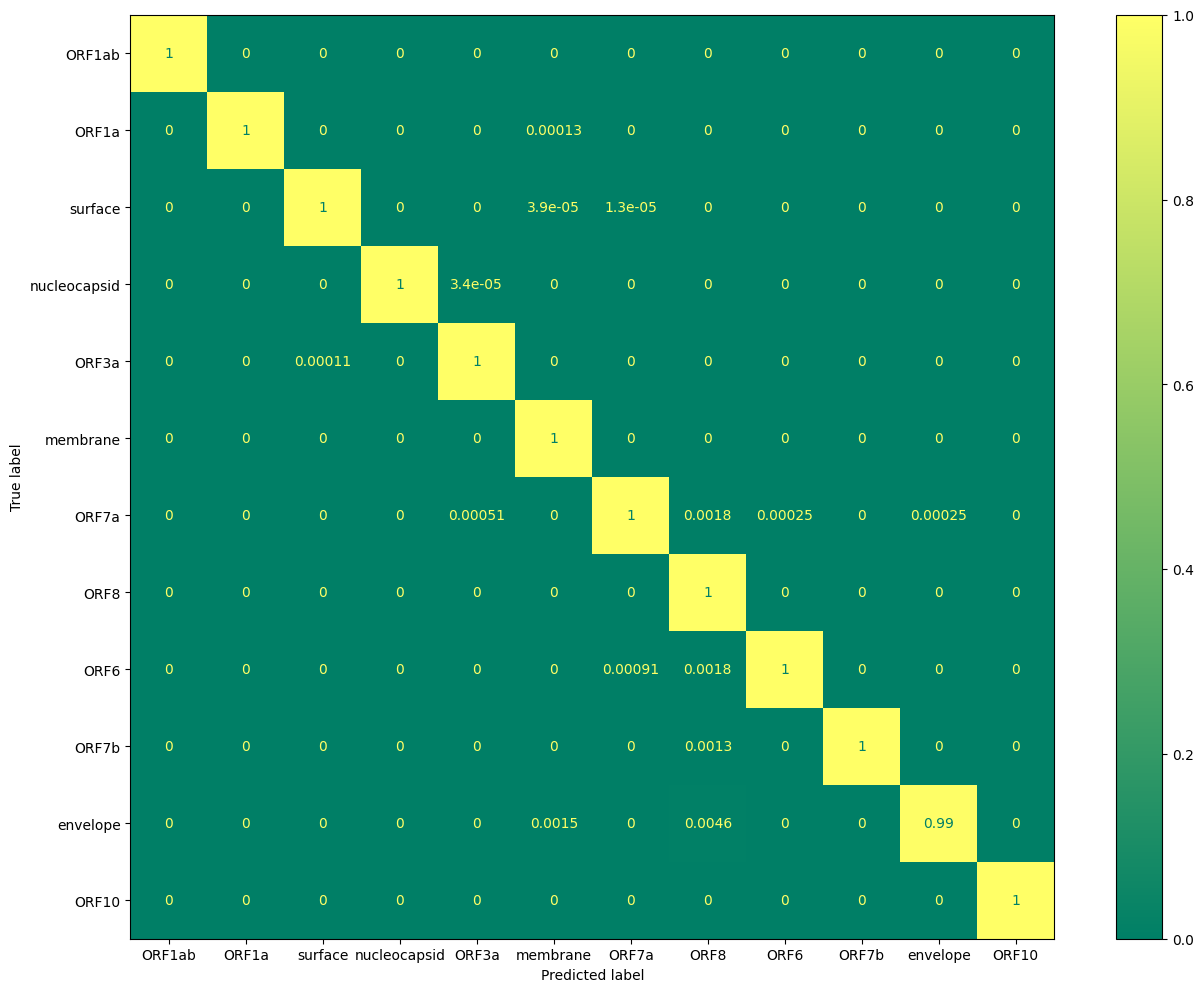

In [46]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

_, ax = plt.subplots(figsize=(16,12))

fig.plot(ax=ax, cmap='summer')
plt.show()

Izveštaj za test skup podataka.

In [47]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000        91
          ORF1a polyprotein    1.00000   0.99990   0.99995     60343
         ORF1ab polyprotein    1.00000   1.00000   1.00000     78610
              ORF3a protein    0.99935   1.00000   0.99968      4619
               ORF6 protein    0.99636   1.00000   0.99818       274
              ORF7a protein    0.99898   0.99492   0.99695       984
              ORF7b protein    0.99465   1.00000   0.99732       186
               ORF8 protein    0.99687   0.99896   0.99791       958
           envelope protein    1.00000   0.98780   0.99387       164
      membrane glycoprotein    0.99530   1.00000   0.99765      1271
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000      7276
       surface glycoprotein    1.00000   0.99995   0.99997     19196

                   accuracy                        0.99991    173972
                  macro avg    0

Matrica konfuzije za test skup podataka.

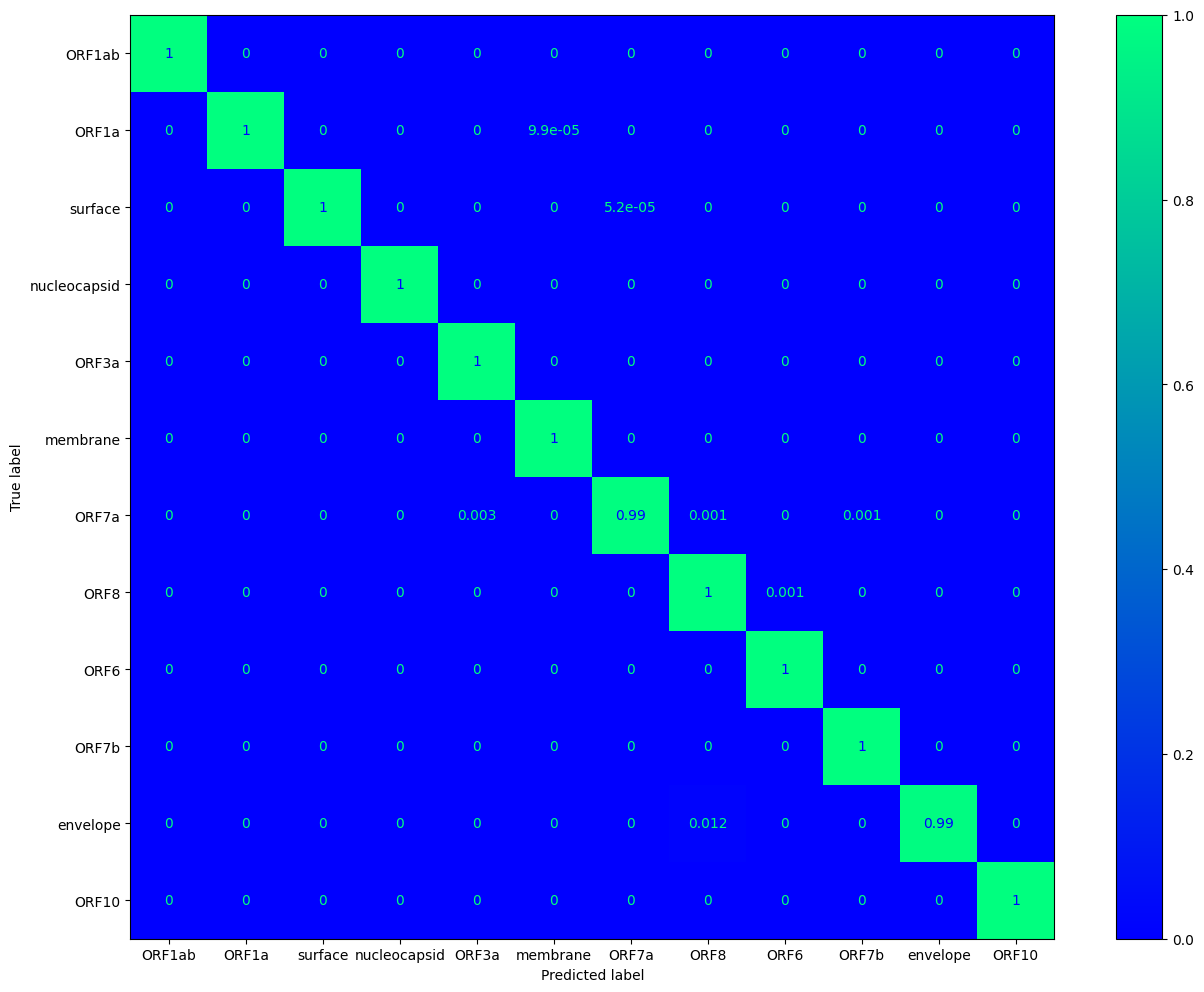

In [48]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

_, ax = plt.subplots(figsize=(16,12))

fig.plot(ax=ax, cmap='winter')
plt.show()

Važnost atributa za test skup podataka.

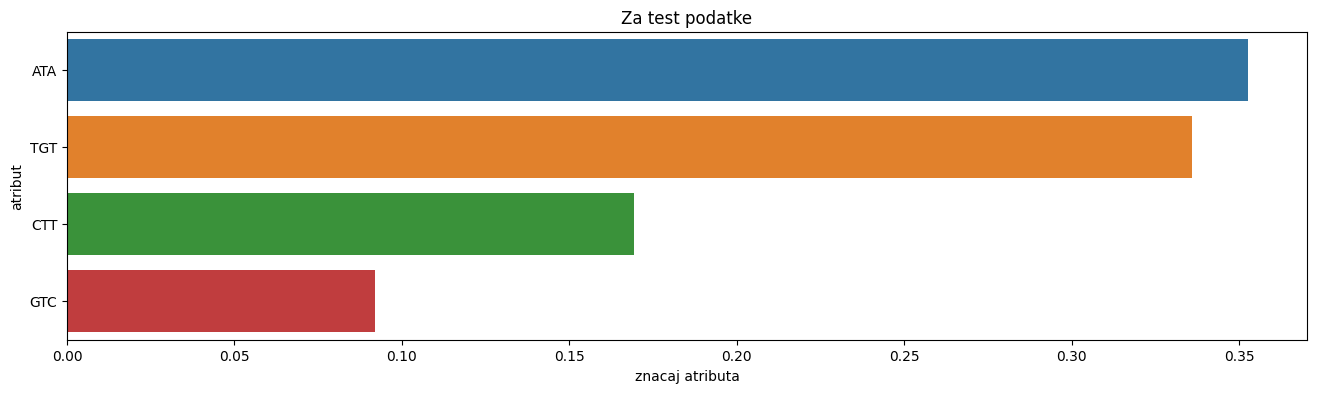

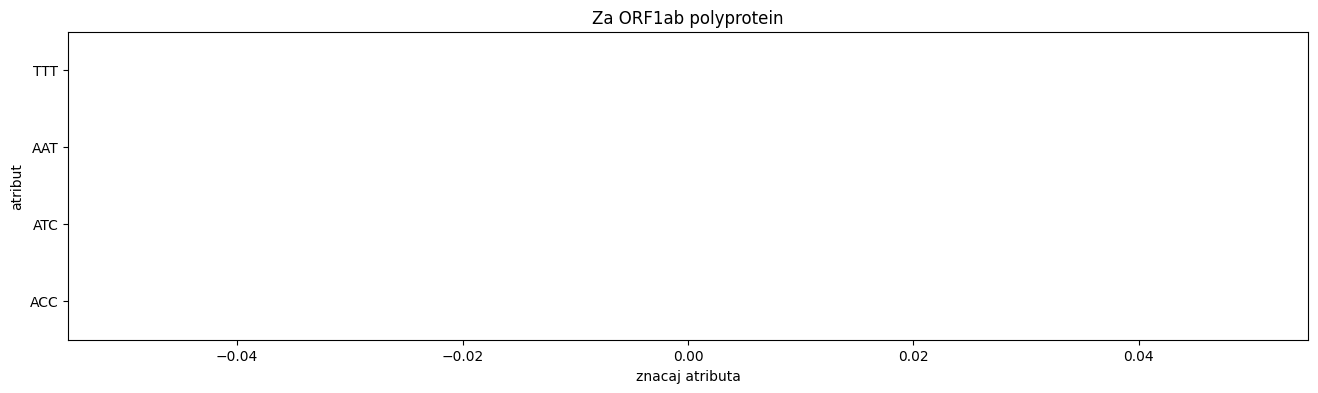

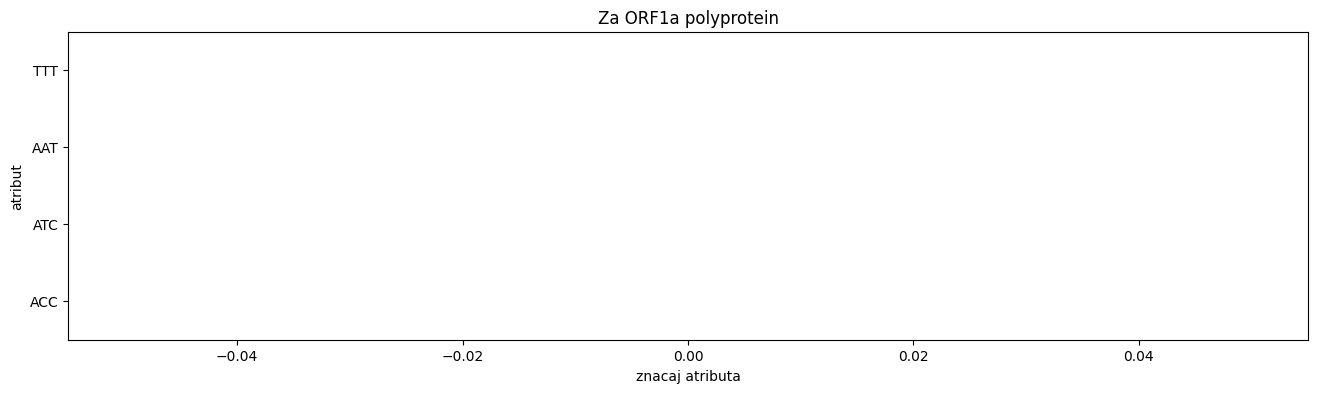

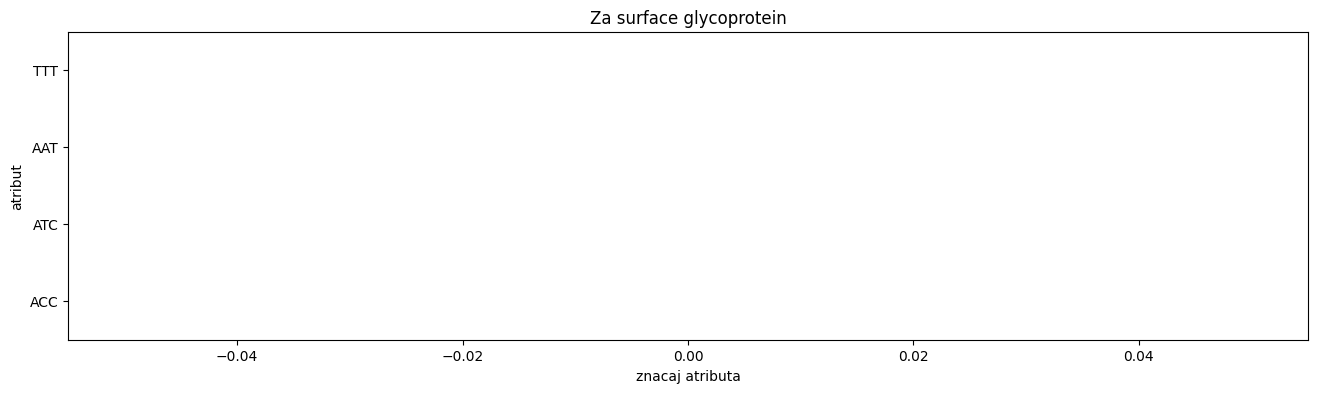

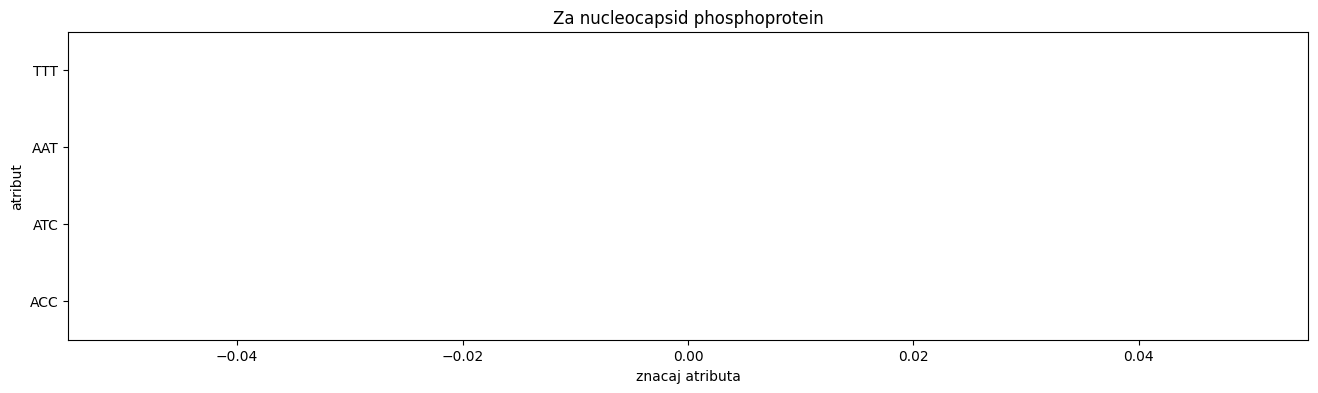

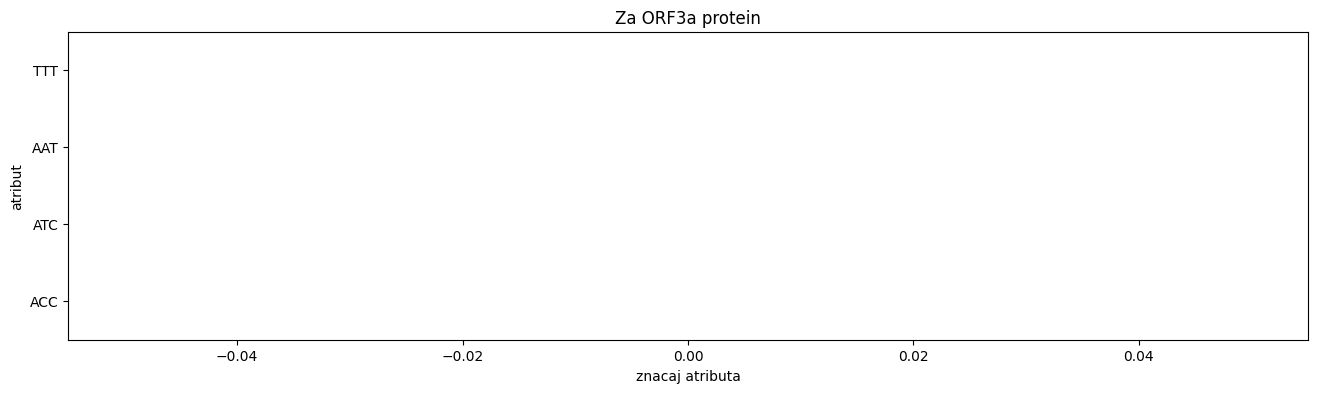

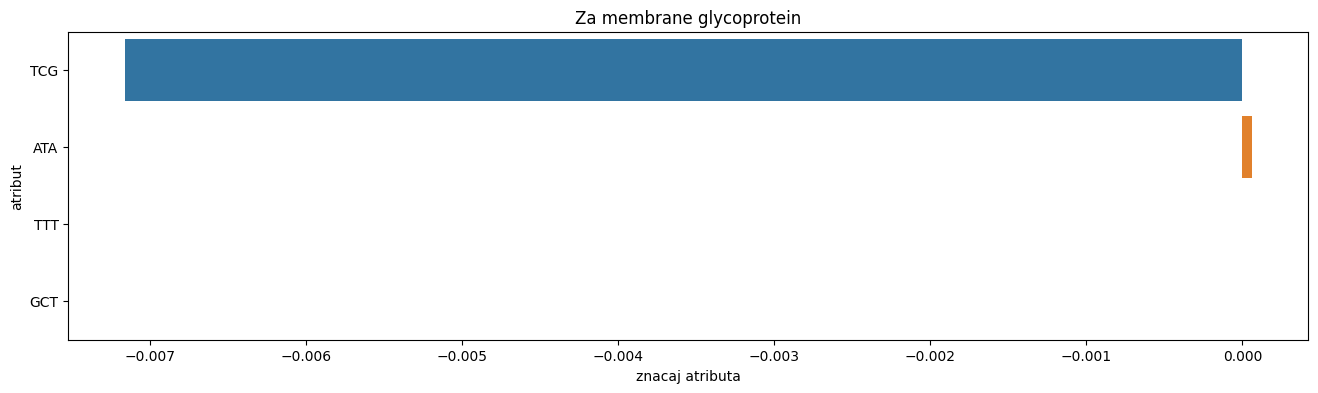

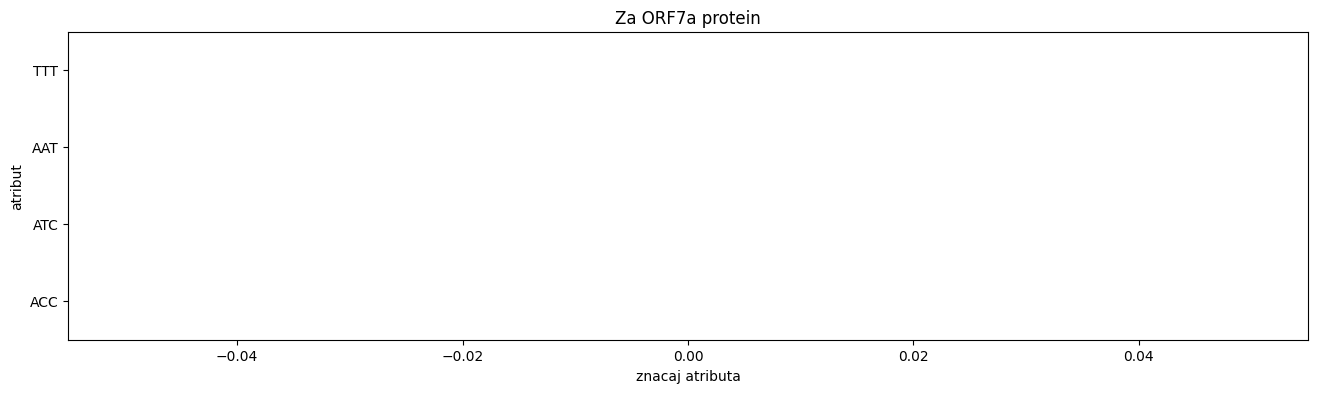

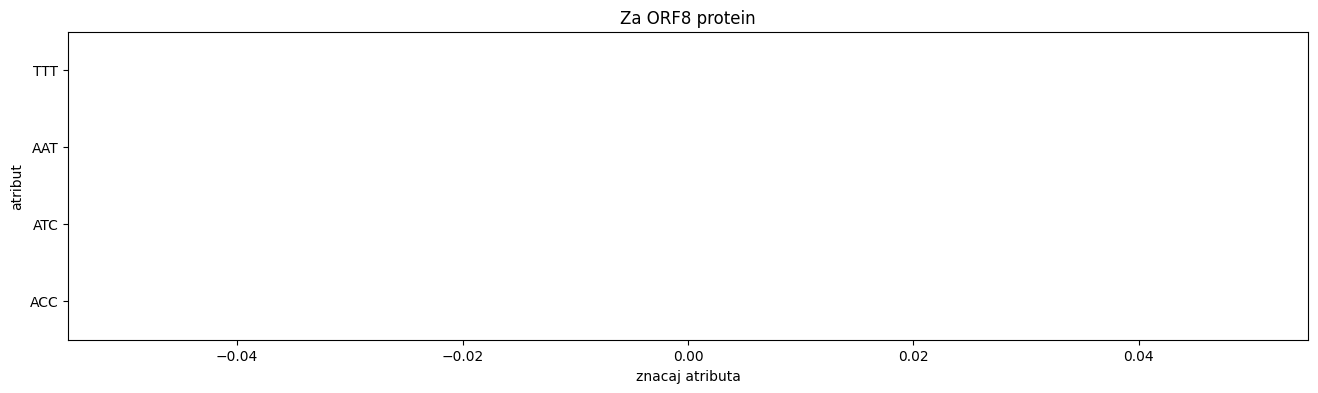

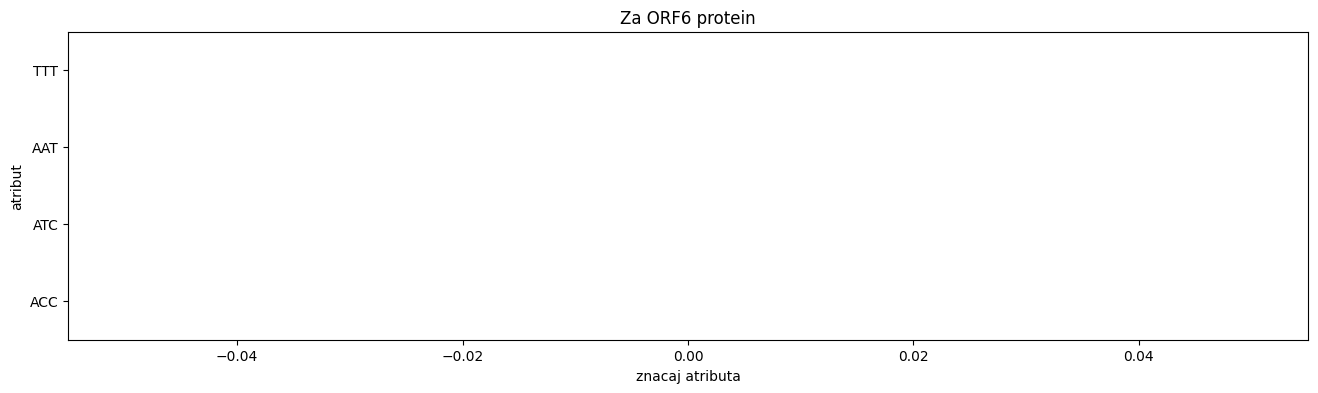

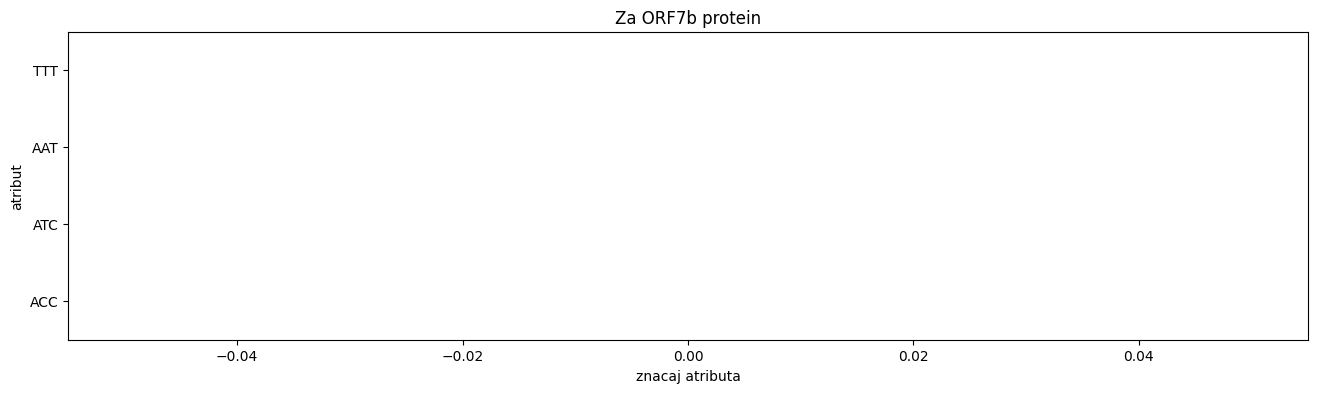

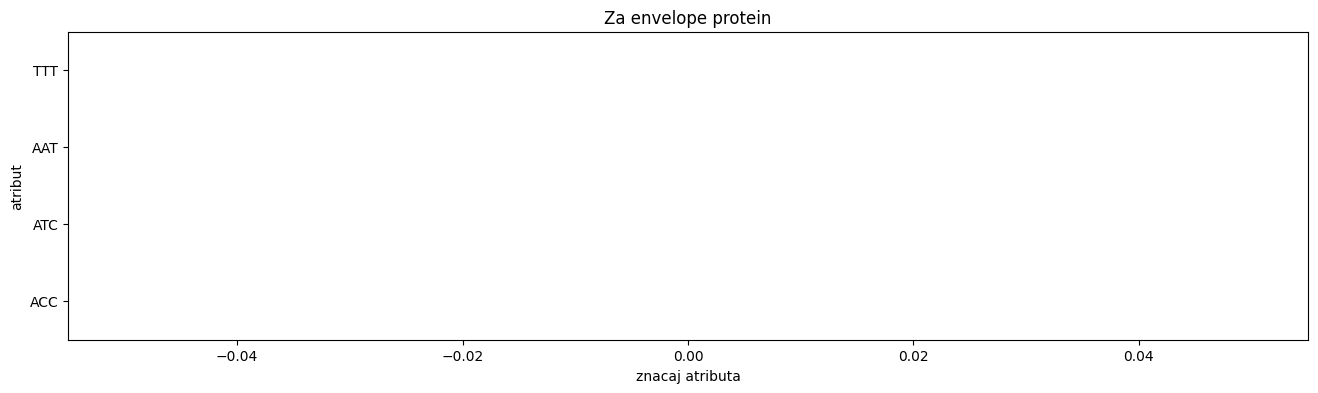

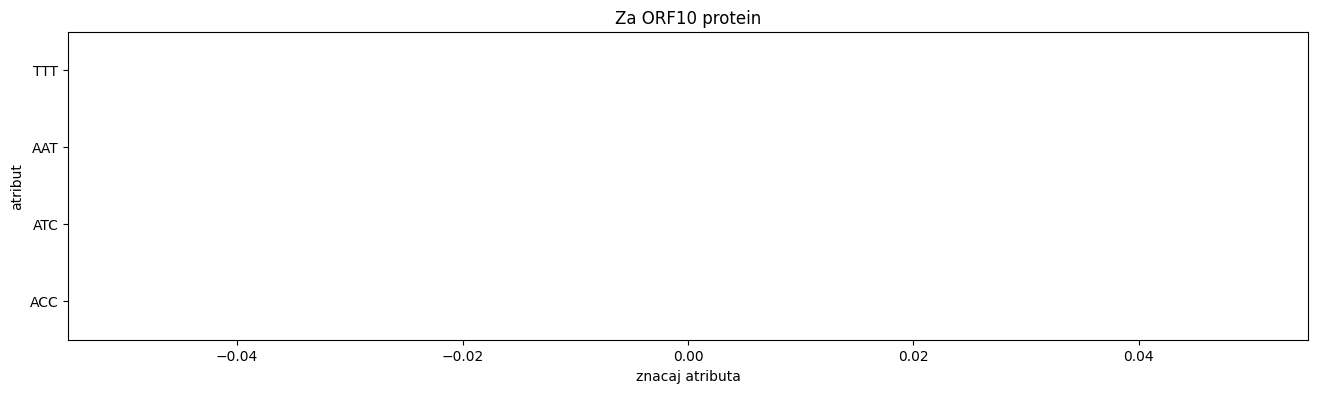

In [49]:
plot_feature_importances(clf, X_test, y_test,
                         'Za test podatke',
                         n_repeats=128, n_jobs=-1)

for protein in protein_labels:
    plot_feature_importances(clf,
                             X_test[y_pred == protein],
                             y_test[y_pred == protein],
                             f'Za {protein}',
                             n_repeats=128, n_jobs=-1)

### Nasumična šuma

Unakrsnom proverom ćemo testirati modele sa različitim brojem klasifikatora i najvećim dozvoljenim brojevima atributa i instanci u uzorcima.
Pustićemo da se stabla preprilagode.

In [50]:
params = [{'n_estimators': [32, 64, 128, 256],
           'criterion': ['entropy'],
           'max_features': [0.4, 0.6],
           'max_samples': [0.4, 0.6],
           'n_jobs': [-1],
           'random_state': [seed]}]

In [51]:
clf = BayesSearchCV(RandomForestClassifier(), params, scoring='balanced_accuracy', n_jobs=2, cv=5)
_ = clf.fit(X_train, y_train)

Parametri najboljeg modela.

In [52]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

criterion,max_features,max_samples,n_estimators,n_jobs,random_state
entropy,0.400000,0.400000,128,-1,196883


Izveštaj za trening skup podataka.

In [53]:
y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000       364
          ORF1a polyprotein    1.00000   1.00000   1.00000    241372
         ORF1ab polyprotein    1.00000   1.00000   1.00000    314439
              ORF3a protein    1.00000   1.00000   1.00000     18476
               ORF6 protein    1.00000   1.00000   1.00000      1098
              ORF7a protein    1.00000   1.00000   1.00000      3937
              ORF7b protein    1.00000   1.00000   1.00000       743
               ORF8 protein    1.00000   1.00000   1.00000      3831
           envelope protein    1.00000   1.00000   1.00000       658
      membrane glycoprotein    1.00000   1.00000   1.00000      5083
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000     29103
       surface glycoprotein    1.00000   1.00000   1.00000     76782

                   accuracy                        1.00000    695886
                  macro avg    1

Matrica konfuzije za trening skup podataka.

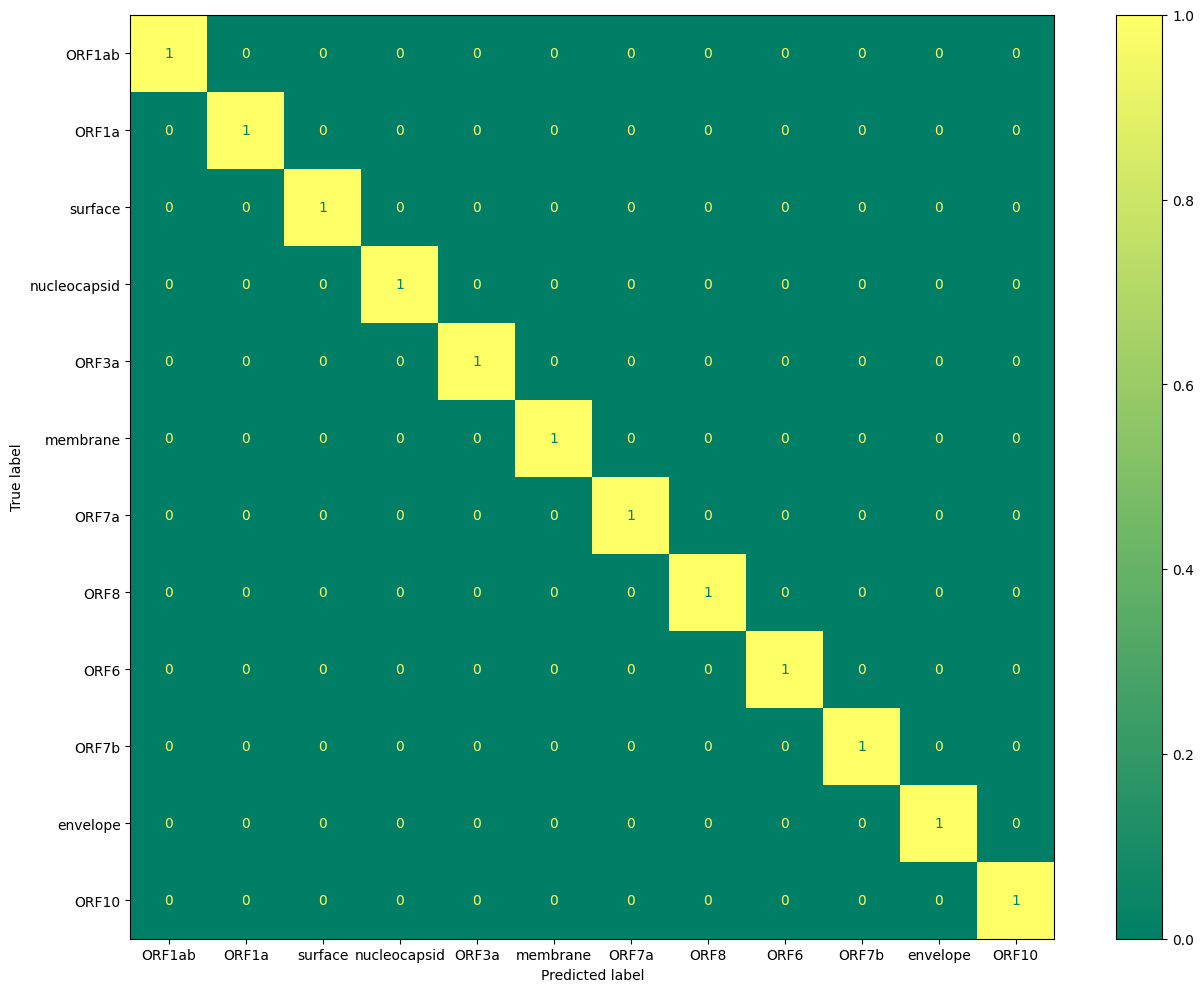

In [54]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

_, ax = plt.subplots(figsize=(16,12))

fig.plot(ax=ax, cmap='summer')
plt.show()

Izveštaj za test skup podataka.

In [55]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000        91
          ORF1a polyprotein    1.00000   1.00000   1.00000     60343
         ORF1ab polyprotein    1.00000   1.00000   1.00000     78610
              ORF3a protein    1.00000   1.00000   1.00000      4619
               ORF6 protein    1.00000   1.00000   1.00000       274
              ORF7a protein    1.00000   1.00000   1.00000       984
              ORF7b protein    1.00000   1.00000   1.00000       186
               ORF8 protein    1.00000   1.00000   1.00000       958
           envelope protein    1.00000   1.00000   1.00000       164
      membrane glycoprotein    1.00000   1.00000   1.00000      1271
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000      7276
       surface glycoprotein    1.00000   1.00000   1.00000     19196

                   accuracy                        1.00000    173972
                  macro avg    1

Matrica konfuzije za test skup podataka.

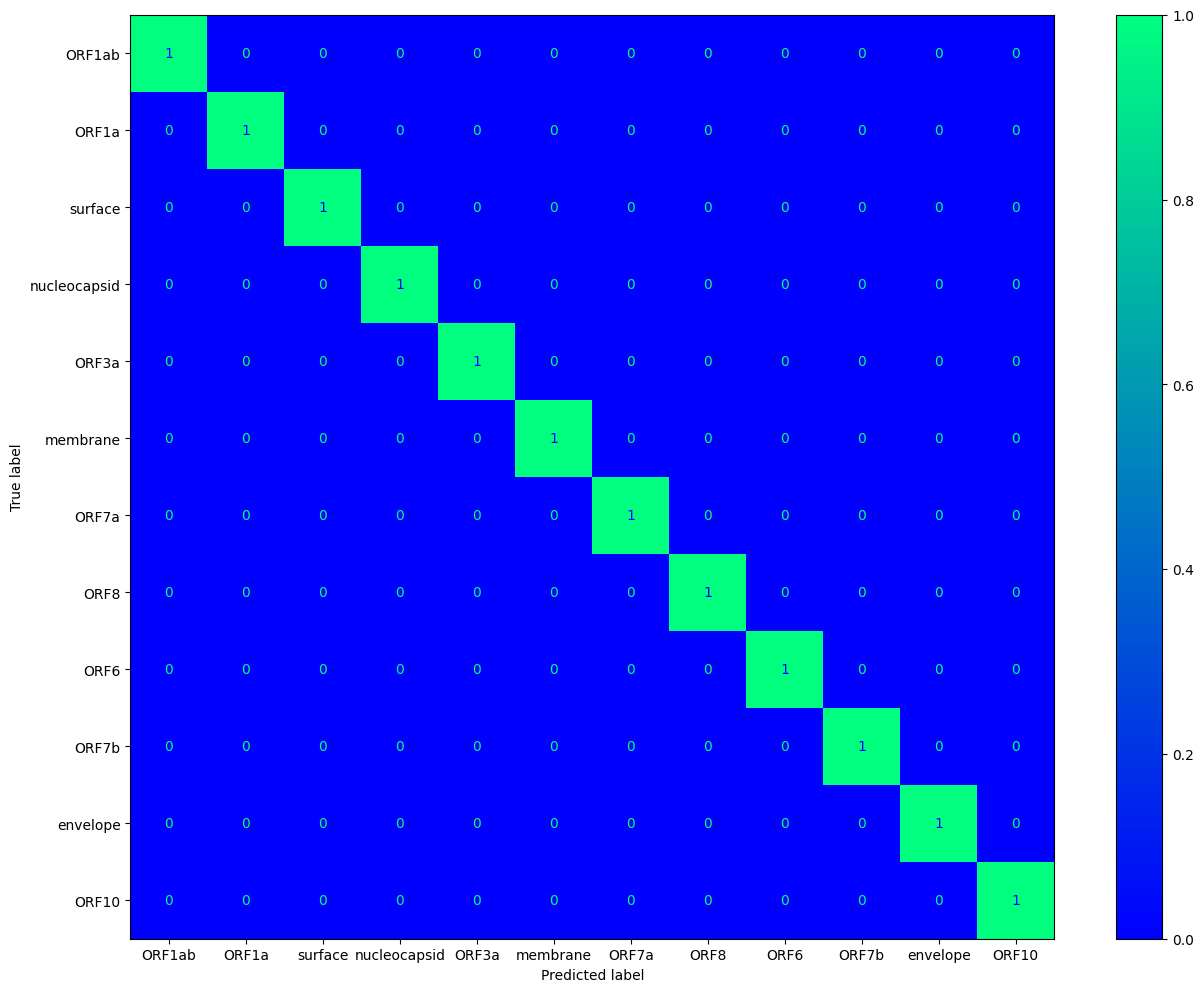

In [56]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

_, ax = plt.subplots(figsize=(16,12))

fig.plot(ax=ax, cmap='winter')
plt.show()

Važnost atributa za test skup podataka.

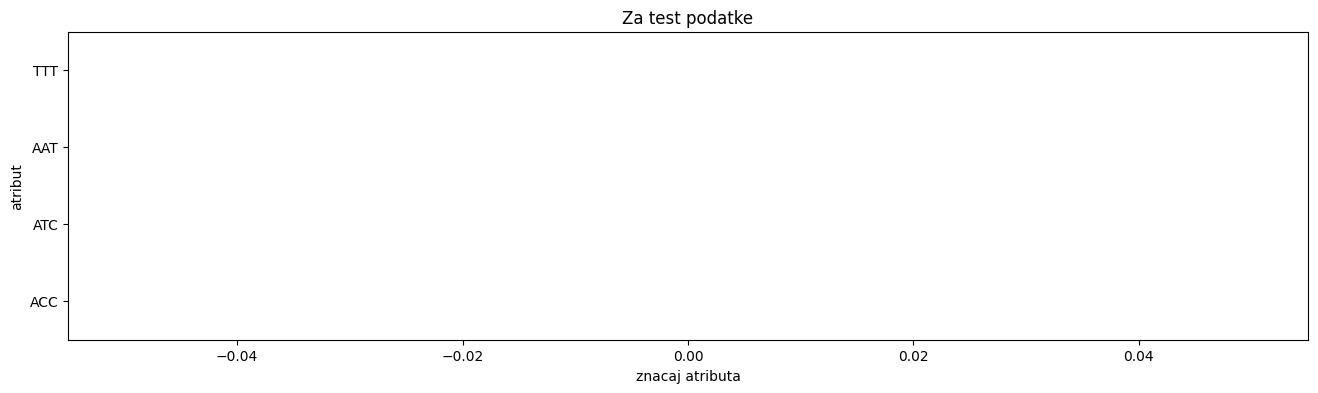

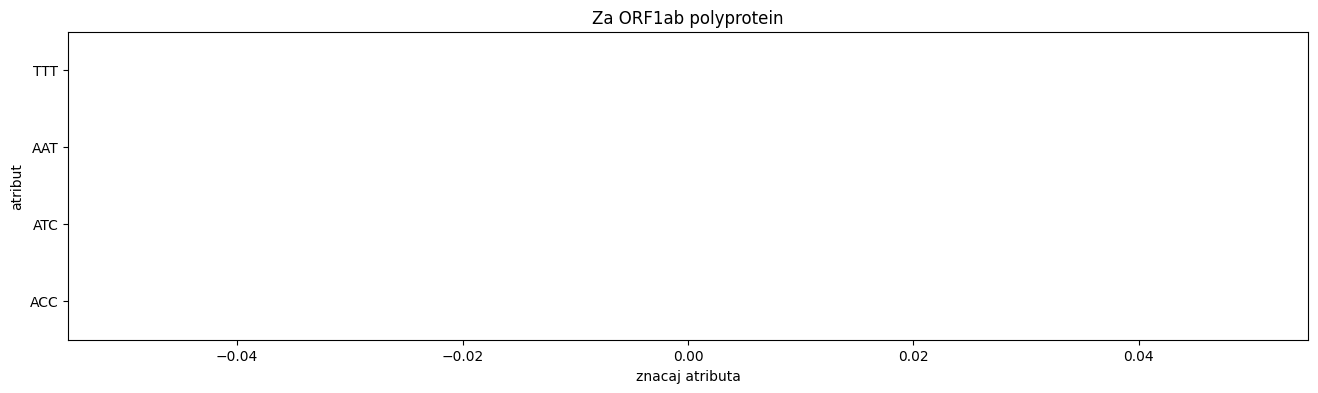

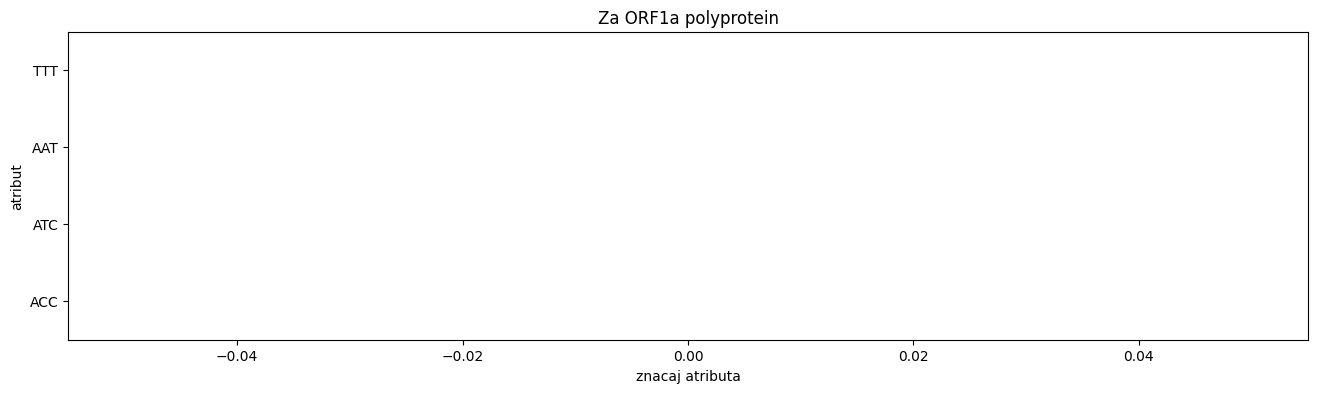

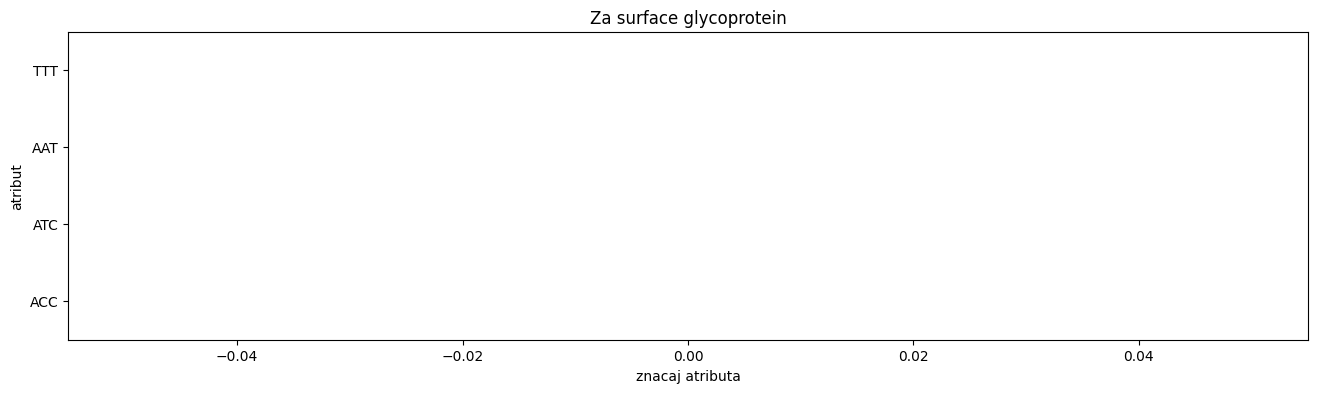

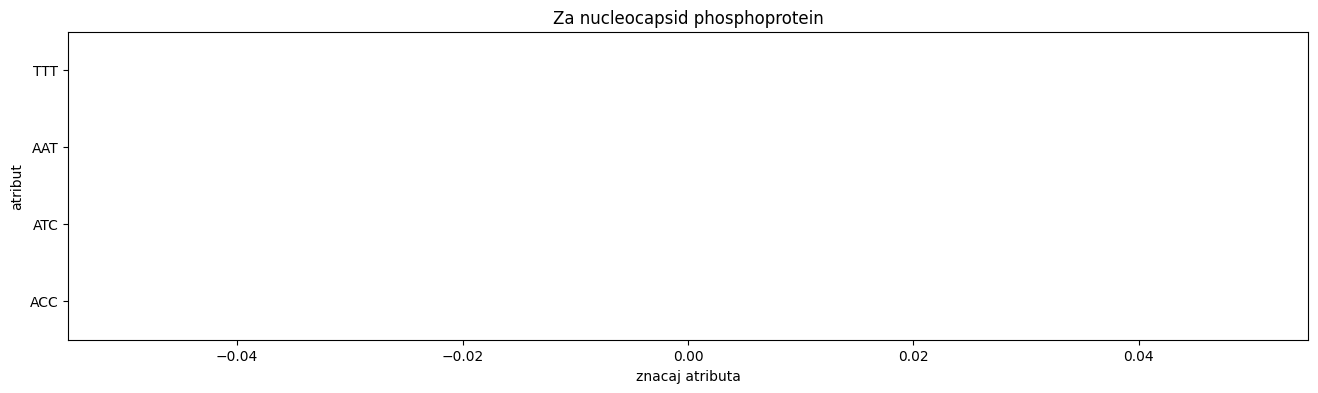

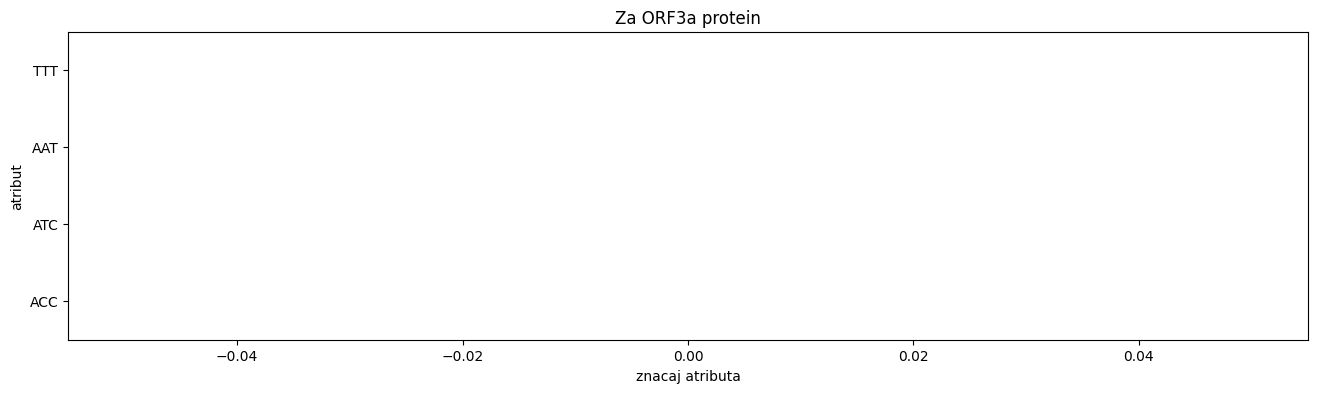

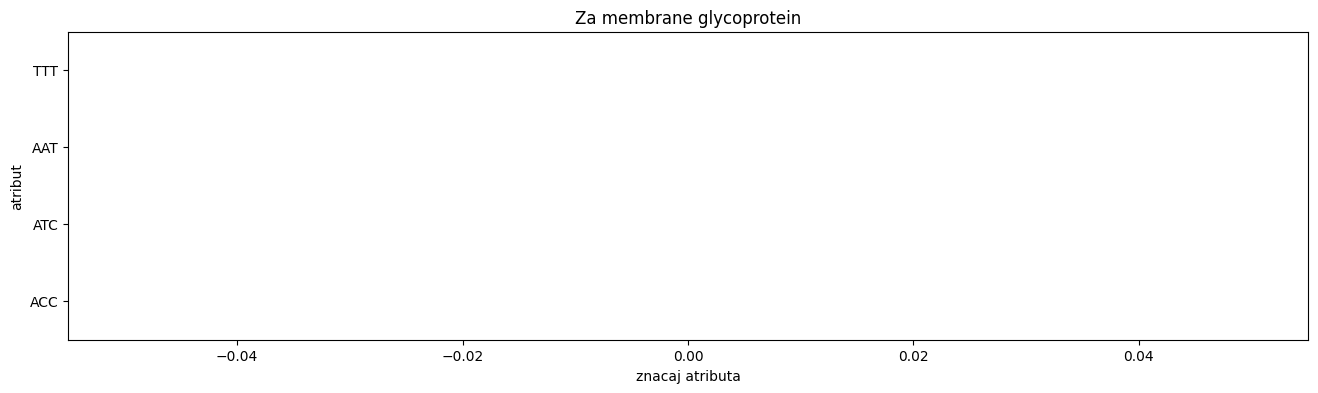

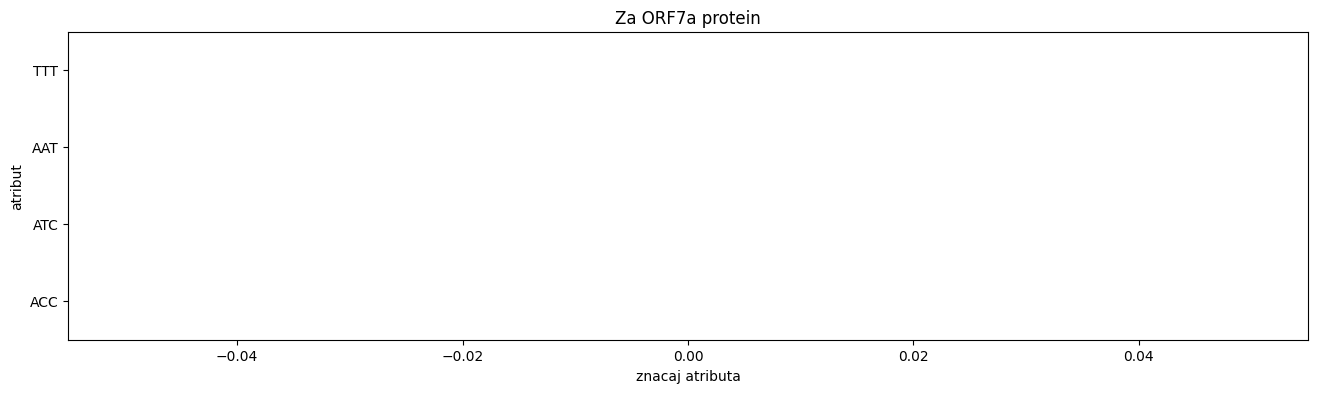

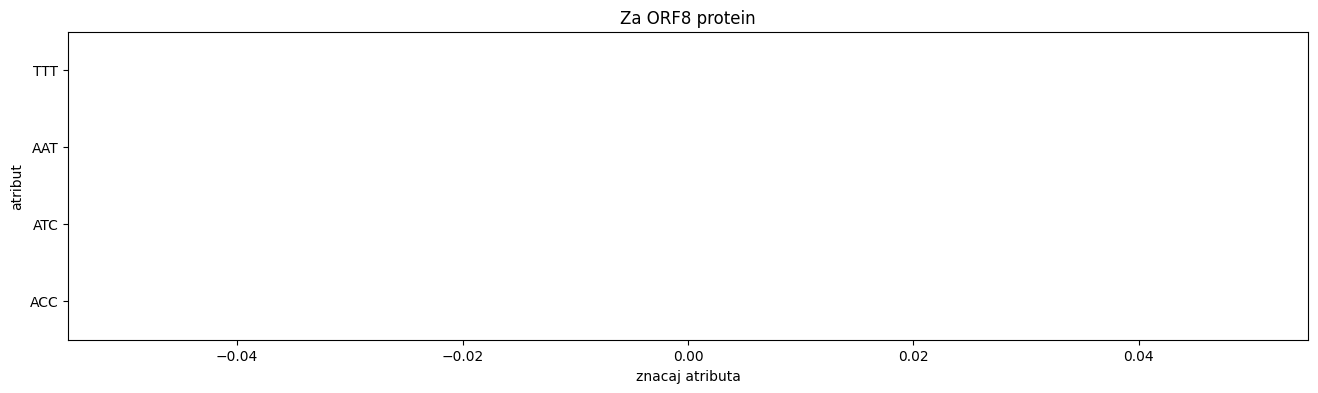

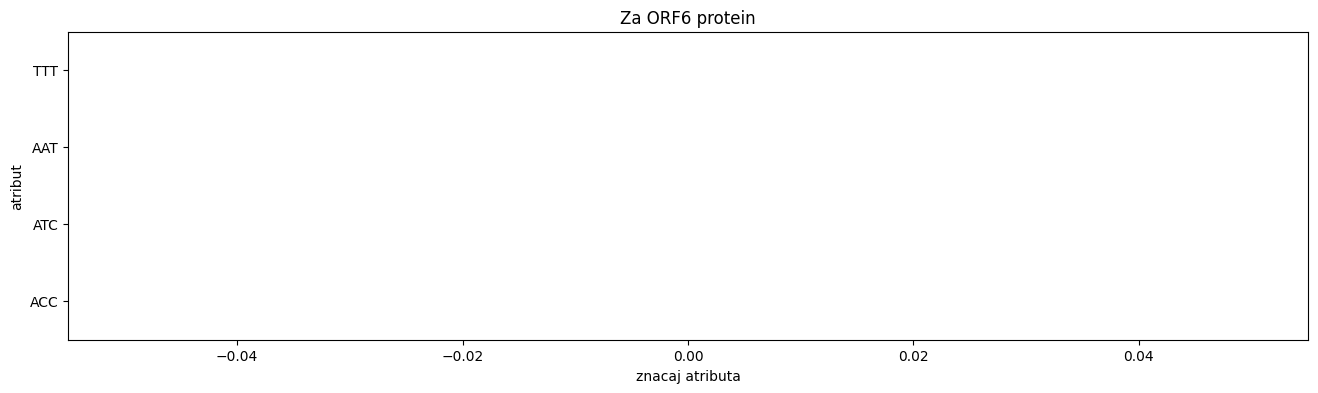

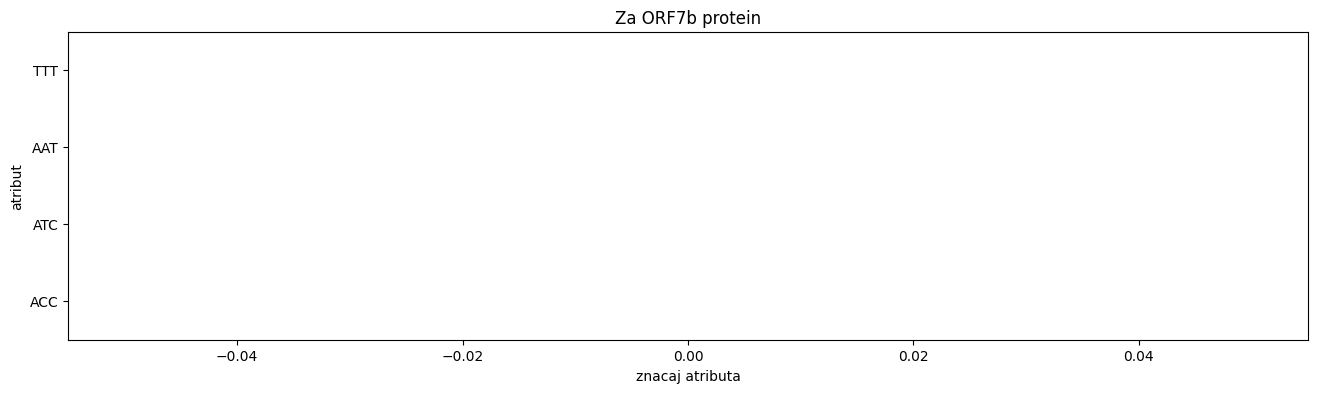

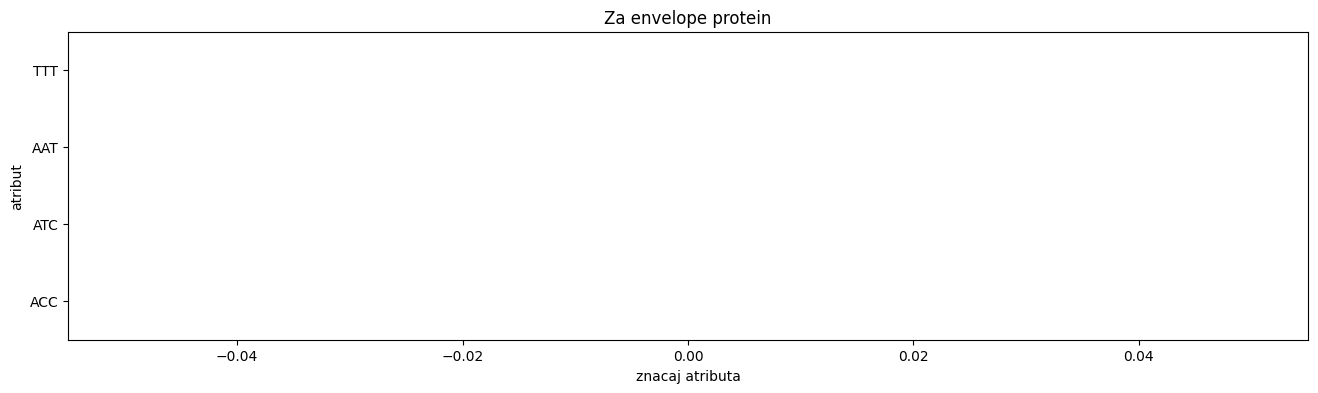

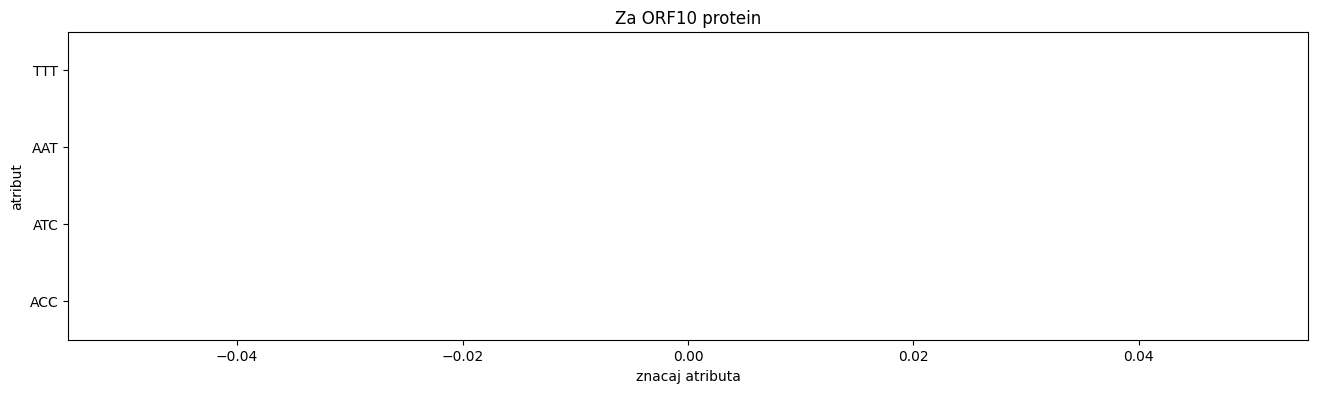

In [57]:
plot_feature_importances(clf, X_test, y_test,
                         'Za test podatke',
                         n_repeats=32, n_jobs=2)

for protein in protein_labels:
    plot_feature_importances(clf,
                             X_test[y_pred == protein],
                             y_test[y_pred == protein],
                             f'Za {protein}',
                             n_repeats=32, n_jobs=2)

### Ekstremno gradijentno pojačavanje stabala odlučivanja

Unakrsnom proverom ćemo izabrati najbolji model varirajući broj klasifikatora, maksimalnu dubinu stabala odlučivanja i stopu učenja.

In [58]:
params = [{'n_estimators': [32, 64, 128],
           'max_depth': [2, 4],
           'learning_rate': [0.01, 0.1, 0.2],
           'objective': ['reg:linear'],
           'nthread': [-1],
           'random_state': [seed]}]

In [59]:
clf = BayesSearchCV(XGBClassifier(), params, scoring='balanced_accuracy', n_jobs=2, cv=5)
_ = clf.fit(X_train, enc.transform(y_train))

Parametri najboljeg modela.

In [60]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

learning_rate,max_depth,n_estimators,nthread,objective,random_state
0.100000,2,64,-1,reg:linear,196883


Izveštaj za trening skup podataka.

In [61]:
y_true, y_pred = y_train, enc.inverse_transform(clf.predict(X_train))
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000       364
          ORF1a polyprotein    1.00000   1.00000   1.00000    241372
         ORF1ab polyprotein    1.00000   1.00000   1.00000    314439
              ORF3a protein    1.00000   1.00000   1.00000     18476
               ORF6 protein    1.00000   1.00000   1.00000      1098
              ORF7a protein    1.00000   1.00000   1.00000      3937
              ORF7b protein    1.00000   1.00000   1.00000       743
               ORF8 protein    1.00000   1.00000   1.00000      3831
           envelope protein    1.00000   1.00000   1.00000       658
      membrane glycoprotein    1.00000   1.00000   1.00000      5083
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000     29103
       surface glycoprotein    1.00000   1.00000   1.00000     76782

                   accuracy                        1.00000    695886
                  macro avg    1

Matrica konfuzije za trening skup podataka.

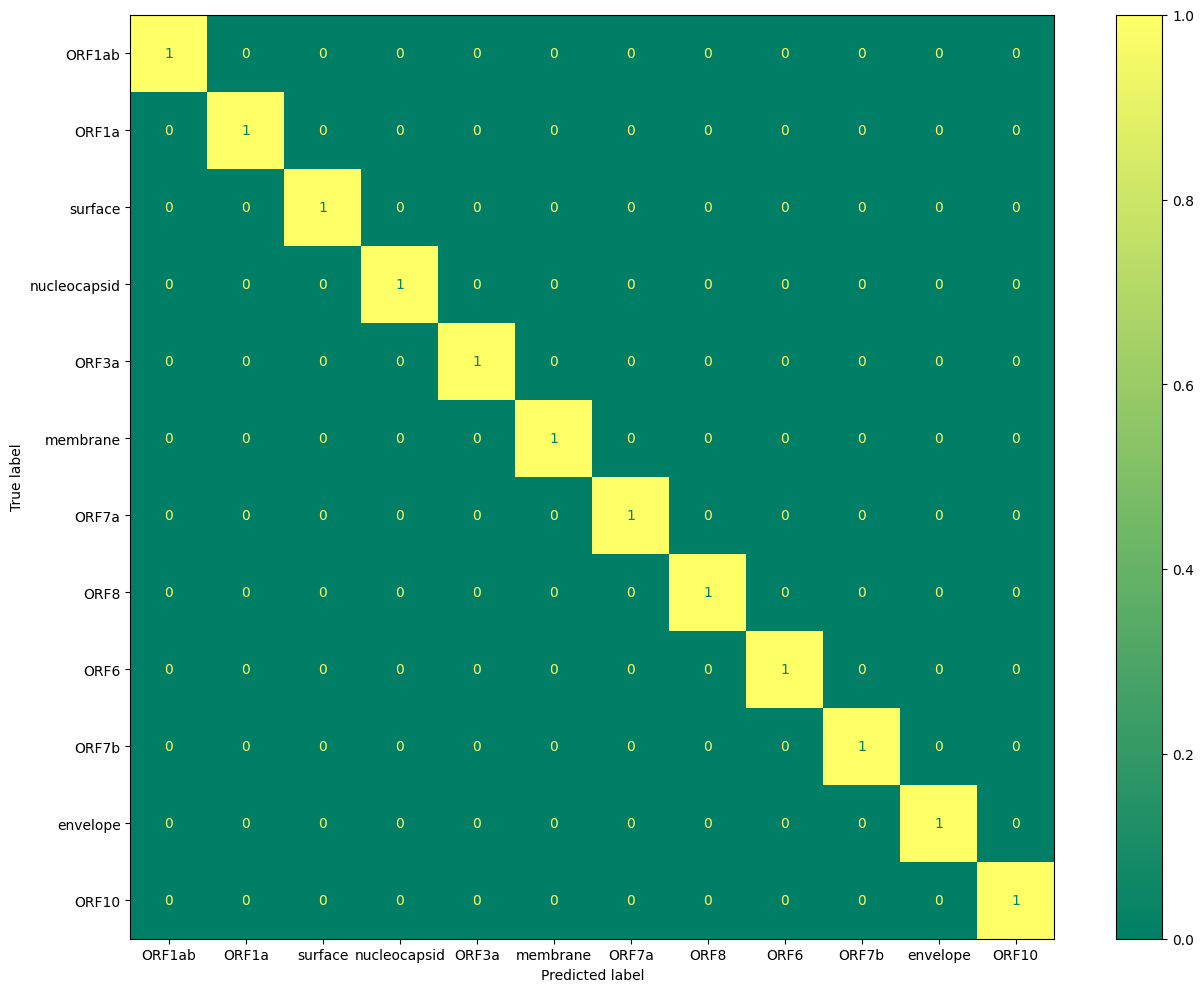

In [62]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

_, ax = plt.subplots(figsize=(16,12))

fig.plot(ax=ax, cmap='summer')
plt.show()

Izveštaj za test skup podataka.

In [63]:
y_true, y_pred = y_test, enc.inverse_transform(clf.predict(X_test))
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000        91
          ORF1a polyprotein    1.00000   1.00000   1.00000     60343
         ORF1ab polyprotein    1.00000   1.00000   1.00000     78610
              ORF3a protein    1.00000   1.00000   1.00000      4619
               ORF6 protein    1.00000   1.00000   1.00000       274
              ORF7a protein    1.00000   1.00000   1.00000       984
              ORF7b protein    1.00000   1.00000   1.00000       186
               ORF8 protein    1.00000   1.00000   1.00000       958
           envelope protein    1.00000   1.00000   1.00000       164
      membrane glycoprotein    1.00000   1.00000   1.00000      1271
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000      7276
       surface glycoprotein    1.00000   1.00000   1.00000     19196

                   accuracy                        1.00000    173972
                  macro avg    1

Matrica konfuzije za test skup podataka.

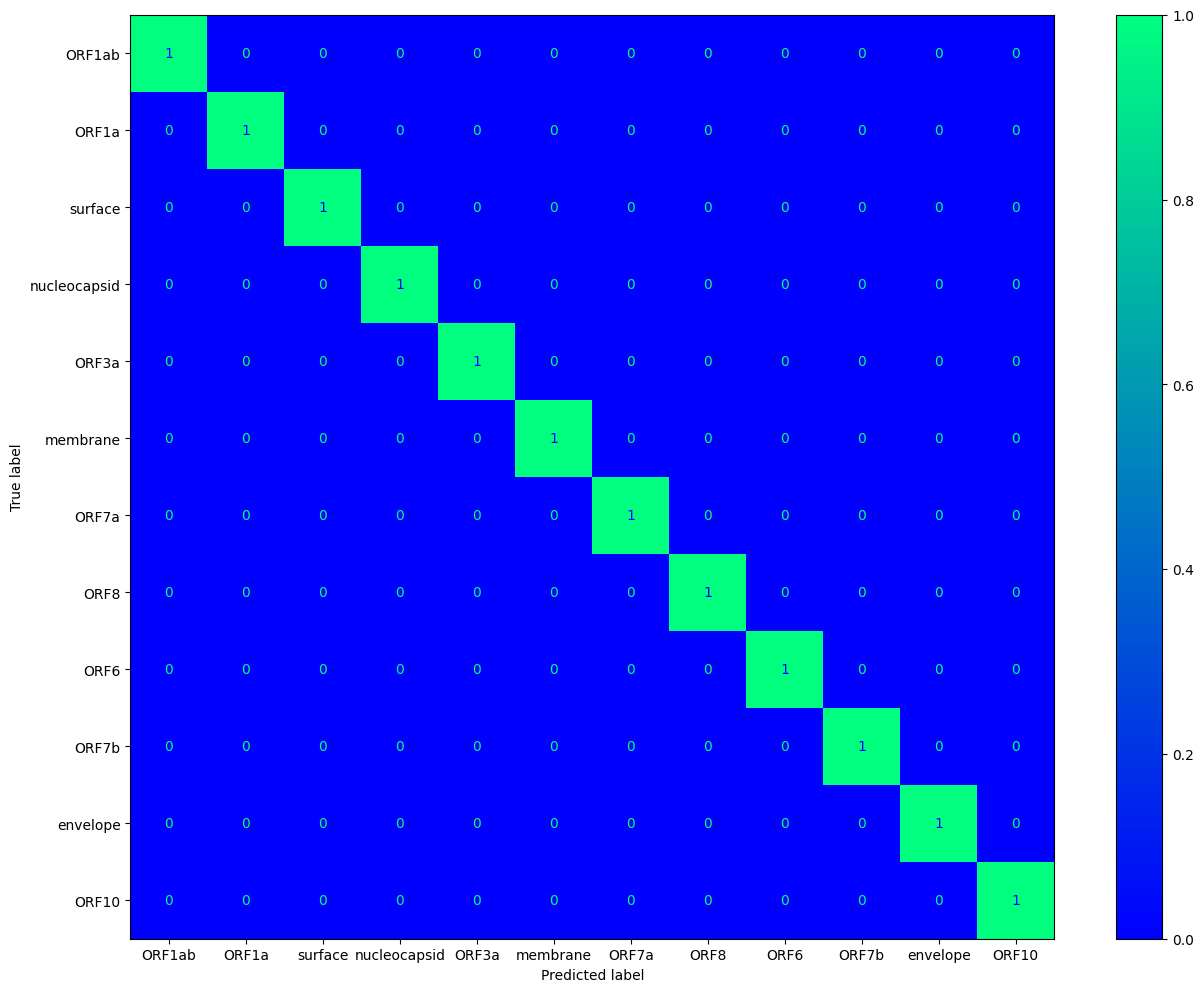

In [64]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

_, ax = plt.subplots(figsize=(16,12))

fig.plot(ax=ax, cmap='winter')
plt.show()

Važnost atributa za test skup podataka.

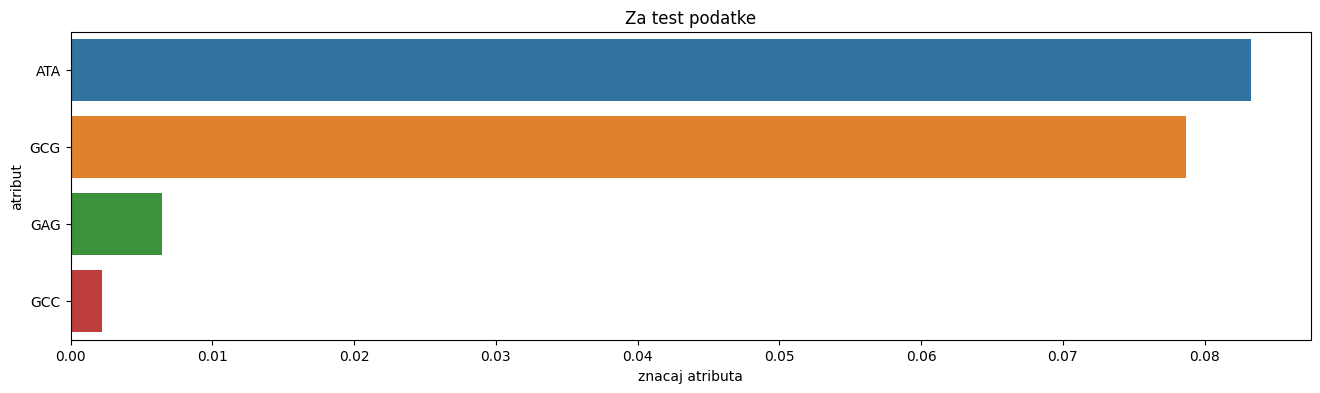

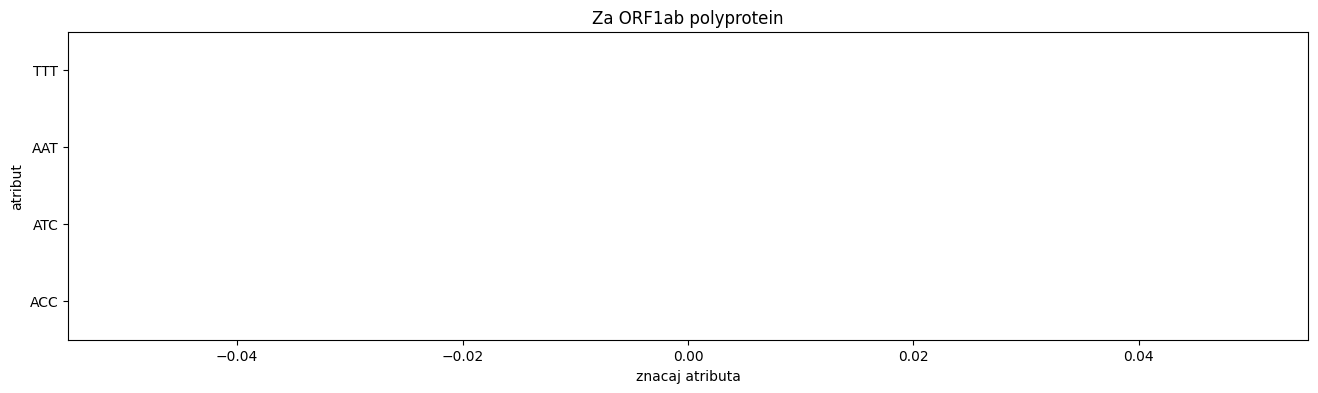

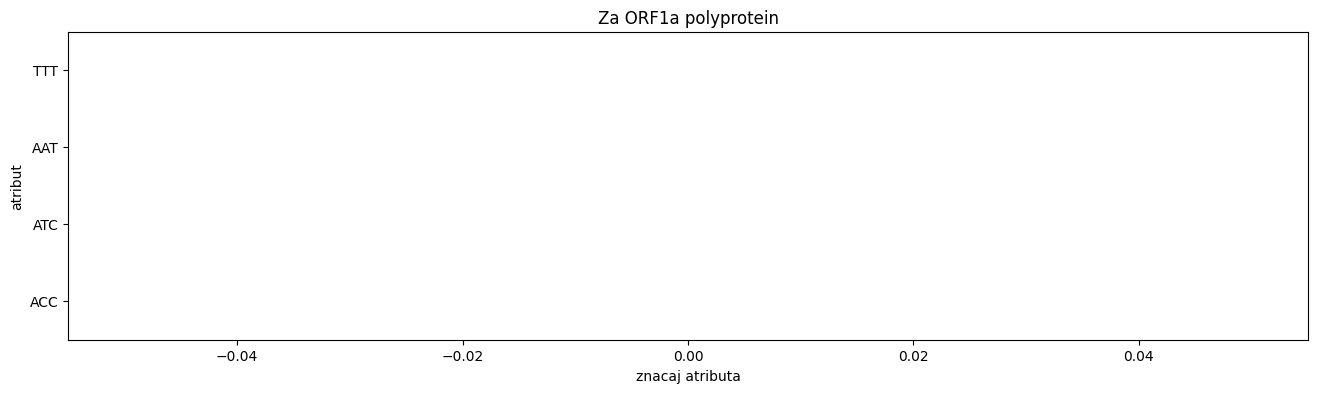

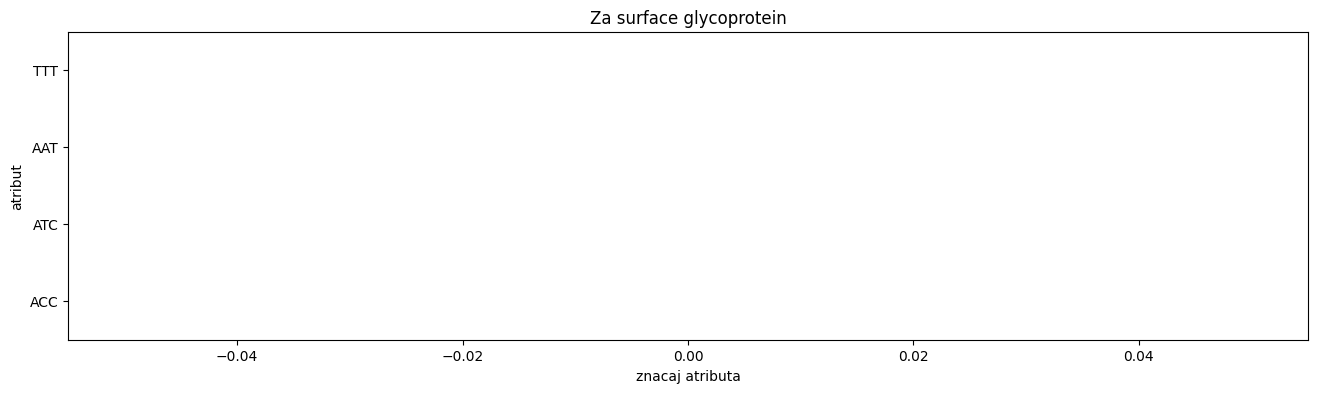

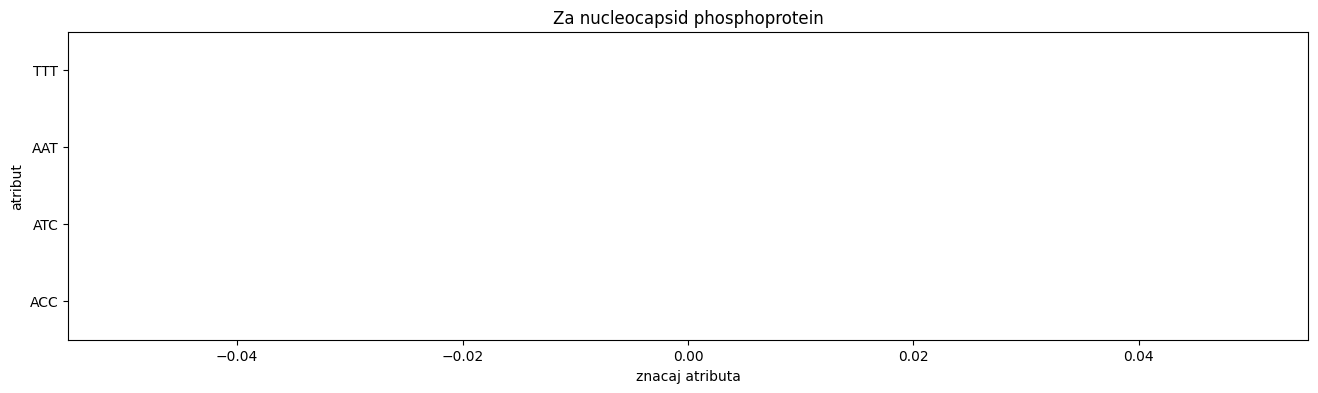

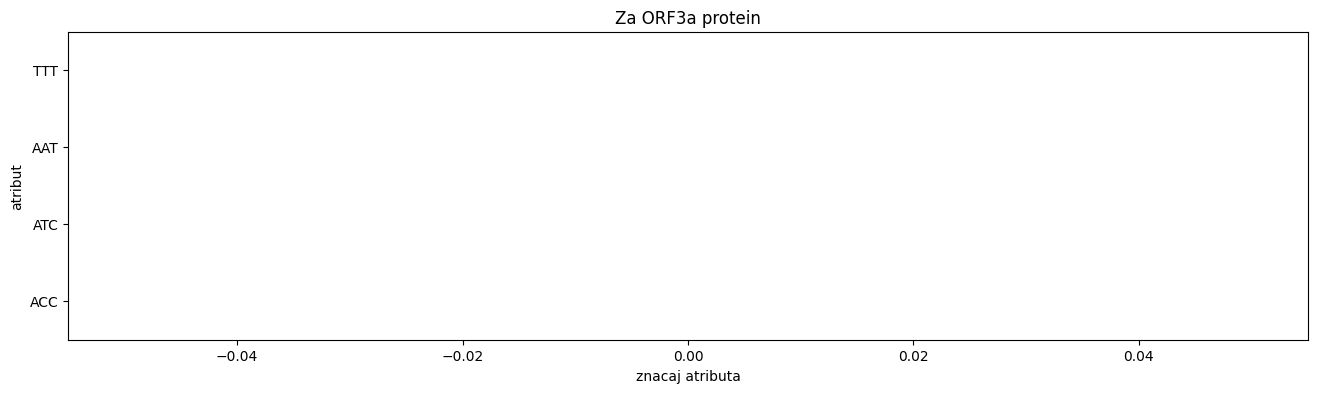

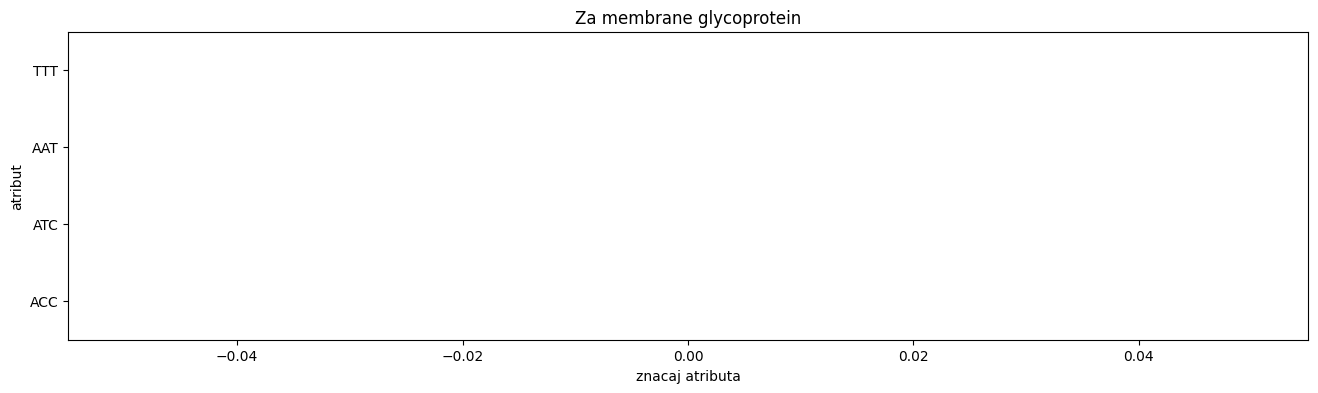

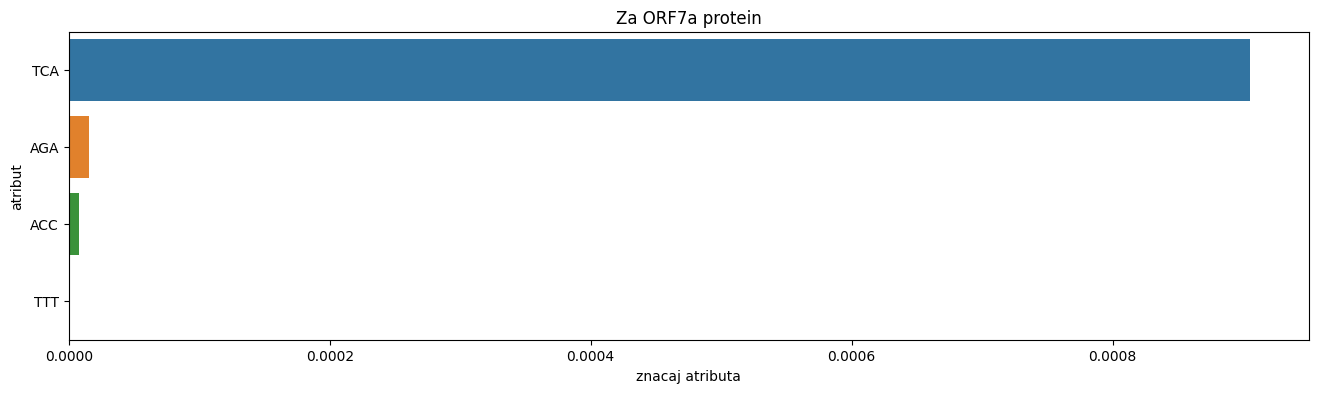

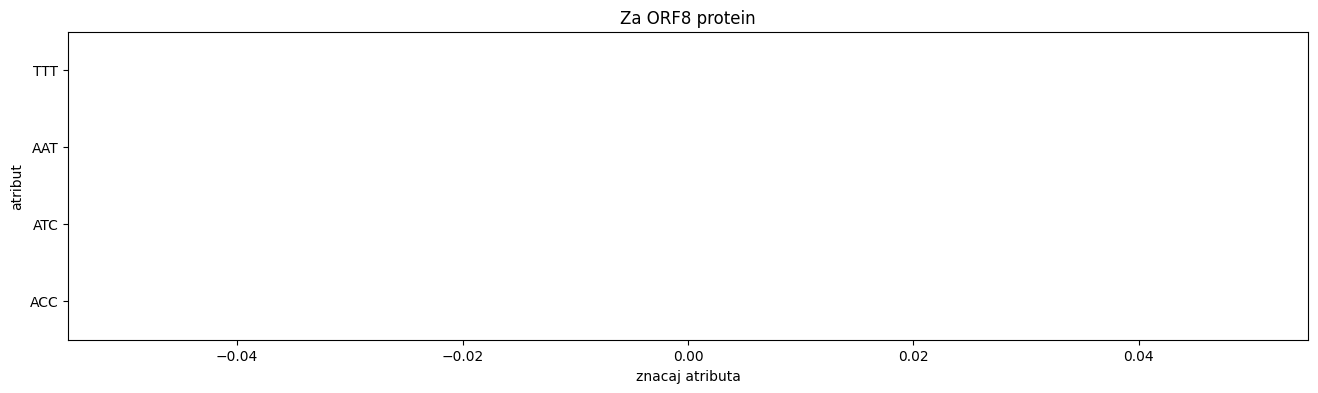

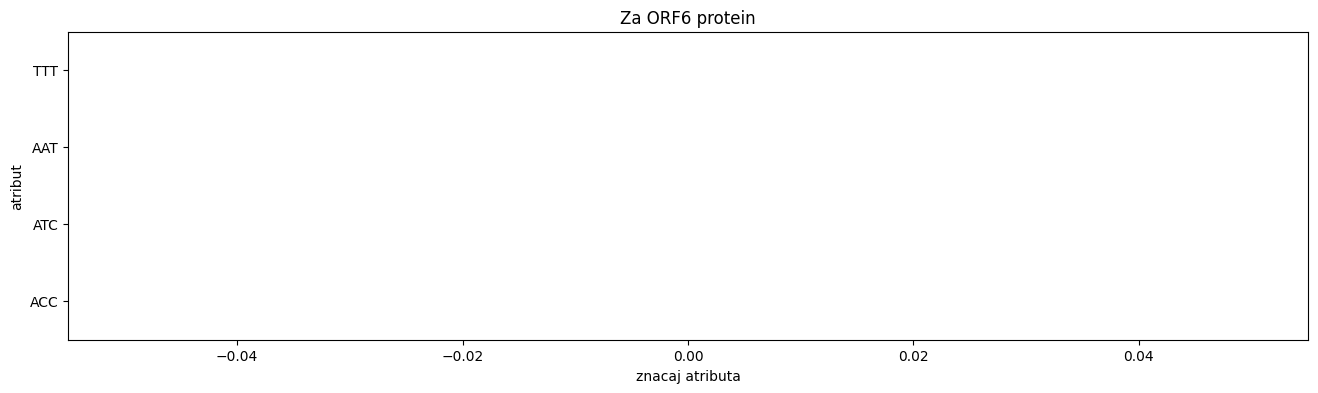

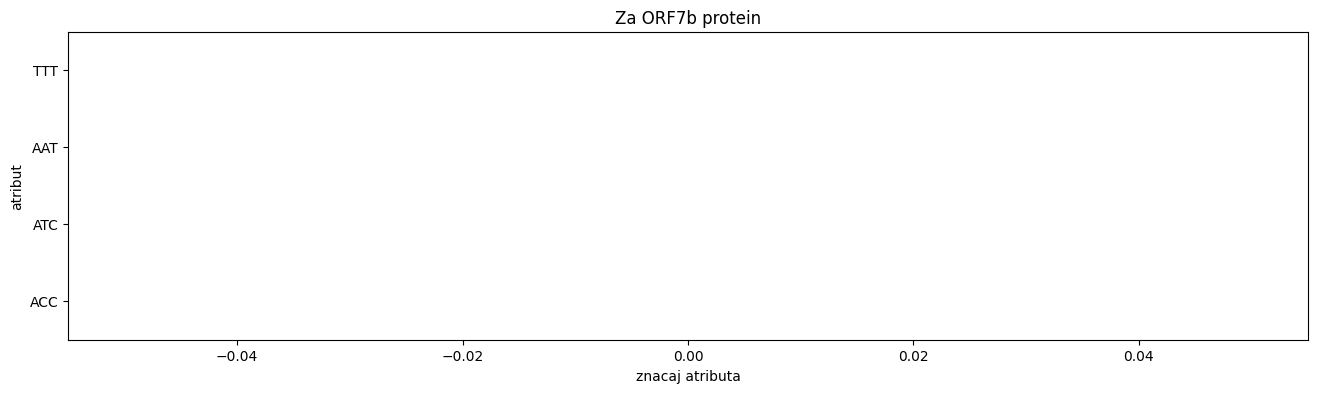

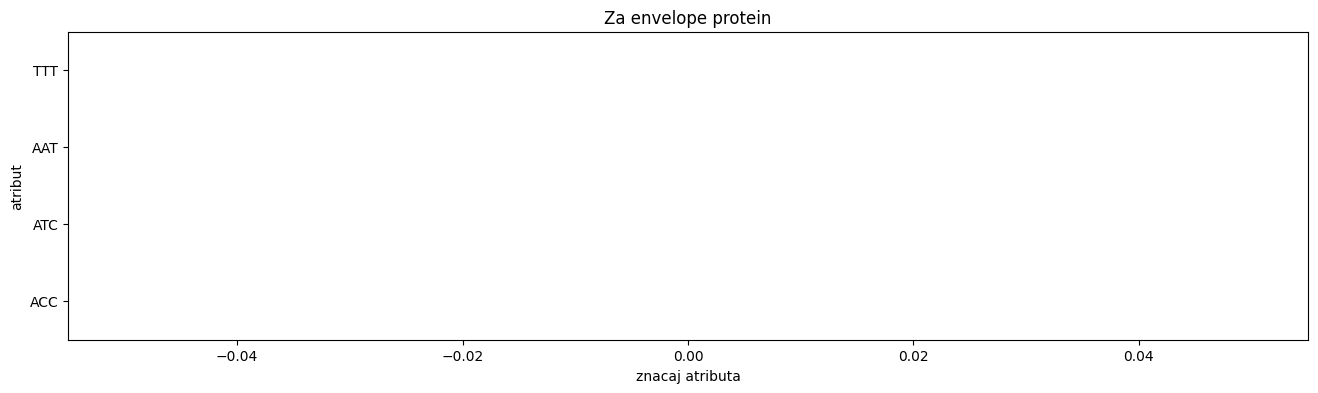

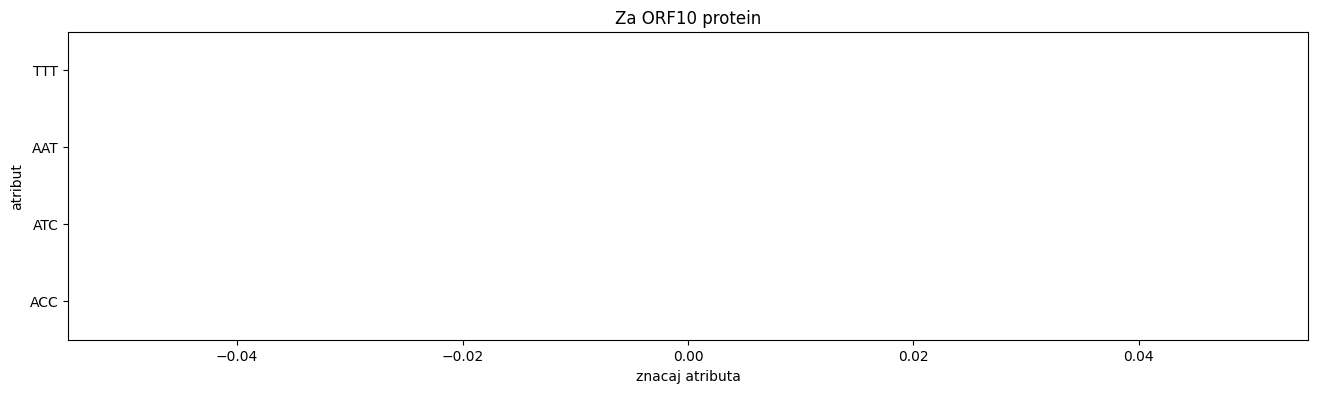

In [65]:
plot_feature_importances(clf, X_test, pd.Series(enc.transform(y_test), name='Protein'),
                         'Za test podatke',
                         n_repeats=128, n_jobs=2)

for protein in protein_labels:
    plot_feature_importances(clf,
                             X_test[y_pred == protein],
                             pd.Series(enc.transform(y_test[y_pred == protein]), name='Protein'),
                             f'Za {protein}',
                             n_repeats=128, n_jobs=2)

### K-najbližih suseda

Efikasnija implementacija osnovnog algoritma sa uniformnim težinama i Manhetn rastojanjem.

In [66]:
class AnnoyKNN:
    def __init__(self, weighted=False, metric='manhattan', k=5, n_trees=128, n_jobs=1, random_state=None):
        assert isinstance(weighted, bool), 'weighted has to be bool'
        assert isinstance(metric, str), 'metric has to be str'
        assert isinstance(k, int), 'k has to be int'
        assert isinstance(n_trees, int), 'n_trees has to be int'
        assert isinstance(n_jobs, int), 'n_jobs has to be int'
        assert isinstance(random_state, (int, type(None))), 'random_state has to be int or None'
        
        self.index = None
        self.y = None
        self.k = k
        self.metric = metric
        self.n_trees = n_trees
        self.n_jobs = n_jobs
        self.weighted = weighted
        self.random_state = random_state

    def __sklearn_clone__(self):
        return self

    def get_params(self, deep=True):
        return {'index': self.index,
                'y': self.y,
                'k': self.k,
                'metric': self.metric,
                'n_trees': self.n_trees,
                'n_jobs': self.n_jobs,
                'weighted': self.weighted,
                'random_state': self.random_state}
    
    def set_params(self, **params):
        self.index = None
        self.y = None
        self.k = 5
        self.metric = 'manhattan'
        self.n_trees = 128
        self.n_jobs = 1
        self.weighted = False
        self.random_state = None
        
        for key, val in params.items():
            self.__dict__[key] = val

        assert isinstance(self.weighted, bool), 'weighted has to be bool'
        assert isinstance(self.metric, str), 'metric has to be str'
        assert isinstance(self.k, int), 'k has to be int'
        assert isinstance(self.n_trees, int), 'n_trees has to be int'
        assert isinstance(self.n_jobs, int), 'n_jobs has to be int'
        assert isinstance(self.random_state, (int, type(None))), 'random_state has to be int or None'
        
        return self

    def fit(self, X, y):
        self.index = AnnoyIndex(X.shape[1], self.metric)
        self.index.set_seed(self.random_state)
        
        assert isinstance(X, pd.DataFrame), 'X has to be pandas DataFrame object'
        for i, v in enumerate(X.to_numpy()):
            self.index.add_item(i, v)
        self.index.build(self.n_trees, self.n_jobs)
        
        assert isinstance(y, pd.Series), 'y has to be pandas Series object'
        self.y = y.to_numpy()

    def predict(self, X):
        assert isinstance(X, pd.DataFrame), 'X has to be pandas DataFrame object'
        predictions = None
        if self.weighted:
            indices = np.empty((X.shape[0], self.k), dtype=np.int32)
            distances = np.empty((X.shape[0], self.k), dtype=np.float64)
            for i, v in enumerate(X.to_numpy()):
                tmp_i, tmp_d = self.index.get_nns_by_vector(v, self.k, include_distances=self.weighted)
                indices[i] = np.array(tmp_i, dtype=np.int32)
                distances[i] = np.array(tmp_d, dtype=np.float64)
            vote = self.y[indices]
            weight = np.reciprocal(distances)
            weighted_votes = [(vote[a], weight[a]) for a in range(indices.shape[0])]
            predictions = np.array([np.argmax(np.bincount(a, weights=b)) for a, b in weighted_votes])
        else:
            indices = np.empty((X.shape[0], self.k), dtype=np.int32)
            for i, v in enumerate(X.to_numpy()):
                tmp_i = self.index.get_nns_by_vector(v, self.k, include_distances=self.weighted)
                indices[i] = np.array(tmp_i, dtype=np.int32)
            votes = self.y[indices]
            predictions = np.array([np.argmax(np.bincount(a)) for a in votes])
        return predictions

In [69]:
params = [{'k': [5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41],
           'n_trees': [128, 256, 512, 1024, 2048, 4096],
           'weighted': [True, False],
           'n_jobs': [-1],
           'random_state': [seed]}]

In [70]:
clf = BayesSearchCV(AnnoyKNN(), params,
                                    scoring='balanced_accuracy',
                                    cv=5,
                                    population_size=9,
                                    generations_number=64,
                                    n_jobs=2)
_ = clf.fit(X_train, pd.Series(enc.transform(y_train)))

Parametri najboljeg modela.

In [71]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

M,k
4224,5


Izveštaj klasifikacije za trening podatke.

In [72]:
y_true, y_pred = y_train, enc.inverse_transform(clf.predict(X_train))
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    0.99725   0.99451   0.99587       364
          ORF1a polyprotein    0.99998   1.00000   0.99999    241372
         ORF1ab polyprotein    0.99998   1.00000   0.99999    314439
              ORF3a protein    0.99968   1.00000   0.99984     18476
               ORF6 protein    0.99909   0.99545   0.99726      1098
              ORF7a protein    0.99924   1.00000   0.99962      3937
              ORF7b protein    1.00000   0.99192   0.99595       743
               ORF8 protein    1.00000   0.99791   0.99895      3831
           envelope protein    1.00000   0.99696   0.99848       658
      membrane glycoprotein    0.99980   1.00000   0.99990      5083
nucleocapsid phosphoprotein    1.00000   0.99997   0.99998     29103
       surface glycoprotein    0.99997   1.00000   0.99999     76782

                   accuracy                        0.99997    695886
                  macro avg    0

Matrica konfuzije za trening podatke.

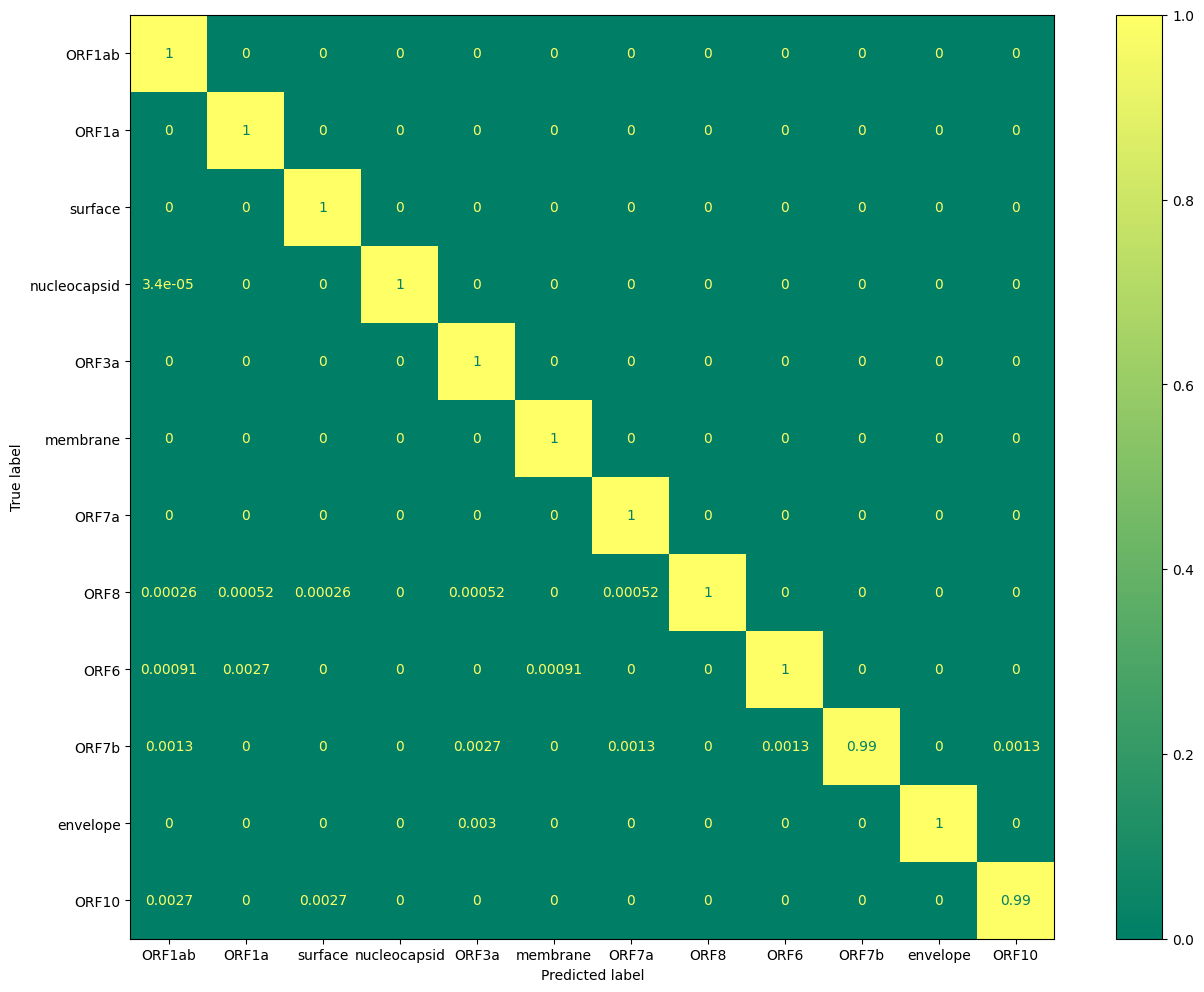

In [73]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

_, ax = plt.subplots(figsize=(16,12))

fig.plot(ax=ax, cmap='summer')
plt.show()

Izveštaj klasifikacije za test podatke.

In [74]:
y_true, y_pred = y_test, enc.inverse_transform(clf.predict(X_test))
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   0.97802   0.98889        91
          ORF1a polyprotein    0.99997   1.00000   0.99998     60343
         ORF1ab polyprotein    0.99994   1.00000   0.99997     78610
              ORF3a protein    1.00000   1.00000   1.00000      4619
               ORF6 protein    1.00000   0.98905   0.99450       274
              ORF7a protein    0.99797   1.00000   0.99898       984
              ORF7b protein    1.00000   0.98387   0.99187       186
               ORF8 protein    1.00000   0.99687   0.99843       958
           envelope protein    0.99394   1.00000   0.99696       164
      membrane glycoprotein    1.00000   1.00000   1.00000      1271
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000      7276
       surface glycoprotein    0.99995   1.00000   0.99997     19196

                   accuracy                        0.99994    173972
                  macro avg    0

Matrica konfuzije za test podatke.

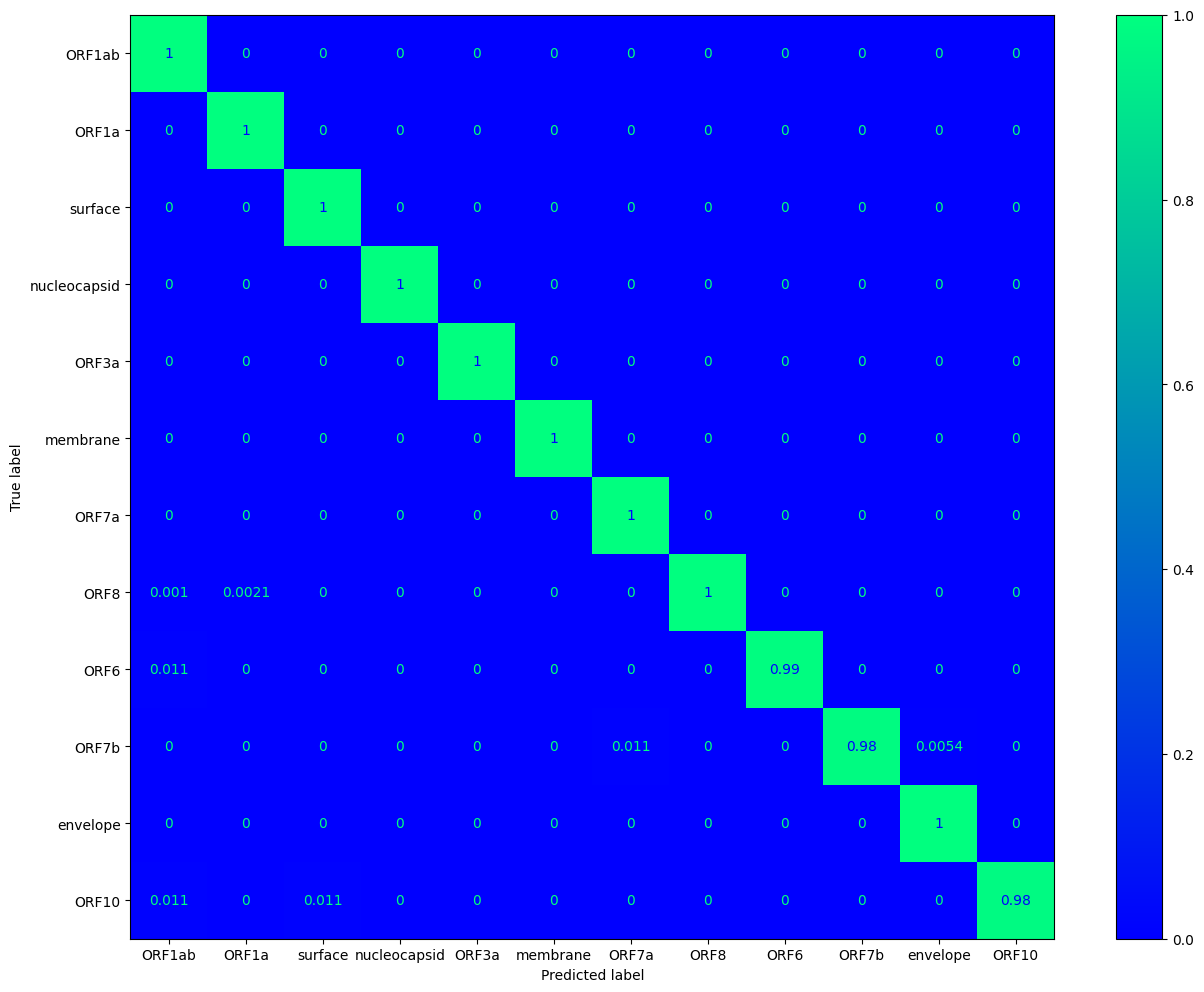

In [75]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

_, ax = plt.subplots(figsize=(16,12))

fig.plot(ax=ax, cmap='winter')
plt.show()

Važnost atributa za test podatke.

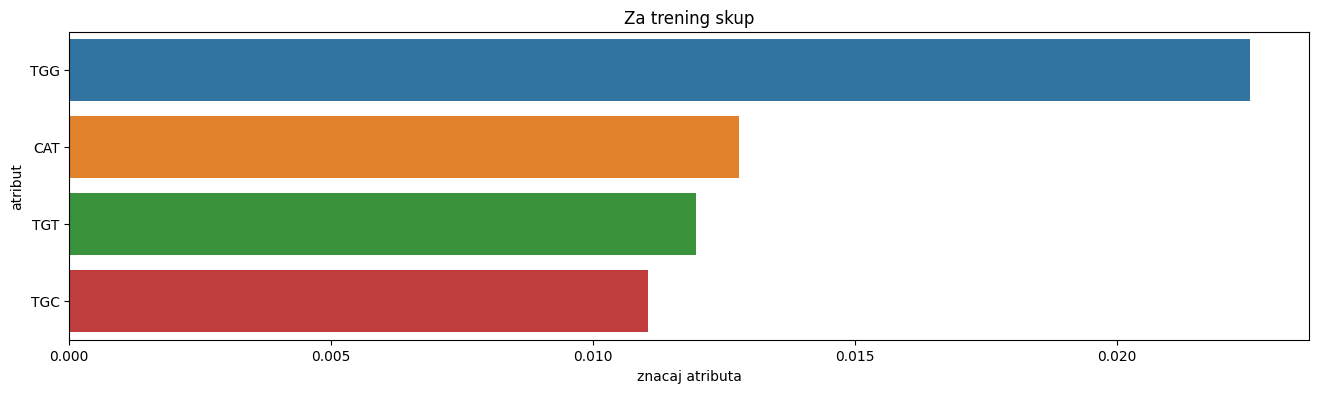

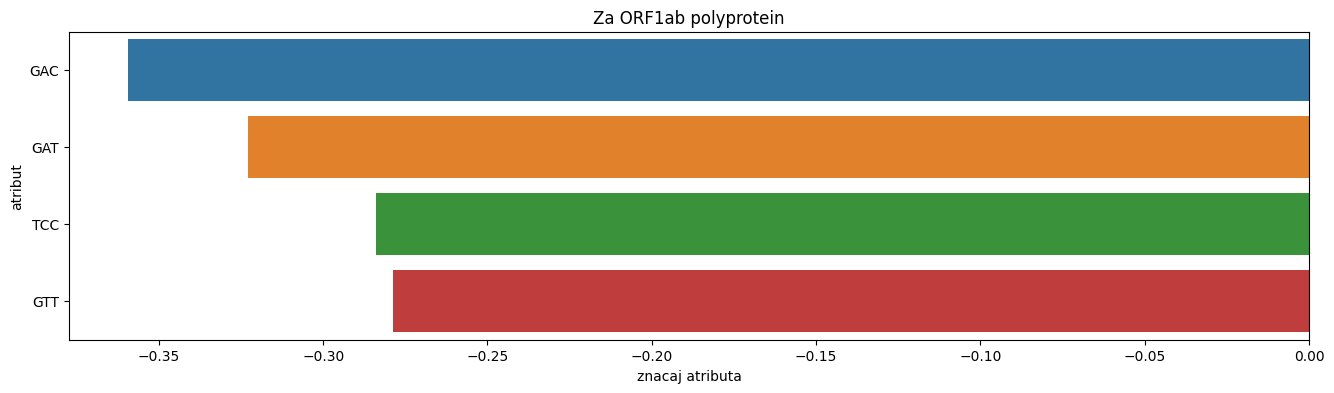

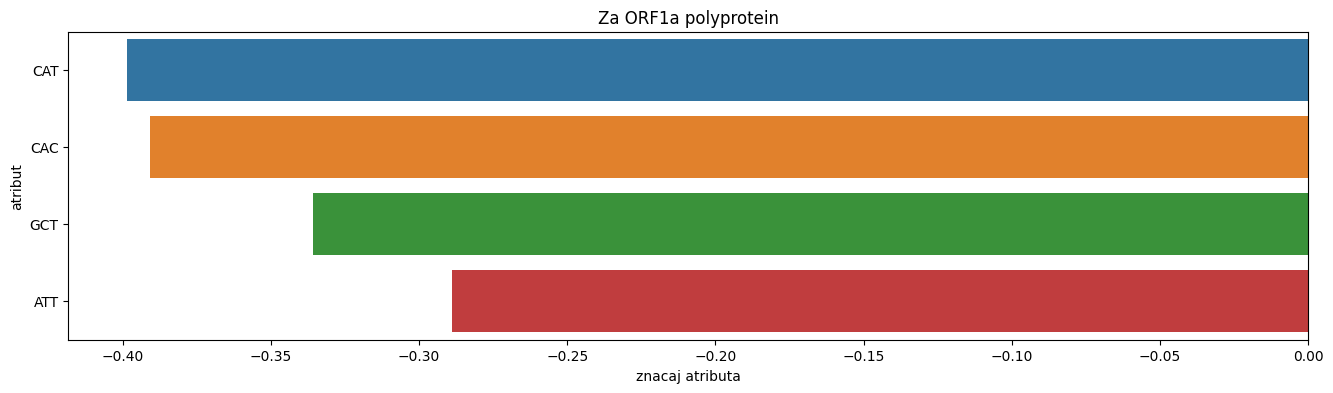

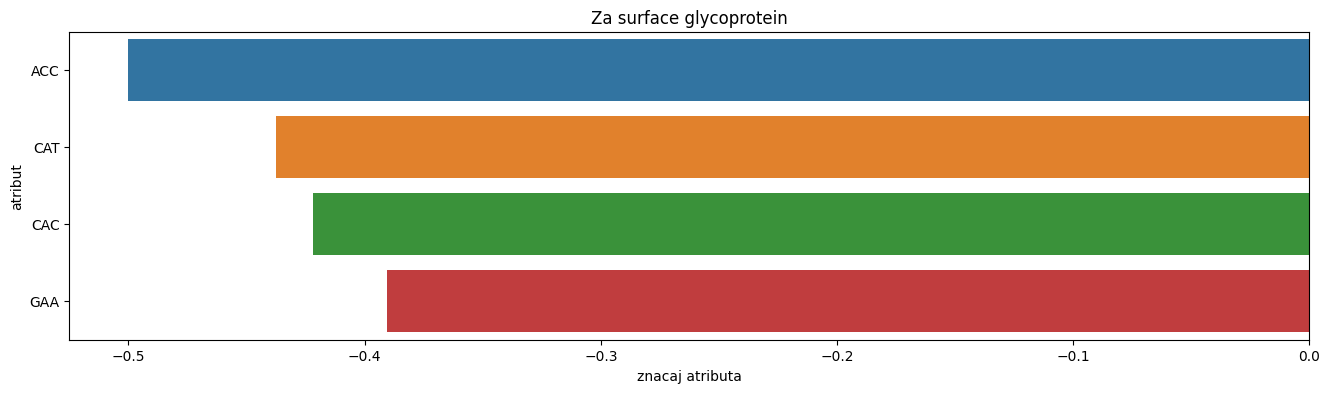

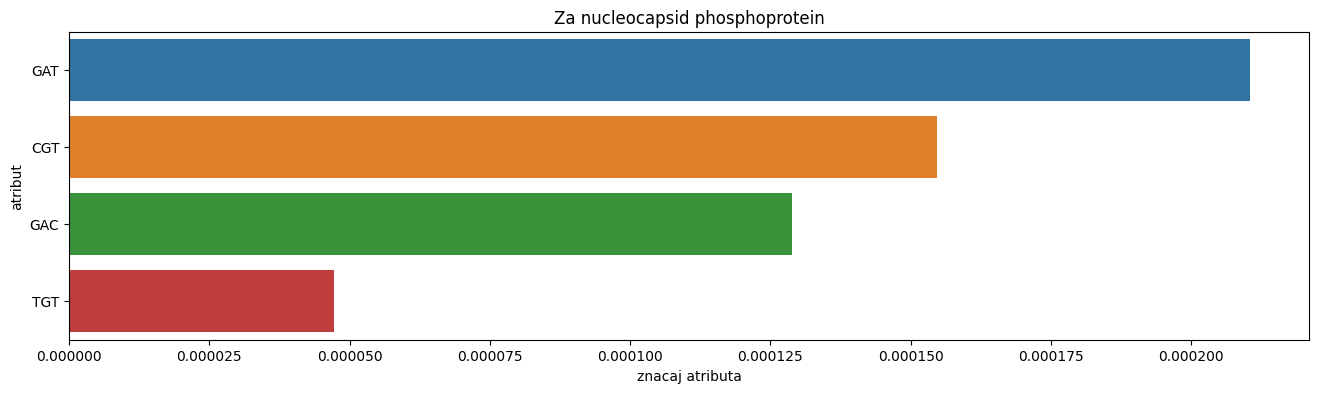

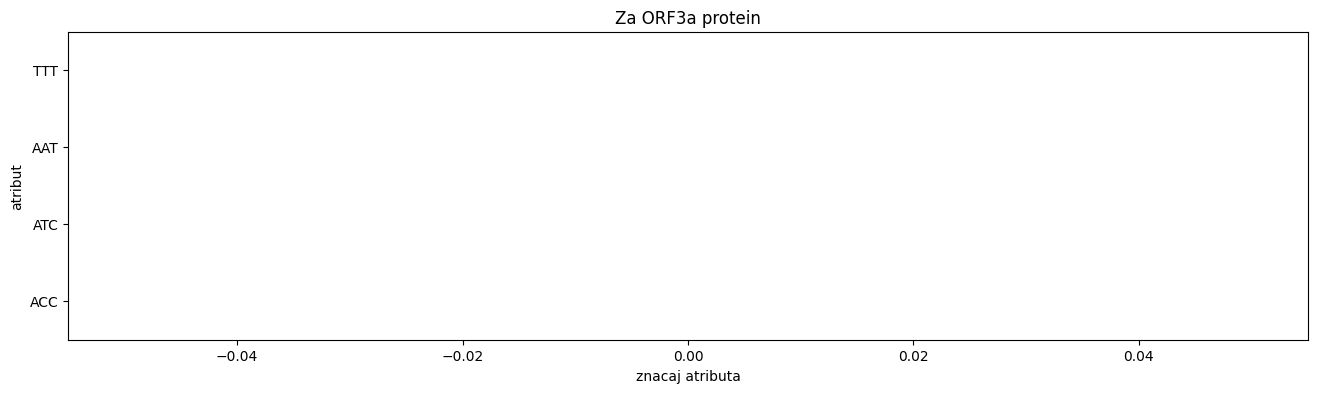

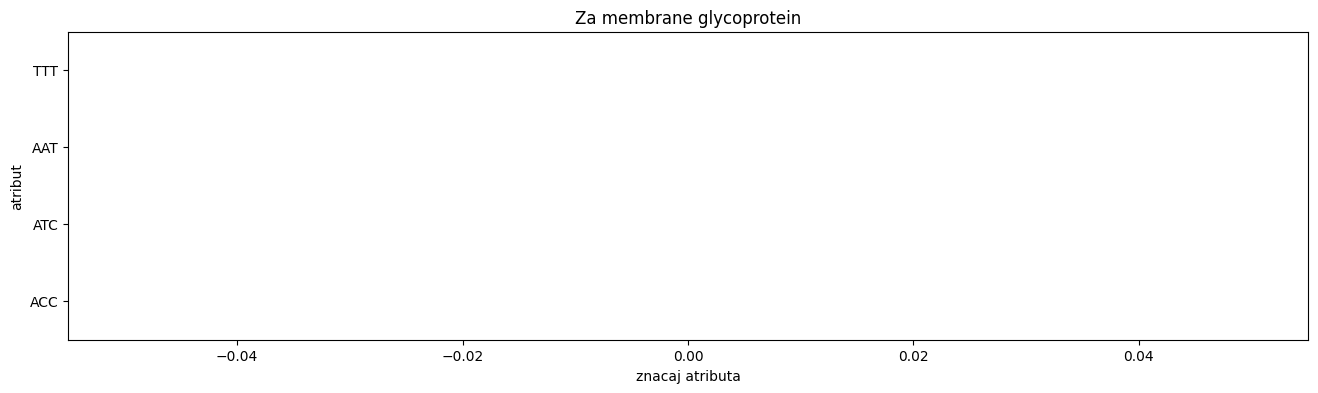

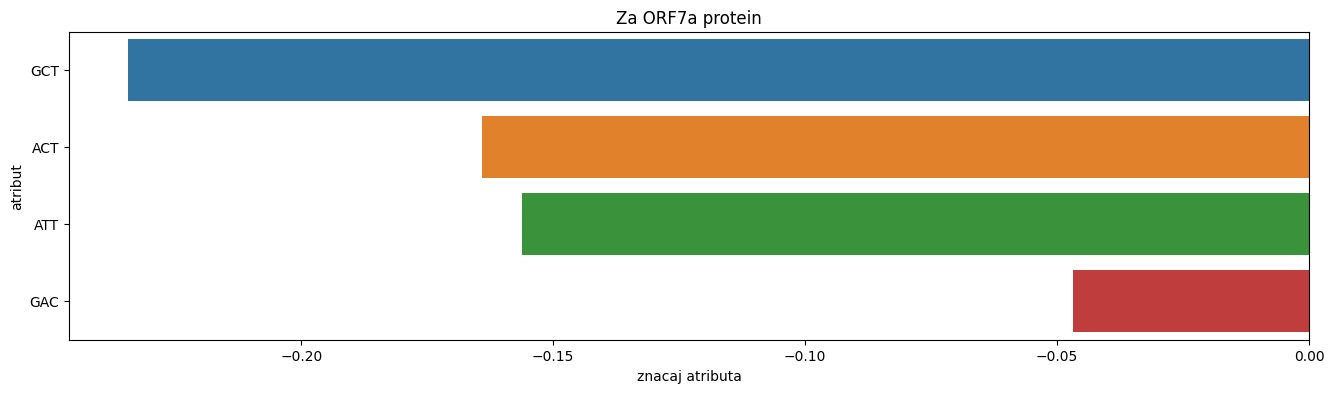

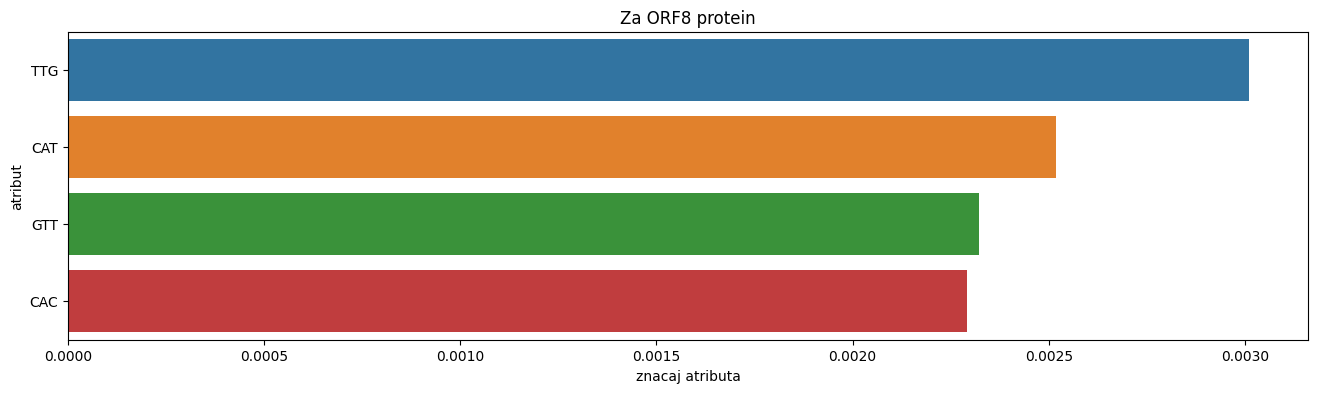

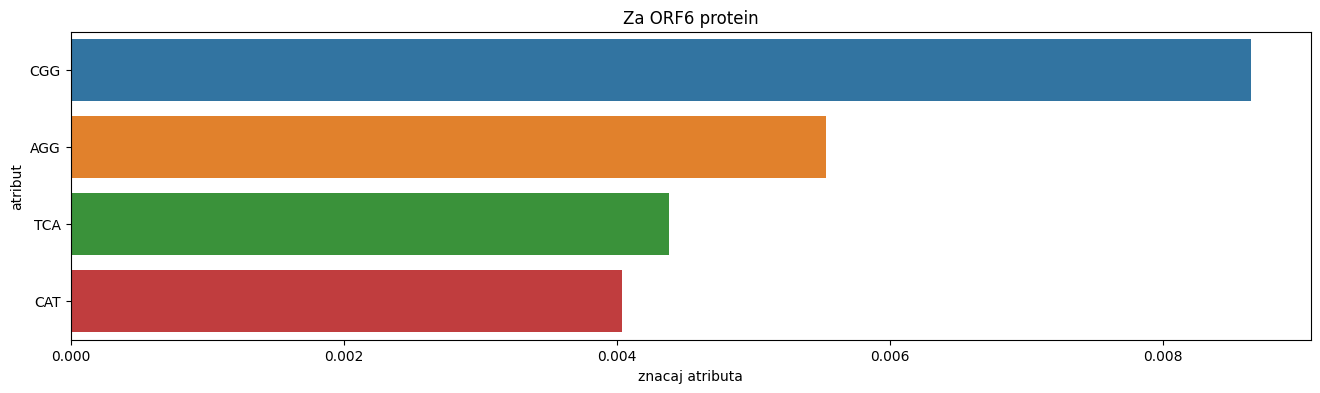

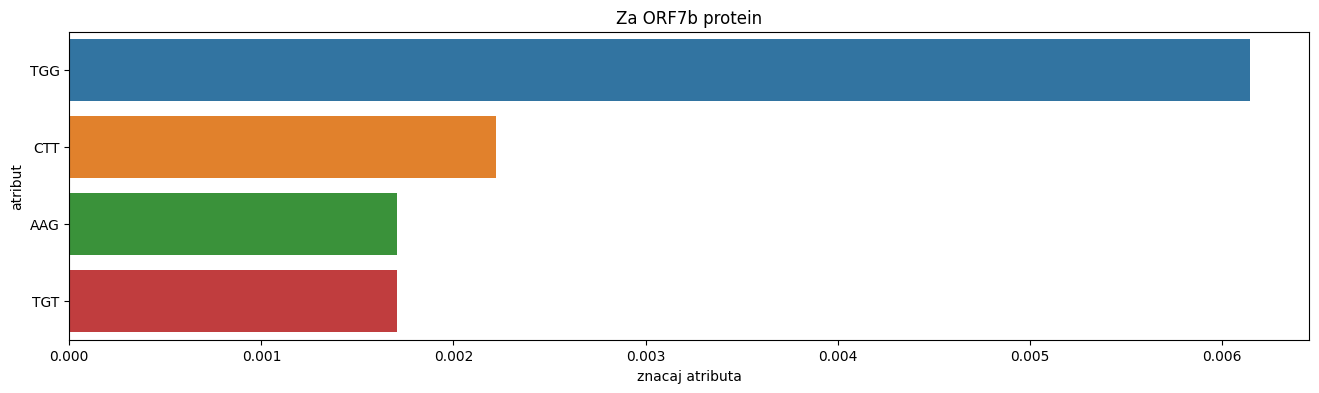

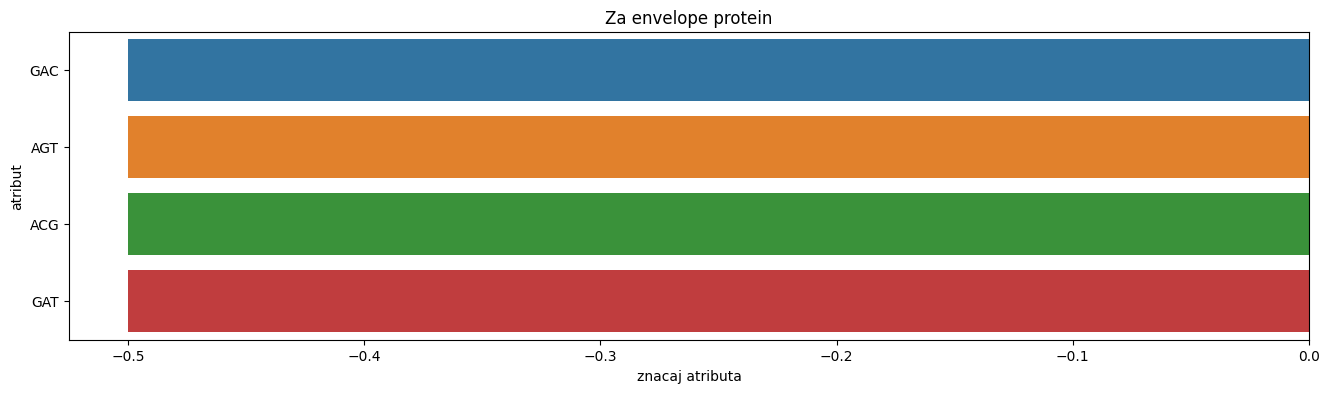

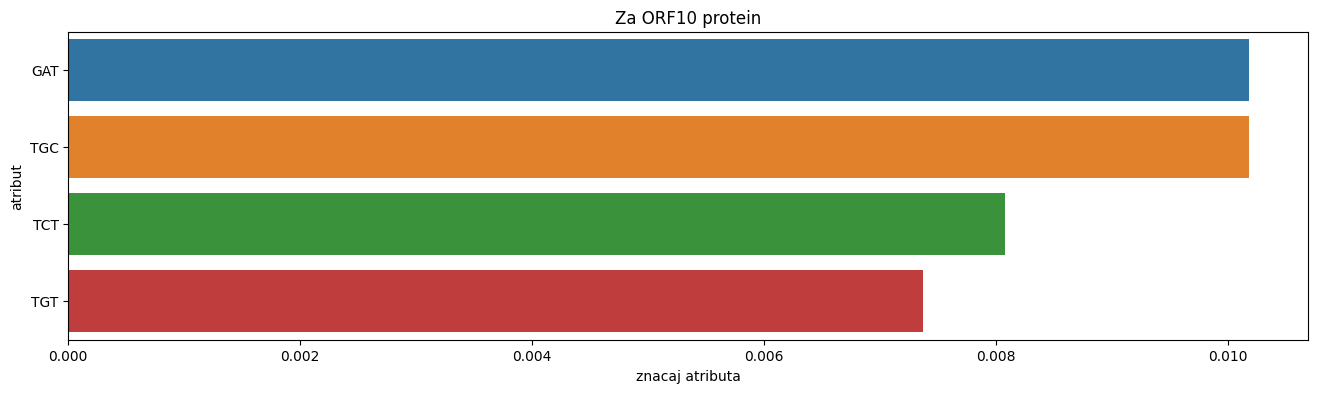

In [76]:
plot_permutation_importances(
    calculate_permutation_importances(clf,
                                      X_test,
                                      y_true,
                                      y_pred,
                                      balanced_accuracy_score,
                                      repeats=32),
    'Za trening skup')

for protein in protein_labels:
    plot_permutation_importances(
        calculate_permutation_importances(clf,
                                          X_test[y_pred == protein],
                                          y_true[y_pred == protein],
                                          y_pred[y_pred == protein],
                                          balanced_accuracy_score,
                                          repeats=32),
        f'Za {protein}')

### Linearna mašina sa potpornim vektorima

Tražimo najbolji model variranjem parametara za regularizaciju i skaliranje.

In [77]:
params = [{'dual': [True],
           'C': [0.1, 1, 10, 100],
           'intercept_scaling': [0.01, 0.1, 1, 10],
           'class_weight': ['balanced'],
           'max_iter': [2147483647],
           'random_state': [seed]}]

In [78]:
clf = BayesSearchCV(LinearSVC(), params, scoring='balanced_accuracy', n_jobs=-1, cv=5)
_ = clf.fit(X_train, y_train)

Parametri najboljeg modela.

In [79]:
pd.DataFrame.from_dict([clf.best_params_]).style.hide(axis='index')

C,class_weight,dual,intercept_scaling,max_iter,random_state
10,balanced,True,1,2147483647,196883


Izveštaj za trening skup podataka.

In [80]:
y_true, y_pred = y_train, clf.predict(X_train)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   1.00000   1.00000       364
          ORF1a polyprotein    1.00000   1.00000   1.00000    241372
         ORF1ab polyprotein    1.00000   1.00000   1.00000    314439
              ORF3a protein    1.00000   1.00000   1.00000     18476
               ORF6 protein    1.00000   1.00000   1.00000      1098
              ORF7a protein    1.00000   1.00000   1.00000      3937
              ORF7b protein    1.00000   1.00000   1.00000       743
               ORF8 protein    1.00000   1.00000   1.00000      3831
           envelope protein    1.00000   1.00000   1.00000       658
      membrane glycoprotein    1.00000   1.00000   1.00000      5083
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000     29103
       surface glycoprotein    1.00000   1.00000   1.00000     76782

                   accuracy                        1.00000    695886
                  macro avg    1

Matrica konfuzije za trening skup podataka.

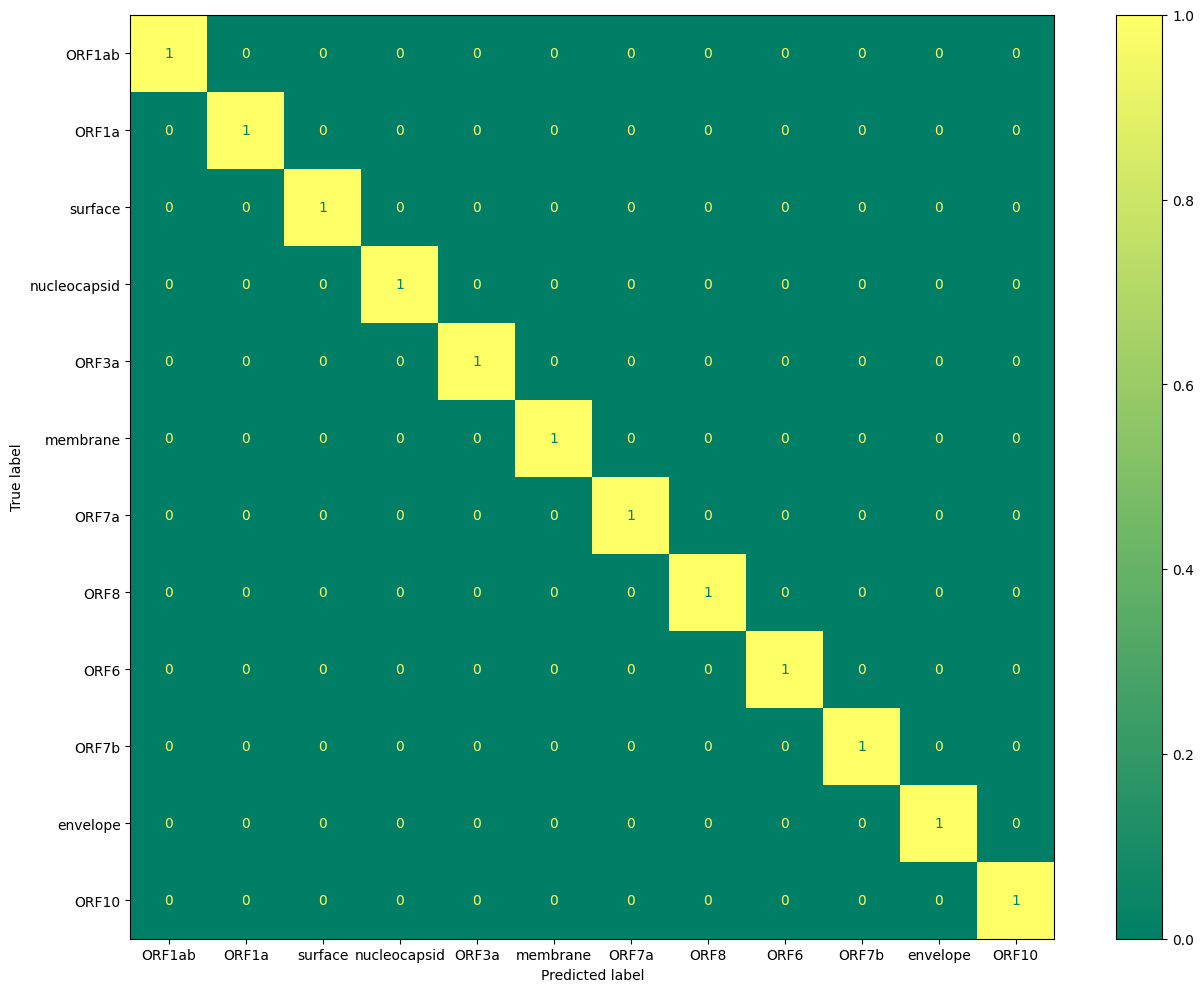

In [81]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

_, ax = plt.subplots(figsize=(16,12))

fig.plot(ax=ax, cmap='summer')
plt.show()

Izveštaj za test skup podataka.

In [82]:
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred, digits=5, zero_division=0.0))

                             precision    recall  f1-score   support

              ORF10 protein    1.00000   0.98901   0.99448        91
          ORF1a polyprotein    1.00000   1.00000   1.00000     60343
         ORF1ab polyprotein    0.99999   1.00000   0.99999     78610
              ORF3a protein    1.00000   1.00000   1.00000      4619
               ORF6 protein    1.00000   1.00000   1.00000       274
              ORF7a protein    1.00000   1.00000   1.00000       984
              ORF7b protein    1.00000   1.00000   1.00000       186
               ORF8 protein    1.00000   1.00000   1.00000       958
           envelope protein    1.00000   1.00000   1.00000       164
      membrane glycoprotein    1.00000   1.00000   1.00000      1271
nucleocapsid phosphoprotein    1.00000   1.00000   1.00000      7276
       surface glycoprotein    1.00000   1.00000   1.00000     19196

                   accuracy                        0.99999    173972
                  macro avg    1

Matrica konfuzije za test skup podataka.

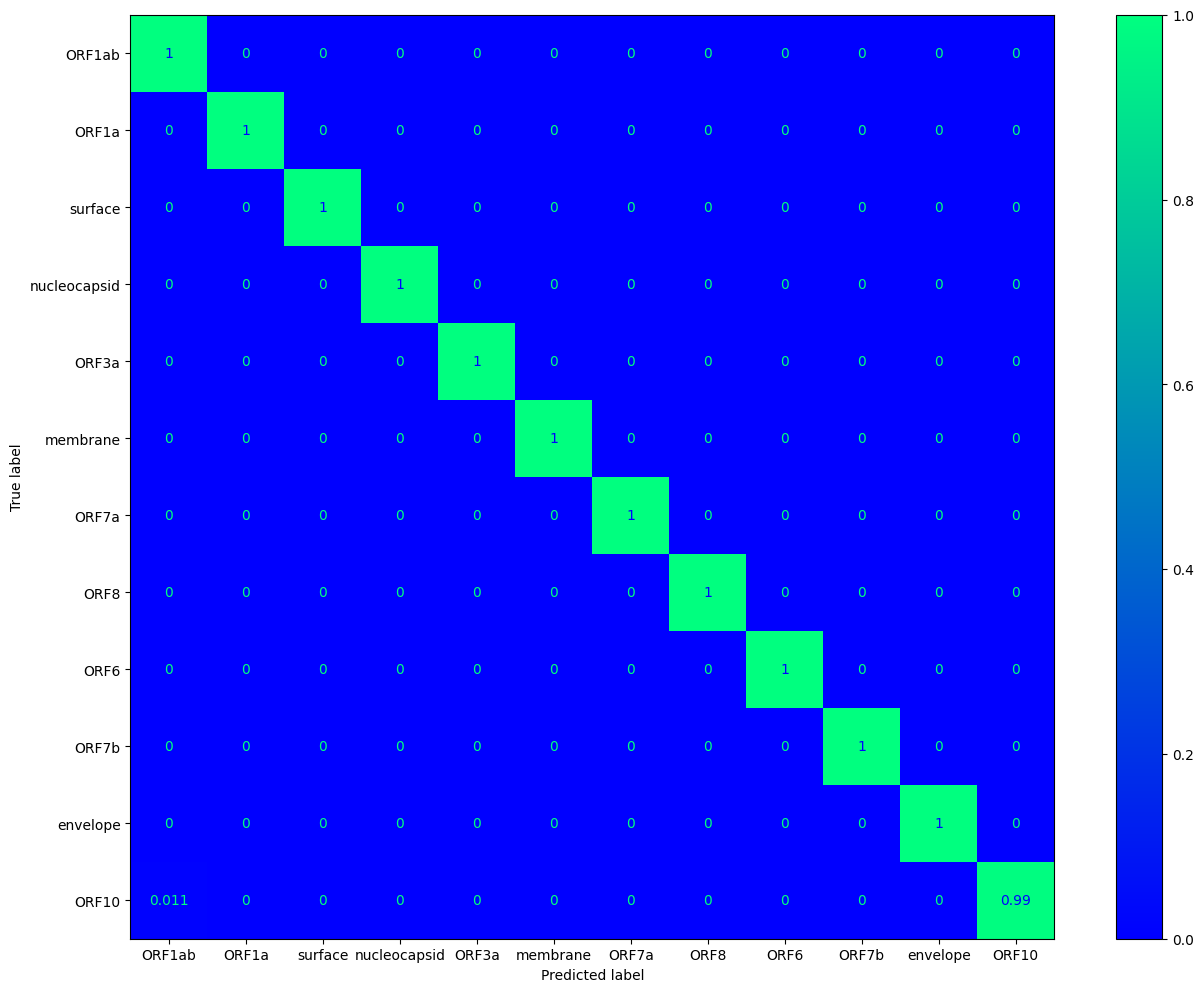

In [83]:
cm = confusion_matrix(y_true, y_pred, normalize='true', labels=protein_labels)
fig = ConfusionMatrixDisplay(cm, display_labels=labels2display)

_, ax = plt.subplots(figsize=(16,12))

fig.plot(ax=ax, cmap='winter')
plt.show()

Važnost atributa za test skup podataka.

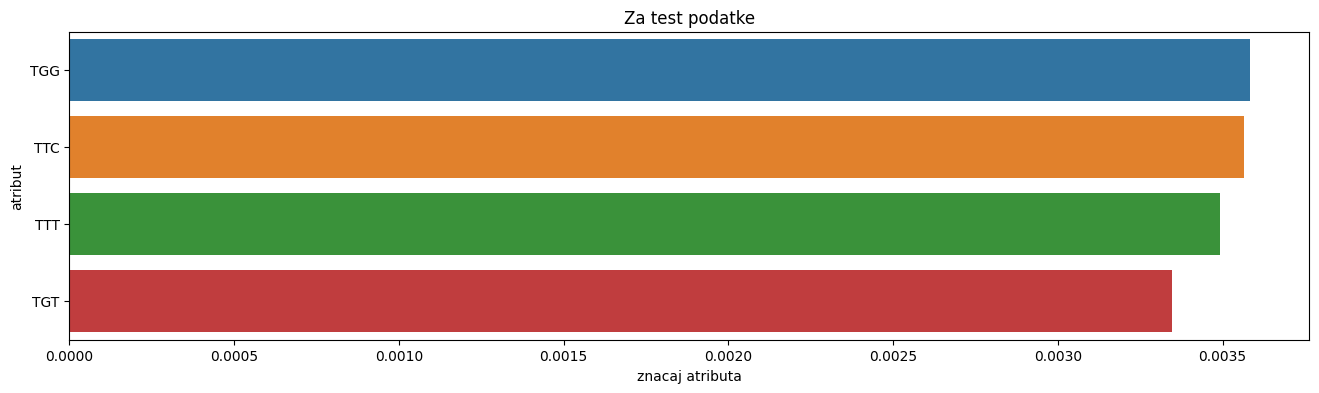

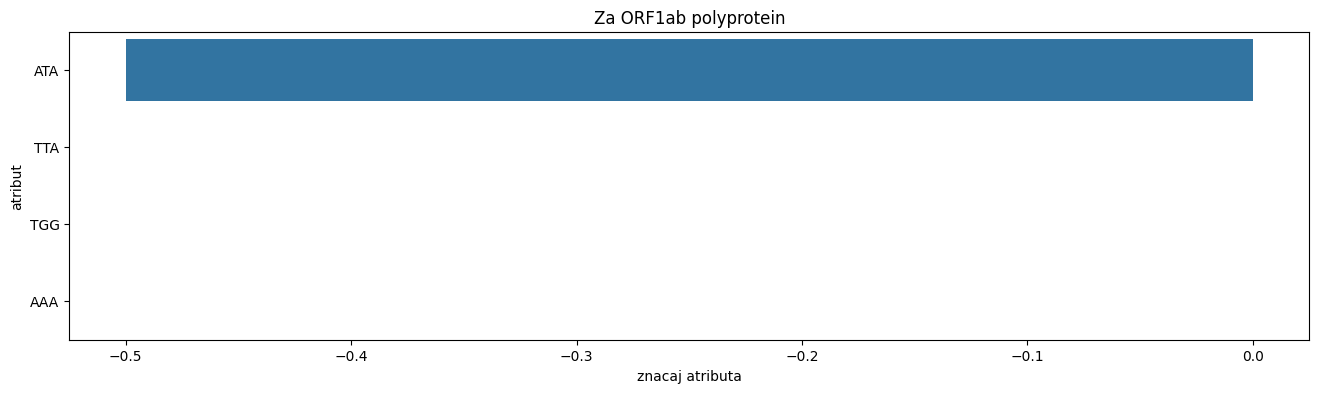

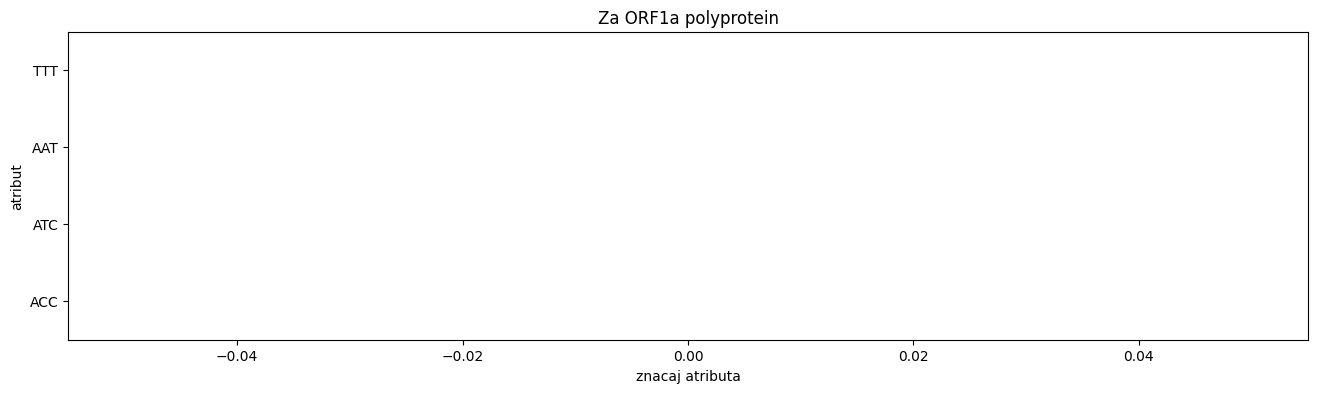

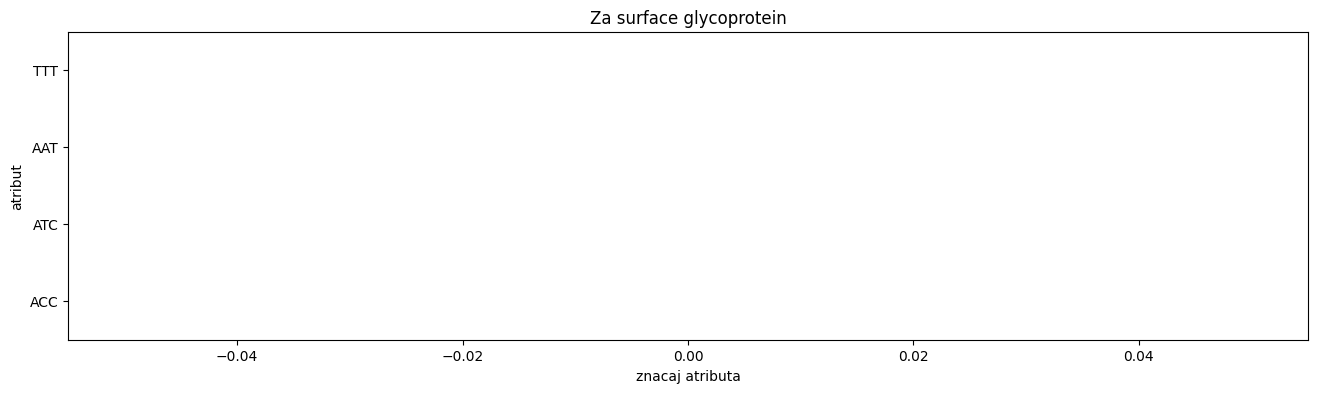

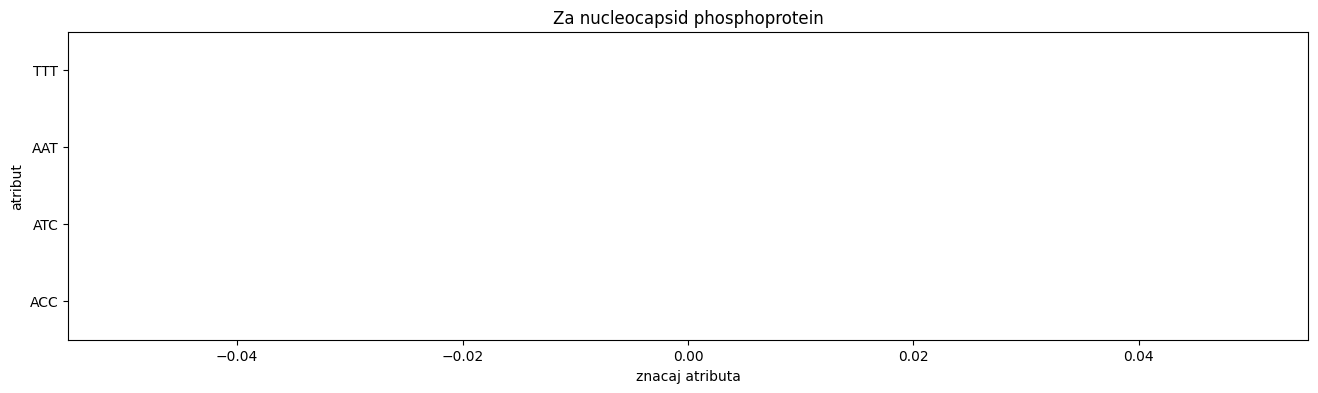

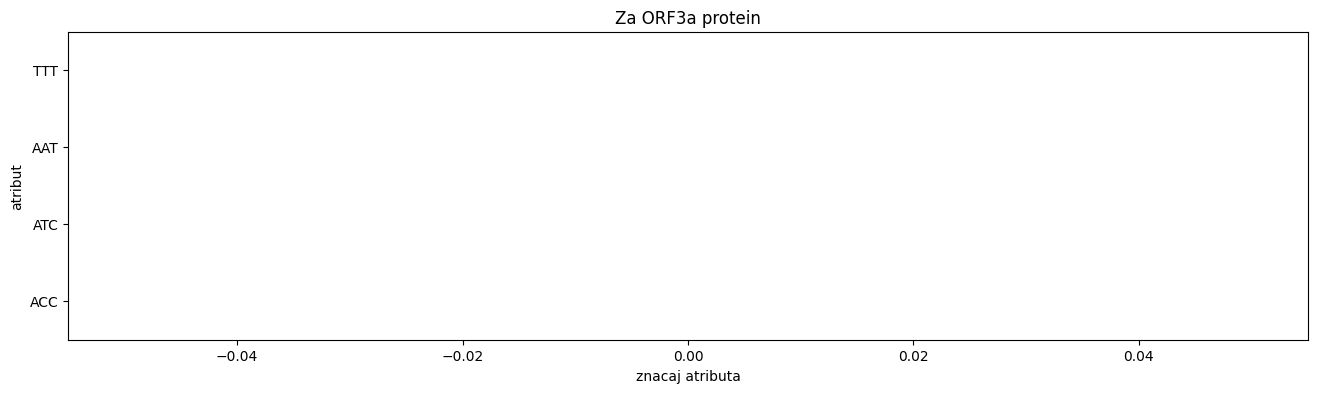

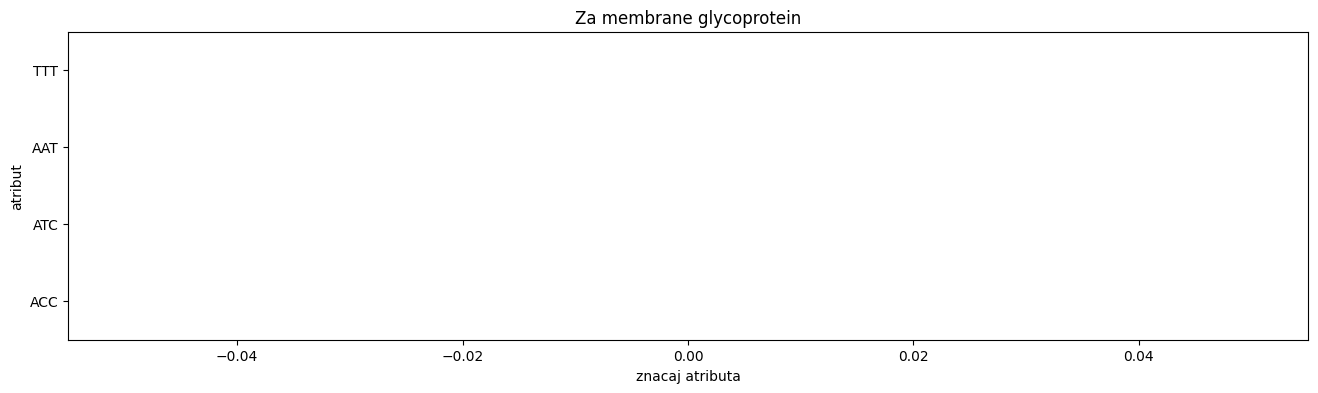

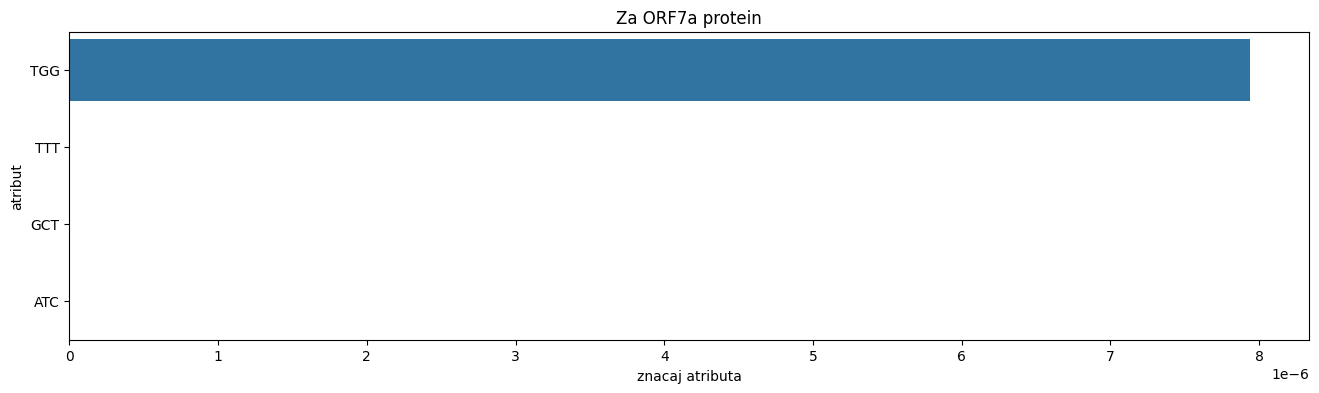

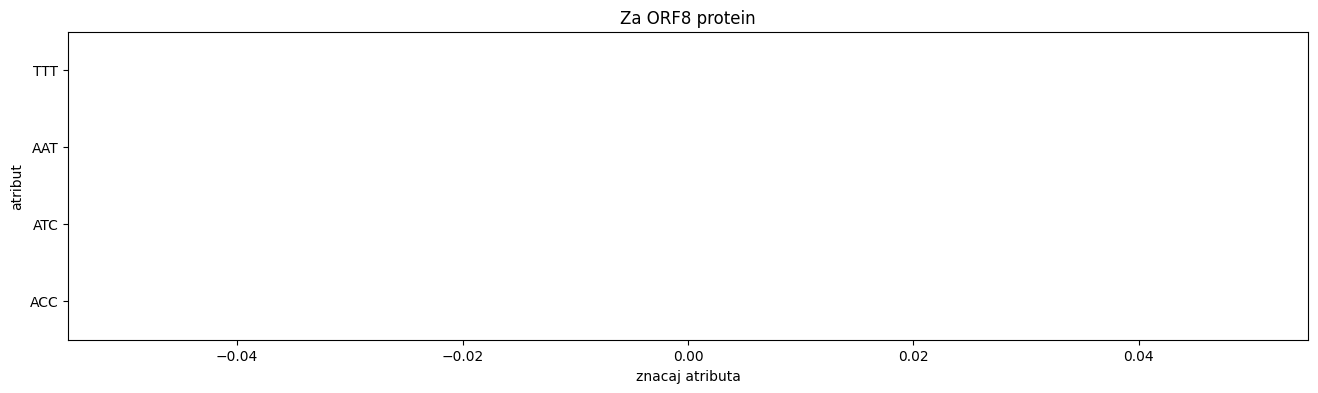

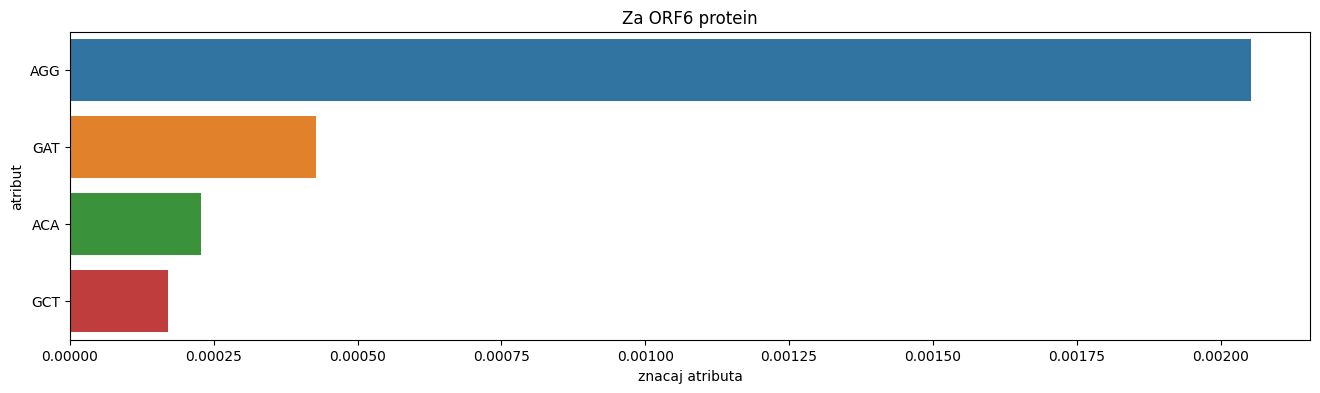

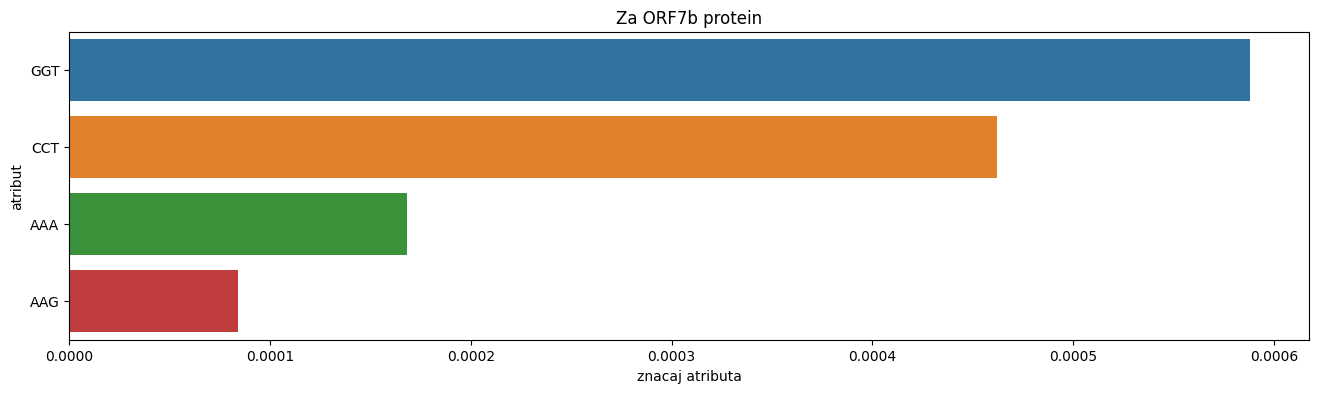

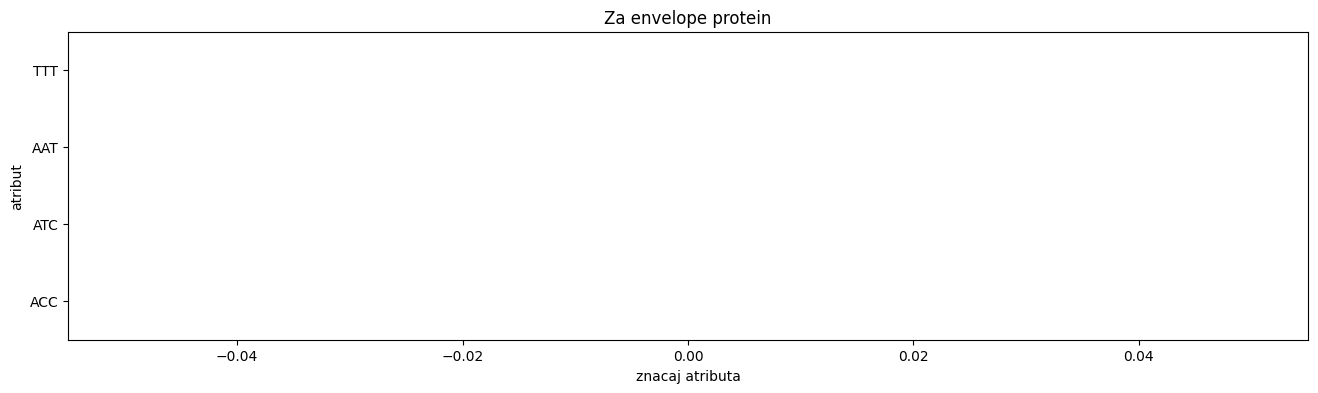

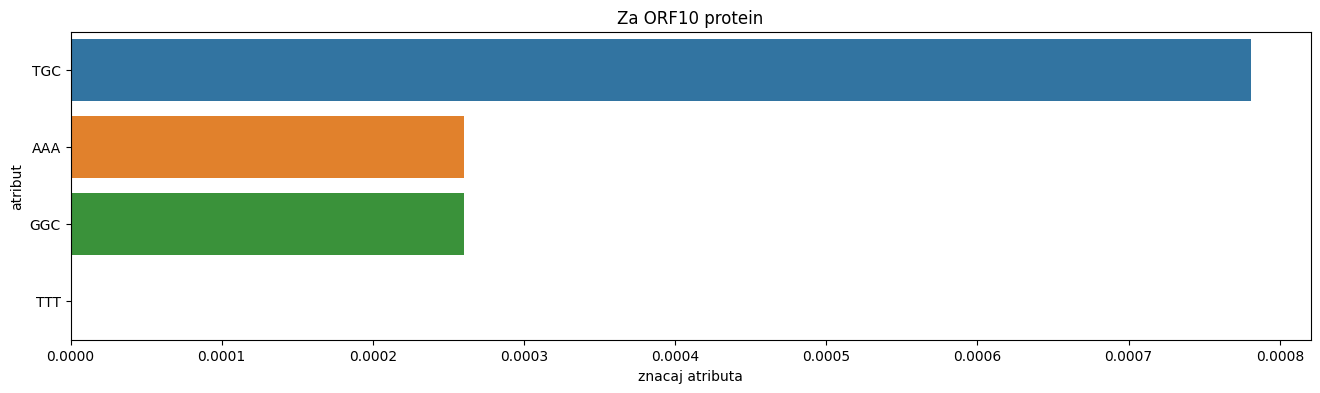

In [84]:
plot_feature_importances(clf, X_test, y_test,
                         'Za test podatke',
                         n_repeats=128, n_jobs=-1)

for protein in protein_labels:
    plot_feature_importances(clf,
                             X_test[y_pred == protein],
                             y_test[y_pred == protein],
                             f'Za {protein}',
                             n_repeats=128, n_jobs=-1)

## Zaključak

Najbolje rezultate su postigle metode ansambla *nasumična šuma* i *ekstremno gradijentno pojačavanje*.
Ove dve metode su dale modele koji praktično savršeno klasifikuju, kako instance iz trening skupa, tako i instance iz test skupa.
Klasifikator dobijen metodom *nasumične šume* se sastoji iz 128 preprilagođenih stabala, dok klasifikator dobijen *ekstremnim gradijentnim pojačavanjem* se sastoji iz 64 potprilagođena stabla dubine 2, pa bi mogli reći da je dobijeni model jednostavniji.
Sa druge strane algoritmi ansambla zasnovani na pojačavanju po pravilu zahtevaju više vremena u trening fazi, jer je sam proces iterativan.

Premda metode ansambla daju bolje klasifikatore, oni su manje pogodni za interpretaciju.
Ybog postupnosti, algoritam pojačavanja bi mogao da se interpretira, korak po korak.
No analiza ponašanja 64 stabla koja sekvencijalno vrše klasifikaciju može da bude zamoran posao.
Zato ih posmatramo kao crne kutije i ocenjujemo ih na osnovu rezultata klasifikacije.

Zatim sledi *mašina sa potpornim vektorima*, koja je takođe savršeno klasifikovala instance iz trening skupa skupa, ali na test skupu $1\%$ instanci koje pripadaju klasi *ORF10* proteina su klasifikovane kao *ORF1ab* protein.
Zbog toga kažemo da je model blago preprilagođen.
Problem sa *ORF10* proteionom je veoma malo zastupljen u podacima i uprkos tome što smo klasama dodelili težine na osnovu njihove zastupljenosti u podacima, ne iznenađuje što kvalitet klasifikacije opada kod klase za koju imamo malo podataka.

Teoretski posmatrano, mašina sa potpornim vektorima bi trebalo da daje interpretabilne modele.
Možemo da projekujemo podatke i hiperravan na dve ose i posmatramo gde je margina i kako su podaci razdvojeni.
Međutim, sam broj dimenzija u našim podacima otežava interpretaciju ovog modela.
Postavljaju se pitanja, kako projektovati podatke?
Koje ose izabrati?
Pokušavajući da odgovorimo na ta pitanja dolazimo do kombinatorne eksplozije mogućnosti.

Algoritam *CART* je takođe dao rezultat kakvog se ne bi stideli ni jači klasifikatori.
Po klasama, dobijeni model klasifikuje preko $99\%$ instanci ispravno, kako na trening, tako i na test skupu.
Međutim, neke greške ipak postoje.
Te greške deluju dosta nasumično, tako da ne možemo reći da su izazvane neuravnoteženošću podataka.
Jednostavno, to je najbolje što ovaj klasifikator može da postigne sa ovim podacima, što uopšte nije loše.

Bez obzira na visoku dimanzionalnost podataka, stabla odlučivanja daju modele koji se jednostavno mogu interpretirati.
Dobijeni model možemo predstaviti grafički i jednostavno analizirati model, znajući tačno kako će svaka instanca biti klasifikovana.

U poređenju sa metodama ansambla, faza treniranja za *stablo odlučivanja* i *mašinu sa potpornim vektorima* je bila znatno brža.

Konačno, naivni Bajesov algoritam nije proizveo klasifikator prihvatljivih performansi.
Iako bi trik sa računanjem komplemenata trebalo da otkloni problem sa nauravnoteženih podataka, dobijeni model je ispravno klasifikovao samo instance samo 5 najzastupljenijih klasa, dok je instance ostalih klasa potpuno pogrešno klasifikovao, sa izuzetkom za proteina *ORF7a* i *ORF8*, gde je takođe pravio velike greške.
Čak ni u metodi pakovanja naivni Bajesov algoritam nije dao bolje rezultate.

Prilikom ocenjivanja modela dobijenog naivnim Bajesovim algoritmom mogli smo da primetimo da nisu sve metrike jednako pogodne za neuravnotežene podatke.
Primenom metrike tačnost, model je dobio ocenu $0.99$, što znači da model klasifikuje $99\%$ instanci ispravno.
No ta metrika posmatra ukupan broj ispravno klasifikovanih instanci u odnosu na ukupan broj instanci, bez obzira kojoj klasi pripadaju.
To daje veoma nepreciznu ocenu, posebno u slučaju kada $79\%$ instanci su predstavnici dve od dvanaest klasa.

Najbolji način da se prevaziđe problem neuravnoteženosti podataka je da se uzme još uzoraka za one klase koje nedostaju.
U našem slučaju, to bi bilo dodadtno sekvenciranje gena i proteina.
Taj način je skup i zahteva dosta vremena.
Mi pravimo klasifikatore da upravo to ne bi morali da radimo.

Drugi način bi bio da na neki način generišemo podatke iz manje zastupljenih klasa i iskoristimo ih za obučavanje modela.
Ta metoda je sama po sebi kompromis.
Mi ne znamo da u kojoj meri bi generisani podaci bili reprezentativni.

Treći način bi bio da odbacimo deo podataka iz zastupljenijih klasa i tako uravnotežimo podatke.
Uslovno govoreći, ti podaci ne bi bili generički, ali time bi globalno smanjili kvalitet podataka i pitanje je koliko bi klasifikator dobijen sa tim podacima bio relevantan u praksi.

Imajući u vidu da smo sa postojećim podacima, primenjujući druge algoritme, već dobili veoma dobre modele, nema potrebe da sprovodimo intervencije koje bi mogle da kompromituju podatke, samo da bi pomogli slabijem klasifikatoru da napravi bolji model.